In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from cmath import isinf
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import math
from utils_v import compute_target_score, estimate_target, save_model
from cmath import isinf
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, KFold, LearningCurveDisplay, learning_curve
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from helper_classes import MatData, KernelizedSupCon, MLP, cauchy, rbf, gaussian_kernel

In [3]:
dataset = MatData("vectorized_matrices_la5c.npy", "hopkins.npy")

In [4]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [5]:
train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

In [6]:
input_dim_feat = 499500 # vectorized mat, diagonal discarded
input_dim_target = 58
hidden_dim_feat = 128
hidden_dim_target = 10
output_dim = 2




In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = MLP(input_dim_feat, input_dim_target, hidden_dim_feat, hidden_dim_target, output_dim)

In [ ]:
model = model.to(device)

criterion = KernelizedSupCon(method = 'expw', kernel = cauchy) # gaussian kernel returns nans for some reason
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
results_cv = []
best_mae = np.inf
best_r2 = -np.inf
best_average_loss = np.inf
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Starting fold {fold}")

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=10, sampler=train_subsampler)
    val_loader = DataLoader(train_dataset, batch_size=10, sampler=val_subsampler)
    
    model = MLP(input_dim_feat, input_dim_target, hidden_dim_feat, hidden_dim_target, output_dim).to(device)
    criterion = KernelizedSupCon(method='expw', kernel=gaussian_kernel)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    num_epochs = 100
    
    for epoch in range(num_epochs):
        model.train()
        batch_losses = []
        for batch_num, (features, targets) in enumerate(train_loader):
            features, targets = features.to(device), targets.to(device)
            optimizer.zero_grad()
            out_feat, out_target = model(features, targets)
            loss = criterion(out_feat, out_target)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
        print(f'Fold {fold} | Epoch {epoch} | Mean Loss {sum(batch_losses)/len(batch_losses)}')
            
    val_losses = []
    model.eval() 
    with torch.no_grad():
        total_loss = 0
        total_samples = 0
        for features, targets in val_loader:
            features = features.to(device).float()
            targets = targets.to(device)

            out_feat, out_target = model(features, targets)
            loss = criterion(out_feat, out_target)
            val_losses.append(loss.item())
            total_loss += loss.item() * features.size(0)
            total_samples += features.size(0)
        val_losses =np.array(val_losses)
        average_loss = total_loss / total_samples
        if best_average_loss > average_loss:
            best_average_loss = average_loss
            save_model(model, fold, optimizer, f"best_model_hopkins_cv.pt")
#     mae_train, mae_val = compute_target_score(model, train_loader, val_loader, device, 'mae')
#     r2_train, r2_val = compute_target_score(model, train_loader, val_loader, device, 'r2')
#     if mae_val < best_mae and r2_val > best_r2:
#         best_mae = mae_val
#         best_r2 = r2_val
#         save_model(model, fold, optimizer, f"best_model_hopkins_cv.pt")
#     results_cv.append([fold, mae_train, r2_train, mae_val, r2_val])

    

Starting fold 0
tensor([[ 0.8831, -0.4691],
        [ 0.8934, -0.4493],
        [ 0.9296, -0.3686],
        [ 0.5490, -0.8358],
        [ 0.9967, -0.0814],
        [ 0.8399, -0.5428],
        [ 0.9880,  0.1545],
        [ 0.8482, -0.5297],
        [ 0.1439, -0.9896],
        [ 0.9941, -0.1089]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.0243, -0.9997],
        [ 0.7645, -0.6446],
        [ 0.5020, -0.8649],
        [ 0.7098, -0.7044],
        [ 0.2811, -0.9597],
        [-0.0123, -0.9999],
        [ 0.7055, -0.7087],
        [ 0.7852, -0.6192],
        [ 0.1940, -0.9810],
        [ 0.4326, -0.9016]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.6887, -0.7250],
        [ 0.7006, -0.7135],
        [ 0.6929, -0.7210],
        [ 0.6849, -0.7286],
        [ 0.7343, -0.6788],
        [ 0.6922, -0.7217],
        [ 0.6935, -0.7205],
        [ 0.7231, -0.6908],
        [ 0.6776, -0.7354],
        [ 0.7119, -0.7023]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.5243, 

tensor([[ 0.6969, -0.7172],
        [ 0.7067, -0.7075],
        [ 0.7040, -0.7102],
        [ 0.7053, -0.7089],
        [ 0.6991, -0.7150],
        [ 0.7008, -0.7134],
        [ 0.9402, -0.3408],
        [ 0.7014, -0.7127],
        [ 0.7013, -0.7129],
        [ 0.6778, -0.7353]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.1323, -0.9912],
        [ 0.1569, -0.9876],
        [ 0.4880, -0.8728],
        [ 0.9987, -0.0518],
        [ 0.5474, -0.8369],
        [ 0.3603, -0.9328],
        [-0.0350, -0.9994],
        [-0.0596, -0.9982],
        [ 0.8794, -0.4760],
        [ 0.0073, -1.0000]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.7147, -0.6995],
        [ 0.7068, -0.7074],
        [ 0.7001, -0.7141],
        [ 0.7047, -0.7095],
        [ 0.7088, -0.7054],
        [ 0.7057, -0.7085],
        [ 0.6805, -0.7327],
        [ 0.7111, -0.7031],
        [ 0.7090, -0.7052],
        [ 0.7075, -0.7067]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9161, -0.4010],
      

tensor([[ 0.7243, -0.6894],
        [ 0.7276, -0.6860],
        [ 0.7317, -0.6816],
        [ 0.7151, -0.6990],
        [ 0.7284, -0.6851],
        [ 0.7211, -0.6928],
        [ 0.7200, -0.6940],
        [ 0.8016, -0.5978],
        [ 0.7242, -0.6896],
        [ 0.7211, -0.6928]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.2477, -0.9688],
        [ 0.2487, -0.9686],
        [ 0.3327, -0.9430],
        [ 0.9743, -0.2253],
        [ 0.9894, -0.1450],
        [ 0.7374, -0.6755],
        [ 0.3090, -0.9511],
        [-0.0770, -0.9970],
        [ 0.9477, -0.3191],
        [ 0.1372, -0.9905]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.7317, -0.6816],
        [ 0.7155, -0.6986],
        [ 0.7265, -0.6871],
        [ 0.7272, -0.6864],
        [ 0.7292, -0.6843],
        [ 0.7202, -0.6937],
        [ 0.7222, -0.6917],
        [ 0.7213, -0.6926],
        [ 0.7155, -0.6986],
        [ 0.7222, -0.6917]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.2878, -0.9577],
      

tensor([[ 0.7374, -0.6754],
        [ 0.7090, -0.7052],
        [ 0.7292, -0.6843],
        [ 0.7142, -0.6999],
        [ 0.7265, -0.6872],
        [ 0.8078, -0.5894],
        [ 0.7278, -0.6858],
        [ 0.7415, -0.6710],
        [ 0.7235, -0.6903],
        [ 0.7280, -0.6856]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8485, -0.5291],
        [ 0.9880,  0.1541],
        [ 0.2546, -0.9670],
        [ 0.7211, -0.6928],
        [ 0.9908, -0.1356],
        [ 0.8476, -0.5306],
        [ 0.9596, -0.2814],
        [ 0.3721, -0.9282],
        [ 0.0362, -0.9993],
        [ 1.0000,  0.0052]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.7336, -0.6796],
        [ 0.7159, -0.6982],
        [ 0.7260, -0.6877],
        [ 0.7246, -0.6892],
        [ 0.7500, -0.6615],
        [ 0.7298, -0.6837],
        [ 0.7131, -0.7011],
        [ 0.7394, -0.6732],
        [ 0.7245, -0.6893],
        [ 0.7258, -0.6879]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6257, -0.7801],
      

tensor([[ 0.7386, -0.6741],
        [ 0.7391, -0.6735],
        [ 0.7414, -0.6711],
        [ 0.7378, -0.6750],
        [ 0.7338, -0.6793],
        [ 0.8692, -0.4945],
        [ 0.7249, -0.6888],
        [ 0.7346, -0.6785],
        [ 0.7213, -0.6926],
        [ 0.7348, -0.6783]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8172, -0.5763],
        [ 0.8645, -0.5025],
        [ 0.7039, -0.7103],
        [ 0.7871, -0.6168],
        [ 0.8744, -0.4852],
        [-0.3387, -0.9409],
        [ 0.9283,  0.3718],
        [ 0.9999,  0.0141],
        [ 0.2792, -0.9602],
        [ 0.9560,  0.2935]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.7489, -0.6626],
        [ 0.7425, -0.6699],
        [ 0.7359, -0.6771],
        [ 0.7345, -0.6786],
        [ 0.6822, -0.7312],
        [ 0.7419, -0.6705],
        [ 0.7310, -0.6824],
        [ 0.7243, -0.6895],
        [ 0.7278, -0.6858],
        [ 0.7324, -0.6808]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.2810, -0.9597],
      

tensor([[ 0.7687, -0.6396],
        [ 0.6994, -0.7148],
        [ 0.7343, -0.6788]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9660, -0.2584],
        [ 0.9991, -0.0419],
        [ 0.9896,  0.1436]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 0 | Epoch 8 | Mean Loss 2.0492809295654295
tensor([[ 0.7276, -0.6860],
        [ 0.7267, -0.6870],
        [ 0.7254, -0.6883],
        [ 0.7506, -0.6608],
        [ 0.7313, -0.6820],
        [ 0.7388, -0.6740],
        [ 0.6807, -0.7326],
        [ 0.7325, -0.6807],
        [ 0.7342, -0.6789],
        [ 0.7401, -0.6725]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8252, -0.5649],
        [ 0.9509, -0.3096],
        [ 0.9421,  0.3353],
        [ 0.4075, -0.9132],
        [ 0.9375, -0.3480],
        [ 0.1231, -0.9924],
        [ 0.2725, -0.9622],
        [ 0.9886,  0.1508],
        [ 0.7621, -0.6474],
        [-0.2195, -0.9756]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.7268, -0.6869],
        [ 0.7318, -0.6816],


tensor([[ 0.7177, -0.6964],
        [ 0.7121, -0.7020],
        [ 0.7162, -0.6979],
        [ 0.7113, -0.7029],
        [ 0.7218, -0.6921],
        [ 0.7257, -0.6880],
        [ 0.7375, -0.6754],
        [ 0.7173, -0.6967],
        [ 0.7219, -0.6920],
        [ 0.7126, -0.7016]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9994,  0.0346],
        [ 0.3057, -0.9521],
        [ 0.8943, -0.4474],
        [ 0.9895,  0.1443],
        [ 0.1709, -0.9853],
        [-0.5016, -0.8651],
        [ 0.4270, -0.9043],
        [ 0.9836, -0.1801],
        [ 0.7955, -0.6059],
        [ 0.7973, -0.6036]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.7096, -0.7046],
        [ 0.7192, -0.6948],
        [ 0.7147, -0.6994],
        [ 0.7083, -0.7059],
        [ 0.7211, -0.6929],
        [ 0.7305, -0.6829],
        [ 0.7072, -0.7070],
        [ 0.7269, -0.6868],
        [ 0.8451, -0.5346],
        [ 0.7108, -0.7034]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8995,  0.4369],
      

tensor([[ 0.7193, -0.6947],
        [ 0.7165, -0.6975],
        [ 0.7096, -0.7047],
        [ 0.7235, -0.6904],
        [ 0.7196, -0.6944],
        [ 0.7195, -0.6945],
        [ 0.7280, -0.6855],
        [ 0.7252, -0.6885],
        [ 0.7206, -0.6933],
        [ 0.7182, -0.6958]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7936, -0.6085],
        [ 0.9778, -0.2095],
        [ 0.8205,  0.5717],
        [ 0.1319, -0.9913],
        [ 0.5572, -0.8304],
        [ 0.3742, -0.9273],
        [-0.3130, -0.9498],
        [ 0.2710, -0.9626],
        [ 0.9976, -0.0694],
        [ 0.7944, -0.6074]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.7168, -0.6973],
        [ 0.7195, -0.6945],
        [ 0.7276, -0.6860],
        [ 0.7243, -0.6895],
        [ 0.7098, -0.7044],
        [ 0.7395, -0.6732],
        [ 0.7189, -0.6951],
        [ 0.7324, -0.6809],
        [ 0.7217, -0.6922],
        [ 0.7066, -0.7076]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9784, -0.2068],
      

tensor([[ 0.7127, -0.7014],
        [ 0.6921, -0.7218],
        [ 0.7182, -0.6959],
        [ 0.6999, -0.7143],
        [ 0.7177, -0.6963],
        [ 0.7118, -0.7023],
        [ 0.7344, -0.6788],
        [ 0.7221, -0.6918],
        [ 0.7352, -0.6779],
        [ 0.7056, -0.7086]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8121, -0.5835],
        [ 0.9060,  0.4233],
        [ 0.9525, -0.3045],
        [ 0.9957,  0.0922],
        [ 0.5269, -0.8500],
        [ 0.9907, -0.1358],
        [-0.6565, -0.7543],
        [ 0.2670, -0.9637],
        [-0.3682, -0.9298],
        [ 0.9126,  0.4089]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.7064, -0.7078],
        [ 0.7071, -0.7071],
        [ 0.7195, -0.6945],
        [ 0.6962, -0.7178],
        [ 0.7252, -0.6885],
        [ 0.7221, -0.6918],
        [ 0.7404, -0.6722],
        [ 0.7041, -0.7101],
        [ 0.7376, -0.6752],
        [ 0.7015, -0.7127]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9487,  0.3161],
      

tensor([[ 0.7157, -0.6984],
        [ 0.7101, -0.7041],
        [ 0.7470, -0.6649],
        [ 0.7122, -0.7020],
        [ 0.7005, -0.7137],
        [ 0.7032, -0.7109],
        [ 0.7126, -0.7016],
        [ 0.7065, -0.7077],
        [ 0.7071, -0.7071],
        [ 0.7337, -0.6795]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9991, -0.0425],
        [ 0.9116,  0.4110],
        [ 0.0455, -0.9990],
        [ 0.9683,  0.2496],
        [ 0.9452,  0.3266],
        [ 0.9287,  0.3710],
        [ 0.9323,  0.3618],
        [ 0.6856,  0.7279],
        [ 0.9748,  0.2229],
        [ 0.3351, -0.9422]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.6998, -0.7143],
        [ 0.7006, -0.7135],
        [ 0.6935, -0.7205],
        [ 0.6967, -0.7173],
        [ 0.7136, -0.7005],
        [ 0.7313, -0.6820],
        [ 0.7357, -0.6773],
        [ 0.7366, -0.6763],
        [ 0.7121, -0.7021],
        [ 0.7519, -0.6592]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9940,  0.1092],
      

tensor([[ 0.6749, -0.7379],
        [ 0.7555, -0.6551],
        [ 0.7492, -0.6623],
        [ 0.7114, -0.7028],
        [ 0.6452, -0.7640],
        [ 0.6748, -0.7380],
        [ 0.6878, -0.7259],
        [ 0.7110, -0.7032],
        [ 0.6992, -0.7149],
        [ 0.7296, -0.6839]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 7.7899e-01,  6.2704e-01],
        [-5.3546e-02, -9.9857e-01],
        [-8.6217e-04, -1.0000e+00],
        [ 9.8863e-01,  1.5034e-01],
        [ 6.2688e-01,  7.7911e-01],
        [ 2.5401e-01,  9.6720e-01],
        [ 7.8593e-01,  6.1832e-01],
        [ 9.8956e-01,  1.4416e-01],
        [ 8.3156e-01,  5.5543e-01],
        [-2.4489e-01, -9.6955e-01]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.6801, -0.7331],
        [ 0.7156, -0.6985],
        [ 0.7330, -0.6802],
        [ 0.7181, -0.6959],
        [ 0.7102, -0.7040],
        [ 0.6927, -0.7213],
        [ 0.7298, -0.6837],
        [ 0.7644, -0.6448],
        [ 0.7030, -0.7112],
        [ 0.6913, -0.722

tensor([[ 0.6760, -0.7369],
        [ 0.6538, -0.7566],
        [ 0.6986, -0.7155],
        [ 0.7021, -0.7121],
        [ 0.6334, -0.7738],
        [ 0.6903, -0.7235],
        [ 0.7438, -0.6684],
        [ 0.6593, -0.7519],
        [ 0.6487, -0.7610],
        [ 0.6707, -0.7417]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9709, -0.2393],
        [ 0.6995,  0.7146],
        [ 0.6684, -0.7438],
        [ 0.9231, -0.3845],
        [ 0.8193,  0.5733],
        [ 0.7509, -0.6605],
        [-0.0863, -0.9963],
        [ 0.9991,  0.0428],
        [ 0.9717,  0.2363],
        [ 0.7682,  0.6402]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.7399, -0.6727],
        [ 0.7757, -0.6311],
        [ 0.6554, -0.7552],
        [ 0.6945, -0.7195],
        [ 0.6026, -0.7981],
        [ 0.7096, -0.7046],
        [ 0.6354, -0.7722],
        [ 0.6156, -0.7881],
        [ 0.7309, -0.6825],
        [ 0.6761, -0.7368]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.7455, -0.6665],
      

tensor([[ 0.6159, -0.7878],
        [ 0.5347, -0.8450],
        [ 0.6932, -0.7208],
        [ 0.8372, -0.5469],
        [ 0.5369, -0.8436],
        [ 0.5212, -0.8534],
        [ 0.5766, -0.8170],
        [ 0.5162, -0.8565],
        [ 0.6376, -0.7704],
        [ 0.6298, -0.7768]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8440,  0.5363],
        [ 0.6415,  0.7671],
        [ 0.9410,  0.3384],
        [-0.4204, -0.9073],
        [ 0.5655,  0.8247],
        [ 0.7655,  0.6435],
        [ 0.9686,  0.2486],
        [ 0.6796,  0.7335],
        [ 0.9805,  0.1965],
        [ 0.8696,  0.4938]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.8487, -0.5289],
        [ 0.8598, -0.5106],
        [ 0.8116, -0.5842],
        [ 0.7225, -0.6914],
        [ 0.5785, -0.8157],
        [ 0.4836, -0.8753],
        [ 0.4543, -0.8908],
        [ 0.6643, -0.7475],
        [ 0.8749, -0.4844],
        [ 0.5443, -0.8389]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.0556, -0.9985],
      

tensor([[ 0.9096, -0.4155],
        [ 0.6223, -0.7828],
        [ 0.7600, -0.6500],
        [ 0.8761, -0.4821],
        [ 0.5731, -0.8195],
        [ 0.5901, -0.8074],
        [ 0.5480, -0.8365],
        [ 0.5709, -0.8210],
        [ 0.5511, -0.8345],
        [ 0.8200, -0.5724]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.6015, -0.7989],
        [ 0.6016,  0.7988],
        [ 0.9174, -0.3979],
        [-0.8802, -0.4747],
        [ 0.6983,  0.7158],
        [ 0.8298,  0.5581],
        [ 0.7165,  0.6976],
        [ 0.5737,  0.8190],
        [ 0.5448,  0.8386],
        [ 0.5303, -0.8478]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.5647, -0.8253],
        [ 0.7657, -0.6432],
        [ 0.5728, -0.8197],
        [ 0.8949, -0.4463],
        [ 0.5082, -0.8613],
        [ 0.5767, -0.8170],
        [ 0.5818, -0.8133],
        [ 0.5220, -0.8529],
        [ 0.5956, -0.8033],
        [ 0.8702, -0.4927]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.5278,  0.8494],
      

tensor([[ 0.5369, -0.8436],
        [ 0.9078, -0.4195],
        [ 0.6107, -0.7918]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7885,  0.6151],
        [-0.4882, -0.8727],
        [ 0.8553,  0.5181]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 0 | Epoch 24 | Mean Loss 1.8586906969547272
tensor([[ 0.5649, -0.8252],
        [ 0.8935, -0.4491],
        [ 0.5935, -0.8048],
        [ 0.5587, -0.8294],
        [ 0.8986, -0.4387],
        [ 0.8917, -0.4526],
        [ 0.5707, -0.8212],
        [ 0.5826, -0.8128],
        [ 0.6025, -0.7981],
        [ 0.5542, -0.8324]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8090,  0.5878],
        [-0.8382, -0.5453],
        [ 0.6570,  0.7539],
        [ 0.5840,  0.8117],
        [-0.7653, -0.6437],
        [-0.7389, -0.6738],
        [ 0.7019,  0.7123],
        [ 0.6853,  0.7283],
        [ 0.8050,  0.5933],
        [ 0.7490,  0.6626]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.9055, -0.4244],
        [ 0.6486, -0.7611],

tensor([[ 0.4961, -0.8683],
        [ 0.8757, -0.4829],
        [ 0.8579, -0.5138],
        [ 0.8351, -0.5501],
        [ 0.4835, -0.8753],
        [ 0.4311, -0.9023],
        [ 0.4901, -0.8717],
        [ 0.5022, -0.8648],
        [ 0.8523, -0.5231],
        [ 0.8266, -0.5629]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.5461,  0.8377],
        [-0.5220, -0.8530],
        [-0.7359, -0.6771],
        [-0.2747, -0.9615],
        [ 0.6382,  0.7699],
        [ 0.7862,  0.6180],
        [ 0.6508,  0.7593],
        [ 0.8882,  0.4594],
        [-0.6341, -0.7732],
        [-0.7893, -0.6140]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.4948, -0.8690],
        [ 0.5255, -0.8508],
        [ 0.4504, -0.8928],
        [ 0.8853, -0.4650],
        [ 0.8753, -0.4836],
        [ 0.4807, -0.8769],
        [ 0.8644, -0.5028],
        [ 0.5063, -0.8623],
        [ 0.4789, -0.8779],
        [ 0.5342, -0.8454]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6786,  0.7345],
      

tensor([[ 0.5116, -0.8593],
        [ 0.4986, -0.8669],
        [ 0.5069, -0.8620],
        [ 0.4979, -0.8672],
        [ 0.4887, -0.8724],
        [ 0.5259, -0.8506],
        [ 0.5176, -0.8556],
        [ 0.8869, -0.4620],
        [ 0.4995, -0.8663],
        [ 0.4813, -0.8765]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.4845,  0.8748],
        [ 0.6763,  0.7367],
        [ 0.5912,  0.8066],
        [ 0.7014,  0.7128],
        [ 0.6796,  0.7336],
        [ 0.5858,  0.8105],
        [ 0.5751,  0.8181],
        [-0.7229, -0.6909],
        [ 0.6857,  0.7279],
        [ 0.6448,  0.7644]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.4859, -0.8740],
        [ 0.5336, -0.8457],
        [ 0.9322, -0.3618],
        [ 0.4951, -0.8688],
        [ 0.4978, -0.8673],
        [ 0.4965, -0.8680],
        [ 0.4955, -0.8686],
        [ 0.4955, -0.8686],
        [ 0.4834, -0.8754],
        [ 0.8706, -0.4920]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.5975,  0.8019],
      

tensor([[ 0.4991, -0.8666],
        [ 0.5175, -0.8557],
        [ 0.5122, -0.8589],
        [ 0.8927, -0.4507],
        [ 0.5169, -0.8561],
        [ 0.4931, -0.8700],
        [ 0.4866, -0.8736],
        [ 0.8893, -0.4573],
        [ 0.8828, -0.4698],
        [ 0.5102, -0.8600]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.5816,  0.8135],
        [ 0.7340,  0.6792],
        [ 0.5889,  0.8082],
        [-0.6756, -0.7373],
        [ 0.7632,  0.6462],
        [ 0.5634,  0.8262],
        [ 0.5059,  0.8626],
        [-0.7468, -0.6650],
        [-0.6310, -0.7758],
        [ 0.8049,  0.5934]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.8855, -0.4647],
        [ 0.5100, -0.8602],
        [ 0.4854, -0.8743],
        [ 0.5080, -0.8614],
        [ 0.5095, -0.8605],
        [ 0.5195, -0.8545],
        [ 0.8889, -0.4581],
        [ 0.8882, -0.4595],
        [ 0.5129, -0.8584],
        [ 0.4906, -0.8714]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.7204, -0.6935],
      

tensor([[ 0.8742, -0.4856],
        [ 0.8773, -0.4799],
        [ 0.5084, -0.8611],
        [ 0.5121, -0.8589],
        [ 0.8741, -0.4857],
        [ 0.8679, -0.4968],
        [ 0.5035, -0.8640],
        [ 0.5054, -0.8629],
        [ 0.4913, -0.8710],
        [ 0.8766, -0.4811]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.6610, -0.7504],
        [-0.6543, -0.7562],
        [ 0.9177,  0.3973],
        [ 0.6385,  0.7696],
        [-0.7163, -0.6978],
        [-0.6552, -0.7555],
        [ 0.6518,  0.7584],
        [ 0.6223,  0.7828],
        [ 0.6841,  0.7294],
        [-0.6380, -0.7700]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.5119, -0.8591],
        [ 0.5326, -0.8464],
        [ 0.8794, -0.4761],
        [ 0.5049, -0.8632],
        [ 0.5296, -0.8482],
        [ 0.5081, -0.8613],
        [ 0.8709, -0.4915],
        [ 0.5164, -0.8563],
        [ 0.5144, -0.8575],
        [ 0.5200, -0.8542]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6737,  0.7390],
      

tensor([[ 0.8802, -0.4746],
        [ 0.4963, -0.8682],
        [ 0.8691, -0.4946],
        [ 0.8592, -0.5117],
        [ 0.5072, -0.8618],
        [ 0.8614, -0.5079],
        [ 0.5063, -0.8624],
        [ 0.4929, -0.8701],
        [ 0.4986, -0.8668],
        [ 0.5096, -0.8604]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8500, -0.5267],
        [ 0.7221,  0.6918],
        [-0.7087, -0.7055],
        [-0.6849, -0.7286],
        [ 0.6357,  0.7719],
        [-0.6336, -0.7736],
        [ 0.7102,  0.7040],
        [ 0.6990,  0.7152],
        [ 0.5955,  0.8033],
        [ 0.7043,  0.7099]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.5218, -0.8530],
        [ 0.4883, -0.8727],
        [ 0.4837, -0.8752],
        [ 0.5023, -0.8647],
        [ 0.8579, -0.5139],
        [ 0.4871, -0.8733],
        [ 0.5162, -0.8565],
        [ 0.4947, -0.8690],
        [ 0.8666, -0.4990],
        [ 0.8781, -0.4785]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6338,  0.7735],
      

tensor([[ 0.8801, -0.4748],
        [ 0.5231, -0.8523],
        [ 0.5145, -0.8575],
        [ 0.8856, -0.4644],
        [ 0.5153, -0.8570],
        [ 0.5220, -0.8529],
        [ 0.5089, -0.8608],
        [ 0.8814, -0.4724],
        [ 0.8222, -0.5692],
        [ 0.5164, -0.8563]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.6709, -0.7416],
        [ 0.6131,  0.7900],
        [ 0.6827,  0.7307],
        [-0.7592, -0.6509],
        [ 0.5941,  0.8044],
        [ 0.6959,  0.7181],
        [ 0.6526,  0.7577],
        [-0.6934, -0.7206],
        [-0.1968, -0.9804],
        [ 0.5928,  0.8054]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.5117, -0.8592],
        [ 0.8812, -0.4727],
        [ 0.5048, -0.8632],
        [ 0.8821, -0.4710],
        [ 0.8883, -0.4592],
        [ 0.5073, -0.8618],
        [ 0.4613, -0.8873],
        [ 0.5217, -0.8531],
        [ 0.5194, -0.8545],
        [ 0.8817, -0.4718]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6238,  0.7816],
      

tensor([[ 0.8841, -0.4673],
        [ 0.5186, -0.8550],
        [ 0.5269, -0.8499],
        [ 0.8838, -0.4678],
        [ 0.8875, -0.4608],
        [ 0.5474, -0.8369],
        [ 0.5178, -0.8555],
        [ 0.5204, -0.8539],
        [ 0.5237, -0.8519],
        [ 0.8787, -0.4775]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.6728, -0.7398],
        [ 0.7011,  0.7131],
        [ 0.7130,  0.7012],
        [-0.6842, -0.7293],
        [-0.7293, -0.6842],
        [ 0.6363,  0.7714],
        [ 0.5522,  0.8337],
        [ 0.6692,  0.7431],
        [ 0.7438,  0.6684],
        [-0.6812, -0.7321]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.5332, -0.8460],
        [ 0.8836, -0.4682],
        [ 0.5202, -0.8540],
        [ 0.5215, -0.8533],
        [ 0.5114, -0.8593],
        [ 0.5399, -0.8417],
        [ 0.8804, -0.4742],
        [ 0.5257, -0.8507],
        [ 0.5173, -0.8558],
        [ 0.8901, -0.4558]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.5604,  0.8282],
      

tensor([[ 0.5097, -0.8603],
        [ 0.8832, -0.4690],
        [ 0.5137, -0.8580],
        [ 0.5143, -0.8576],
        [ 0.4904, -0.8715],
        [ 0.8847, -0.4662],
        [ 0.5148, -0.8573],
        [ 0.5130, -0.8584],
        [ 0.8802, -0.4746],
        [ 0.5202, -0.8540]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6814,  0.7319],
        [-0.6346, -0.7729],
        [ 0.7365,  0.6765],
        [ 0.6709,  0.7416],
        [ 0.6659,  0.7460],
        [-0.7924, -0.6100],
        [ 0.6621,  0.7494],
        [ 0.7384,  0.6744],
        [-0.6577, -0.7532],
        [ 0.5927,  0.8054]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.8870, -0.4618],
        [ 0.8882, -0.4595],
        [ 0.5156, -0.8568],
        [ 0.5224, -0.8527],
        [ 0.8864, -0.4629],
        [ 0.5054, -0.8629],
        [ 0.5183, -0.8552],
        [ 0.8902, -0.4556],
        [ 0.5124, -0.8587],
        [ 0.5114, -0.8593]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.6801, -0.7331],
      

tensor([[ 0.8787, -0.4773],
        [ 0.5109, -0.8597],
        [ 0.5148, -0.8573]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.6674, -0.7447],
        [ 0.6710,  0.7414],
        [ 0.6946,  0.7194]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 0 | Epoch 40 | Mean Loss 1.7626786947250366
tensor([[ 0.8820, -0.4712],
        [ 0.8819, -0.4715],
        [ 0.5126, -0.8586],
        [ 0.8830, -0.4694],
        [ 0.5137, -0.8580],
        [ 0.8792, -0.4765],
        [ 0.8826, -0.4701],
        [ 0.8808, -0.4734],
        [ 0.5172, -0.8558],
        [ 0.8846, -0.4664]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.6543, -0.7562],
        [-0.7561, -0.6544],
        [ 0.7165,  0.6976],
        [-0.7659, -0.6429],
        [ 0.6763,  0.7366],
        [-0.8361, -0.5486],
        [-0.6667, -0.7453],
        [-0.6861, -0.7275],
        [ 0.6477,  0.7619],
        [-0.7158, -0.6983]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.8814, -0.4724],
        [ 0.5159, -0.8567],

tensor([[ 0.8721, -0.4893],
        [ 0.5035, -0.8640],
        [ 0.5466, -0.8374],
        [ 0.8727, -0.4882],
        [ 0.5112, -0.8595],
        [ 0.5078, -0.8615],
        [ 0.5023, -0.8647],
        [ 0.5035, -0.8640],
        [ 0.5117, -0.8592],
        [ 0.5092, -0.8606]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.6741, -0.7386],
        [ 0.6647,  0.7471],
        [ 0.6465,  0.7629],
        [-0.7216, -0.6923],
        [ 0.6760,  0.7369],
        [ 0.7685,  0.6398],
        [ 0.6431,  0.7658],
        [ 0.7130,  0.7012],
        [ 0.6488,  0.7609],
        [ 0.6794,  0.7338]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.5024, -0.8646],
        [ 0.4996, -0.8662],
        [ 0.5014, -0.8652],
        [ 0.4998, -0.8662],
        [ 0.5003, -0.8659],
        [ 0.8772, -0.4800],
        [ 0.8723, -0.4890],
        [ 0.5014, -0.8652],
        [ 0.5019, -0.8649],
        [ 0.5022, -0.8647]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6972,  0.7169],
      

tensor([[ 0.5200, -0.8541],
        [ 0.5266, -0.8501],
        [ 0.5197, -0.8544],
        [ 0.5223, -0.8528],
        [ 0.8816, -0.4719],
        [ 0.5221, -0.8529],
        [ 0.5182, -0.8552],
        [ 0.5237, -0.8519],
        [ 0.8858, -0.4640],
        [ 0.5219, -0.8530]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6828,  0.7306],
        [ 0.6850,  0.7286],
        [ 0.7328,  0.6805],
        [ 0.6938,  0.7202],
        [-0.6664, -0.7456],
        [ 0.7226,  0.6912],
        [ 0.6768,  0.7362],
        [ 0.6125,  0.7905],
        [-0.6514, -0.7588],
        [ 0.8154,  0.5788]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.5223, -0.8528],
        [ 0.5243, -0.8515],
        [ 0.5252, -0.8510],
        [ 0.8850, -0.4656],
        [ 0.5270, -0.8498],
        [ 0.5184, -0.8552],
        [ 0.5193, -0.8546],
        [ 0.5252, -0.8510],
        [ 0.8856, -0.4644],
        [ 0.5105, -0.8599]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6694,  0.7429],
      

tensor([[ 0.8837, -0.4680],
        [ 0.8842, -0.4671],
        [ 0.5110, -0.8596],
        [ 0.8806, -0.4739],
        [ 0.5098, -0.8603],
        [ 0.8831, -0.4691],
        [ 0.5120, -0.8590],
        [ 0.5088, -0.8609],
        [ 0.5134, -0.8581],
        [ 0.5101, -0.8601]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.7047, -0.7095],
        [-0.7921, -0.6104],
        [ 0.7302,  0.6833],
        [-0.6562, -0.7546],
        [ 0.6062,  0.7953],
        [-0.7586, -0.6516],
        [ 0.6717,  0.7408],
        [ 0.6669,  0.7452],
        [ 0.6784,  0.7347],
        [ 0.7126,  0.7015]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.8833, -0.4688],
        [ 0.5138, -0.8579],
        [ 0.8825, -0.4704],
        [ 0.8840, -0.4675],
        [ 0.8832, -0.4689],
        [ 0.5120, -0.8590],
        [ 0.5114, -0.8593],
        [ 0.5105, -0.8599],
        [ 0.8728, -0.4881],
        [ 0.8818, -0.4715]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.6833, -0.7301],
      

tensor([[ 0.5163, -0.8564],
        [ 0.8845, -0.4665],
        [ 0.5169, -0.8560]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6730,  0.7396],
        [-0.6751, -0.7377],
        [ 0.5957,  0.8032]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 0 | Epoch 47 | Mean Loss 1.7806200087070465
tensor([[ 0.8783, -0.4782],
        [ 0.8785, -0.4778],
        [ 0.8826, -0.4701],
        [ 0.5110, -0.8596],
        [ 0.5131, -0.8583],
        [ 0.5116, -0.8592],
        [ 0.8821, -0.4710],
        [ 0.8794, -0.4760],
        [ 0.5135, -0.8581],
        [ 0.5147, -0.8574]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.7111, -0.7031],
        [-0.7901, -0.6129],
        [-0.6700, -0.7424],
        [ 0.6158,  0.7879],
        [ 0.7303,  0.6831],
        [ 0.6857,  0.7279],
        [-0.6985, -0.7156],
        [-0.6771, -0.7359],
        [ 0.6317,  0.7752],
        [ 0.7025,  0.7117]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.5093, -0.8606],
        [ 0.5072, -0.8618],

tensor([[ 0.8788, -0.4772],
        [ 0.8781, -0.4785],
        [ 0.8539, -0.5205],
        [ 0.8843, -0.4669],
        [ 0.5153, -0.8570],
        [ 0.5168, -0.8561],
        [ 0.5157, -0.8568],
        [ 0.5213, -0.8534],
        [ 0.8796, -0.4758],
        [ 0.5535, -0.8329]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.6599, -0.7514],
        [-0.6704, -0.7420],
        [-0.6704, -0.7420],
        [-0.6704, -0.7420],
        [ 0.6709,  0.7415],
        [ 0.6931,  0.7208],
        [ 0.6983,  0.7158],
        [ 0.7084,  0.7058],
        [-0.7147, -0.6994],
        [ 0.7292,  0.6843]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.8815, -0.4722],
        [ 0.8782, -0.4783],
        [ 0.5135, -0.8581],
        [ 0.5324, -0.8465],
        [ 0.8804, -0.4743],
        [ 0.8849, -0.4658],
        [ 0.8842, -0.4672],
        [ 0.5123, -0.8588],
        [ 0.5207, -0.8538],
        [ 0.5190, -0.8548]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.6920, -0.7219],
      

tensor([[ 0.5152, -0.8571],
        [ 0.8759, -0.4826],
        [ 0.5157, -0.8568],
        [ 0.5335, -0.8458],
        [ 0.5222, -0.8528],
        [ 0.8741, -0.4857],
        [ 0.5180, -0.8554],
        [ 0.5220, -0.8529],
        [ 0.5146, -0.8574],
        [ 0.5152, -0.8570]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7355,  0.6775],
        [-0.6971, -0.7170],
        [ 0.7310,  0.6824],
        [ 0.6378,  0.7702],
        [ 0.6871,  0.7266],
        [-0.7776, -0.6287],
        [ 0.7160,  0.6981],
        [ 0.7956,  0.6059],
        [ 0.7192,  0.6948],
        [ 0.7047,  0.7095]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.5157, -0.8567],
        [ 0.5112, -0.8595],
        [ 0.5170, -0.8560],
        [ 0.5119, -0.8590],
        [ 0.5207, -0.8537],
        [ 0.5134, -0.8581],
        [ 0.5161, -0.8565],
        [ 0.5178, -0.8555],
        [ 0.8750, -0.4841],
        [ 0.5151, -0.8571]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7169,  0.6972],
      

tensor([[ 0.8833, -0.4689],
        [ 0.5145, -0.8575],
        [ 0.8780, -0.4786],
        [ 0.5133, -0.8582],
        [ 0.8858, -0.4640],
        [ 0.5194, -0.8545],
        [ 0.5171, -0.8559],
        [ 0.5139, -0.8578],
        [ 0.8835, -0.4685],
        [ 0.8833, -0.4687]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.7132, -0.7010],
        [ 0.6888,  0.7249],
        [-0.6698, -0.7426],
        [ 0.6662,  0.7458],
        [-0.7078, -0.7065],
        [ 0.6968,  0.7172],
        [ 0.7143,  0.6998],
        [ 0.7837,  0.6211],
        [-0.6959, -0.7181],
        [-0.7817, -0.6237]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.5223, -0.8527],
        [ 0.5105, -0.8599],
        [ 0.8863, -0.4631],
        [ 0.8805, -0.4740],
        [ 0.8818, -0.4716],
        [ 0.4975, -0.8675],
        [ 0.8776, -0.4793],
        [ 0.5038, -0.8638],
        [ 0.5194, -0.8545],
        [ 0.5156, -0.8568]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6841,  0.7293],
      

tensor([[ 0.5135, -0.8581],
        [ 0.8879, -0.4601],
        [ 0.8854, -0.4649],
        [ 0.5203, -0.8540],
        [ 0.8859, -0.4639],
        [ 0.8876, -0.4605],
        [ 0.5256, -0.8507],
        [ 0.5196, -0.8544],
        [ 0.8911, -0.4539],
        [ 0.5431, -0.8397]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6788,  0.7343],
        [-0.6751, -0.7378],
        [-0.7018, -0.7124],
        [ 0.7152,  0.6989],
        [-0.6982, -0.7159],
        [-0.6915, -0.7224],
        [ 0.7135,  0.7007],
        [ 0.6621,  0.7494],
        [-0.6707, -0.7417],
        [ 0.7199,  0.6941]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.5209, -0.8536],
        [ 0.5175, -0.8557],
        [ 0.5275, -0.8495],
        [ 0.8847, -0.4662],
        [ 0.8825, -0.4703],
        [ 0.5314, -0.8471],
        [ 0.8904, -0.4551],
        [ 0.8837, -0.4681],
        [ 0.8846, -0.4664],
        [ 0.8906, -0.4547]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7040,  0.7102],
      

        [ 0.8797, -0.4756]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7046,  0.7096],
        [-0.7056, -0.7086],
        [ 0.6622,  0.7494],
        [ 0.6893,  0.7245],
        [-0.7481, -0.6636],
        [ 0.6913,  0.7226],
        [ 0.7176,  0.6965],
        [-0.7103, -0.7039],
        [-0.6754, -0.7375],
        [-0.7132, -0.7010]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.8803, -0.4744],
        [ 0.8804, -0.4743],
        [ 0.5174, -0.8558],
        [ 0.5107, -0.8598],
        [ 0.8833, -0.4689],
        [ 0.5324, -0.8465],
        [ 0.8821, -0.4710],
        [ 0.5070, -0.8620],
        [ 0.5000, -0.8660],
        [ 0.5082, -0.8613]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.7151, -0.6991],
        [-0.7056, -0.7087],
        [ 0.7222,  0.6916],
        [ 0.8206,  0.5716],
        [-0.6715, -0.7410],
        [ 0.7264,  0.6873],
        [-0.6689, -0.7433],
        [ 0.6878,  0.7259],
        [ 0.7083,  0.7059],
        [ 0.6781,  0.7350]], devic

tensor([[ 0.5095, -0.8605],
        [ 0.8760, -0.4822],
        [ 0.4949, -0.8690],
        [ 0.5418, -0.8405],
        [ 0.8686, -0.4955],
        [ 0.5005, -0.8657],
        [ 0.8745, -0.4851],
        [ 0.5081, -0.8613],
        [ 0.4986, -0.8669],
        [ 0.5032, -0.8642]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7056,  0.7087],
        [-0.6943, -0.7196],
        [ 0.6900,  0.7238],
        [ 0.6622,  0.7493],
        [-0.6990, -0.7151],
        [ 0.8139,  0.5811],
        [-0.6998, -0.7143],
        [ 0.6667,  0.7453],
        [ 0.6890,  0.7248],
        [ 0.7310,  0.6824]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.5113, -0.8594],
        [ 0.5052, -0.8630],
        [ 0.8767, -0.4810],
        [ 0.5002, -0.8659],
        [ 0.5034, -0.8641],
        [ 0.5005, -0.8658],
        [ 0.8730, -0.4877],
        [ 0.8691, -0.4947],
        [ 0.8750, -0.4840],
        [ 0.5132, -0.8583]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6987,  0.7154],
      

tensor([[ 0.5076, -0.8616],
        [ 0.4982, -0.8671],
        [ 0.8735, -0.4869],
        [ 0.5043, -0.8635],
        [ 0.5049, -0.8632],
        [ 0.8742, -0.4856],
        [ 0.5100, -0.8602],
        [ 0.5092, -0.8607],
        [ 0.5041, -0.8636],
        [ 0.5004, -0.8658]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7044,  0.7098],
        [ 0.7052,  0.7090],
        [-0.6712, -0.7413],
        [ 0.7077,  0.7065],
        [ 0.7091,  0.7051],
        [-0.7129, -0.7012],
        [ 0.7092,  0.7050],
        [ 0.6853,  0.7283],
        [ 0.7080,  0.7062],
        [ 0.6990,  0.7151]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.8757, -0.4828],
        [ 0.5083, -0.8612],
        [ 0.5024, -0.8646],
        [ 0.4982, -0.8671],
        [ 0.8749, -0.4844],
        [ 0.5025, -0.8646],
        [ 0.4999, -0.8661],
        [ 0.5011, -0.8654],
        [ 0.4993, -0.8664],
        [ 0.5030, -0.8643]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.7082, -0.7060],
      

tensor([[ 0.8776, -0.4794],
        [ 0.5114, -0.8593],
        [ 0.5171, -0.8559],
        [ 0.5005, -0.8657],
        [ 0.4941, -0.8694],
        [ 0.5072, -0.8618],
        [ 0.5029, -0.8643],
        [ 0.5109, -0.8596],
        [ 0.8727, -0.4882],
        [ 0.5088, -0.8609]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8016, -0.5978],
        [ 0.6931,  0.7208],
        [ 0.6731,  0.7396],
        [ 0.6938,  0.7202],
        [ 0.6880,  0.7257],
        [ 0.6925,  0.7214],
        [ 0.7218,  0.6921],
        [ 0.6735,  0.7392],
        [-0.6962, -0.7179],
        [ 0.7124,  0.7017]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.8790, -0.4769],
        [ 0.4979, -0.8672],
        [ 0.8843, -0.4668],
        [ 0.5100, -0.8602],
        [ 0.4984, -0.8670],
        [ 0.5094, -0.8605],
        [ 0.5048, -0.8633],
        [ 0.5081, -0.8613],
        [ 0.5051, -0.8631],
        [ 0.8743, -0.4853]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.7091, -0.7051],
      

tensor([[ 0.8797, -0.4755],
        [ 0.5128, -0.8585],
        [ 0.5078, -0.8615]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.6935, -0.7205],
        [ 0.7003,  0.7139],
        [ 0.6981,  0.7160]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 0 | Epoch 63 | Mean Loss 1.7799202740192412
tensor([[ 0.5154, -0.8570],
        [ 0.5131, -0.8583],
        [ 0.8800, -0.4750],
        [ 0.5199, -0.8542],
        [ 0.5209, -0.8536],
        [ 0.5158, -0.8567],
        [ 0.8808, -0.4734],
        [ 0.8794, -0.4761],
        [ 0.8814, -0.4724],
        [ 0.5152, -0.8571]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7202,  0.6938],
        [ 0.7041,  0.7101],
        [-0.7081, -0.7061],
        [ 0.6643,  0.7475],
        [ 0.7108,  0.7034],
        [ 0.6750,  0.7378],
        [-0.6907, -0.7232],
        [-0.7146, -0.6996],
        [-0.6787, -0.7344],
        [ 0.6921,  0.7218]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.5168, -0.8561],
        [ 0.5136, -0.8580],

tensor([[ 0.5189, -0.8548],
        [ 0.5180, -0.8554],
        [ 0.8834, -0.4686],
        [ 0.8845, -0.4665],
        [ 0.5197, -0.8544],
        [ 0.8856, -0.4644],
        [ 0.5114, -0.8593],
        [ 0.5119, -0.8590],
        [ 0.8849, -0.4659],
        [ 0.8831, -0.4691]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6864,  0.7273],
        [ 0.7027,  0.7115],
        [-0.6978, -0.7163],
        [-0.6856, -0.7280],
        [ 0.6946,  0.7194],
        [-0.7102, -0.7040],
        [ 0.6904,  0.7234],
        [ 0.6952,  0.7188],
        [-0.6819, -0.7314],
        [-0.6787, -0.7344]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.8830, -0.4693],
        [ 0.5118, -0.8591],
        [ 0.8839, -0.4677],
        [ 0.4960, -0.8683],
        [ 0.5179, -0.8554],
        [ 0.5139, -0.8578],
        [ 0.8840, -0.4674],
        [ 0.8800, -0.4749],
        [ 0.5143, -0.8576],
        [ 0.5077, -0.8615]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.6992, -0.7149],
      

tensor([[ 0.8932, -0.4496],
        [ 0.5238, -0.8518],
        [ 0.5122, -0.8588],
        [ 0.5166, -0.8562],
        [ 0.5255, -0.8508],
        [ 0.5190, -0.8548],
        [ 0.5336, -0.8457],
        [ 0.5298, -0.8481],
        [ 0.8850, -0.4655],
        [ 0.5861, -0.8103]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.7092, -0.7050],
        [ 0.6929,  0.7210],
        [ 0.6983,  0.7158],
        [ 0.6990,  0.7152],
        [ 0.7002,  0.7139],
        [ 0.7123,  0.7018],
        [ 0.7243,  0.6895],
        [ 0.6725,  0.7401],
        [-0.7016, -0.7126],
        [ 0.6765,  0.7365]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.5265, -0.8502],
        [ 0.5180, -0.8554],
        [ 0.5124, -0.8588],
        [ 0.5080, -0.8613],
        [ 0.5162, -0.8565],
        [ 0.4994, -0.8664],
        [ 0.8918, -0.4524],
        [ 0.5112, -0.8595],
        [ 0.8791, -0.4767],
        [ 0.8740, -0.4860]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7182,  0.6959],
      

tensor([[ 0.8826, -0.4700],
        [ 0.5223, -0.8528],
        [ 0.8869, -0.4619],
        [ 0.5127, -0.8586],
        [ 0.8811, -0.4729],
        [ 0.5121, -0.8589],
        [ 0.5177, -0.8555],
        [ 0.8897, -0.4565],
        [ 0.8925, -0.4511],
        [ 0.8857, -0.4643]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.7111, -0.7031],
        [ 0.6403,  0.7681],
        [-0.6857, -0.7279],
        [ 0.6974,  0.7166],
        [-0.7061, -0.7081],
        [ 0.7157,  0.6984],
        [ 0.7135,  0.7006],
        [-0.7471, -0.6647],
        [-0.7161, -0.6980],
        [-0.7060, -0.7082]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.4946, -0.8691],
        [ 0.8880, -0.4598],
        [ 0.5315, -0.8471],
        [ 0.5356, -0.8445],
        [ 0.8890, -0.4580],
        [ 0.5265, -0.8502],
        [ 0.5223, -0.8528],
        [ 0.5291, -0.8485],
        [ 0.8946, -0.4470],
        [ 0.5173, -0.8558]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6771,  0.7359],
      

tensor([[ 0.5081, -0.8613],
        [ 0.8885, -0.4590],
        [ 0.8847, -0.4662],
        [ 0.5191, -0.8547],
        [ 0.5112, -0.8595],
        [ 0.8831, -0.4692],
        [ 0.5206, -0.8538],
        [ 0.5223, -0.8528],
        [ 0.8861, -0.4635],
        [ 0.5195, -0.8545]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7293,  0.6842],
        [-0.7185, -0.6955],
        [-0.7052, -0.7090],
        [ 0.7185,  0.6955],
        [ 0.7020,  0.7121],
        [-0.7118, -0.7023],
        [ 0.7059,  0.7083],
        [ 0.7166,  0.6975],
        [-0.7050, -0.7092],
        [ 0.6914,  0.7225]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.5339, -0.8456],
        [ 0.5140, -0.8578],
        [ 0.5237, -0.8519],
        [ 0.8882, -0.4594],
        [ 0.5217, -0.8531],
        [ 0.5161, -0.8565],
        [ 0.5147, -0.8574],
        [ 0.5371, -0.8435],
        [ 0.8949, -0.4462],
        [ 0.5309, -0.8474]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6692,  0.7431],
      

        [ 0.5146, -0.8574]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.6924, -0.7215],
        [-0.6970, -0.7171],
        [ 0.7034,  0.7108],
        [ 0.6968,  0.7172],
        [ 0.7165,  0.6976],
        [-0.7062, -0.7080],
        [ 0.6966,  0.7175],
        [ 0.7085,  0.7057],
        [ 0.7098,  0.7044],
        [ 0.7118,  0.7023]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.5092, -0.8607],
        [ 0.8816, -0.4719],
        [ 0.8485, -0.5293],
        [ 0.5142, -0.8577],
        [ 0.8445, -0.5355],
        [ 0.8781, -0.4785],
        [ 0.5201, -0.8541],
        [ 0.5058, -0.8626],
        [ 0.8790, -0.4769],
        [ 0.5116, -0.8592]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7496,  0.6619],
        [-0.6984, -0.7157],
        [-0.6999, -0.7143],
        [ 0.7072,  0.7070],
        [-0.6906, -0.7233],
        [-0.7114, -0.7028],
        [ 0.6676,  0.7445],
        [ 0.6923,  0.7216],
        [-0.6973, -0.7168],
        [ 0.6996,  0.7145]], devic

tensor([[ 0.5226, -0.8526],
        [ 0.8771, -0.4803],
        [ 0.5202, -0.8540],
        [ 0.5201, -0.8541],
        [ 0.8791, -0.4767],
        [ 0.5216, -0.8532],
        [ 0.8708, -0.4917],
        [ 0.5108, -0.8597],
        [ 0.5201, -0.8541],
        [ 0.5194, -0.8546]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7008,  0.7134],
        [-0.7084, -0.7058],
        [ 0.6955,  0.7185],
        [ 0.6936,  0.7204],
        [-0.6872, -0.7265],
        [ 0.7171,  0.6969],
        [-0.7110, -0.7032],
        [ 0.6900,  0.7238],
        [ 0.6639,  0.7479],
        [ 0.6974,  0.7167]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.5056, -0.8627],
        [ 0.5178, -0.8555],
        [ 0.5179, -0.8555],
        [ 0.5137, -0.8580],
        [ 0.8668, -0.4987],
        [ 0.8757, -0.4829],
        [ 0.5179, -0.8554],
        [ 0.5070, -0.8620],
        [ 0.5253, -0.8509],
        [ 0.5331, -0.8461]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6894,  0.7244],
      

tensor([[ 0.5254, -0.8508],
        [ 0.5085, -0.8611],
        [ 0.5206, -0.8538],
        [ 0.5119, -0.8590],
        [ 0.5292, -0.8485],
        [ 0.5200, -0.8542],
        [ 0.5144, -0.8575],
        [ 0.8757, -0.4829],
        [ 0.8758, -0.4828],
        [ 0.8740, -0.4859]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6947,  0.7193],
        [ 0.6922,  0.7217],
        [ 0.7165,  0.6976],
        [ 0.7006,  0.7135],
        [ 0.7026,  0.7116],
        [ 0.6948,  0.7192],
        [ 0.7045,  0.7097],
        [-0.7074, -0.7068],
        [-0.7393, -0.6734],
        [-0.7529, -0.6581]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.8801, -0.4748],
        [ 0.8746, -0.4849],
        [ 0.5070, -0.8619],
        [ 0.5059, -0.8626],
        [ 0.5102, -0.8600],
        [ 0.5142, -0.8577],
        [ 0.8735, -0.4868],
        [ 0.5116, -0.8592],
        [ 0.8743, -0.4854],
        [ 0.5170, -0.8560]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.7883, -0.6153],
      

tensor([[ 0.8836, -0.4683],
        [ 0.5317, -0.8469],
        [ 0.8898, -0.4564],
        [ 0.8775, -0.4795],
        [ 0.8714, -0.4905],
        [ 0.5282, -0.8491],
        [ 0.5306, -0.8476],
        [ 0.5333, -0.8460],
        [ 0.8847, -0.4661],
        [ 0.5320, -0.8468]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.7050, -0.7092],
        [ 0.6971,  0.7170],
        [-0.7158, -0.6983],
        [-0.6931, -0.7208],
        [-0.7032, -0.7110],
        [ 0.6727,  0.7399],
        [ 0.7075,  0.7067],
        [ 0.7285,  0.6850],
        [-0.6876, -0.7261],
        [ 0.7853,  0.6191]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.8865, -0.4628],
        [ 0.8857, -0.4643],
        [ 0.5246, -0.8514],
        [ 0.8781, -0.4785],
        [ 0.8822, -0.4709],
        [ 0.5267, -0.8500],
        [ 0.8866, -0.4625],
        [ 0.5256, -0.8508],
        [ 0.5266, -0.8501],
        [ 0.8803, -0.4744]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.6984, -0.7157],
      

tensor([[ 0.8865, -0.4628],
        [ 0.8819, -0.4715],
        [ 0.8770, -0.4804]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.7031, -0.7111],
        [-0.7093, -0.7049],
        [-0.7364, -0.6766]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 0 | Epoch 79 | Mean Loss 1.7982163906097413
tensor([[ 0.8927, -0.4507],
        [ 0.5215, -0.8533],
        [ 0.5204, -0.8539],
        [ 0.8801, -0.4749],
        [ 0.5239, -0.8518],
        [ 0.5291, -0.8486],
        [ 0.5169, -0.8560],
        [ 0.5205, -0.8538],
        [ 0.5188, -0.8549],
        [ 0.5167, -0.8562]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.6976, -0.7165],
        [ 0.6974,  0.7167],
        [ 0.7092,  0.7050],
        [-0.6941, -0.7199],
        [ 0.7185,  0.6956],
        [ 0.7212,  0.6927],
        [ 0.7098,  0.7044],
        [ 0.6693,  0.7430],
        [ 0.7832,  0.6218],
        [ 0.7044,  0.7098]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.5273, -0.8497],
        [ 0.5248, -0.8512],

tensor([[ 0.5127, -0.8586],
        [ 0.8698, -0.4935],
        [ 0.5098, -0.8603],
        [ 0.5174, -0.8558],
        [ 0.5146, -0.8574],
        [ 0.8870, -0.4618],
        [ 0.8813, -0.4726],
        [ 0.5129, -0.8584],
        [ 0.5182, -0.8553],
        [ 0.8789, -0.4770]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7243,  0.6895],
        [-0.6977, -0.7164],
        [ 0.7000,  0.7141],
        [ 0.7089,  0.7053],
        [ 0.7235,  0.6903],
        [-0.7084, -0.7059],
        [-0.7005, -0.7137],
        [ 0.6973,  0.7167],
        [ 0.7185,  0.6955],
        [-0.6925, -0.7214]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.8880, -0.4598],
        [ 0.8859, -0.4639],
        [ 0.5182, -0.8553],
        [ 0.8805, -0.4740],
        [ 0.8809, -0.4733],
        [ 0.5126, -0.8586],
        [ 0.5070, -0.8620],
        [ 0.8999, -0.4360],
        [ 0.5275, -0.8496],
        [ 0.5213, -0.8534]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.7057, -0.7085],
      

tensor([[ 0.8898, -0.4564],
        [ 0.8890, -0.4579],
        [ 0.5141, -0.8577],
        [ 0.5211, -0.8535],
        [ 0.5346, -0.8451],
        [ 0.5277, -0.8494],
        [ 0.8872, -0.4613],
        [ 0.5341, -0.8454],
        [ 0.5264, -0.8503],
        [ 0.5327, -0.8463]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.7069, -0.7073],
        [-0.7040, -0.7102],
        [ 0.7044,  0.7098],
        [ 0.6996,  0.7145],
        [ 0.6747,  0.7380],
        [ 0.7098,  0.7044],
        [-0.6985, -0.7156],
        [ 0.7284,  0.6852],
        [ 0.7043,  0.7099],
        [ 0.6690,  0.7433]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.5372, -0.8434],
        [ 0.5297, -0.8482],
        [ 0.5153, -0.8570],
        [ 0.5353, -0.8447],
        [ 0.8888, -0.4583],
        [ 0.8894, -0.4571],
        [ 0.5183, -0.8552],
        [ 0.8878, -0.4602],
        [ 0.5529, -0.8332],
        [ 0.8830, -0.4693]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6856,  0.7280],
      

tensor([[ 0.5183, -0.8552],
        [ 0.5153, -0.8570],
        [ 0.5080, -0.8613],
        [ 0.5110, -0.8596],
        [ 0.5102, -0.8601],
        [ 0.5094, -0.8605],
        [ 0.5156, -0.8568],
        [ 0.8867, -0.4624],
        [ 0.8827, -0.4699],
        [ 0.5134, -0.8581]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7269,  0.6868],
        [ 0.7055,  0.7087],
        [ 0.6946,  0.7194],
        [ 0.7116,  0.7026],
        [ 0.7004,  0.7138],
        [ 0.6967,  0.7173],
        [ 0.7309,  0.6825],
        [-0.7080, -0.7062],
        [-0.7098, -0.7044],
        [ 0.6991,  0.7150]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.8826, -0.4701],
        [ 0.8816, -0.4720],
        [ 0.8883, -0.4593],
        [ 0.5220, -0.8530],
        [ 0.5107, -0.8597],
        [ 0.5097, -0.8604],
        [ 0.8858, -0.4641],
        [ 0.5207, -0.8537],
        [ 0.5158, -0.8567],
        [ 0.8924, -0.4512]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.6078, -0.7941],
      

tensor([[ 0.5136, -0.8581],
        [ 0.5083, -0.8612],
        [ 0.8824, -0.4706],
        [ 0.8876, -0.4606],
        [ 0.5135, -0.8581],
        [ 0.5079, -0.8614],
        [ 0.8851, -0.4654],
        [ 0.5064, -0.8623],
        [ 0.5070, -0.8619],
        [ 0.8767, -0.4809]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6968,  0.7173],
        [ 0.6984,  0.7157],
        [-0.7071, -0.7071],
        [-0.7448, -0.6672],
        [ 0.7024,  0.7117],
        [ 0.7092,  0.7050],
        [-0.6894, -0.7244],
        [ 0.6858,  0.7278],
        [ 0.7026,  0.7116],
        [-0.7087, -0.7055]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.5103, -0.8600],
        [ 0.5125, -0.8587],
        [ 0.5115, -0.8593],
        [ 0.5167, -0.8562],
        [ 0.8820, -0.4712],
        [ 0.8876, -0.4606],
        [ 0.5183, -0.8552],
        [ 0.5176, -0.8556],
        [ 0.8828, -0.4697],
        [ 0.8852, -0.4652]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6983,  0.7158],
      

        [ 0.5348, -0.8450]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7007,  0.7135],
        [ 0.7071,  0.7071],
        [ 0.7147,  0.6994],
        [ 0.7102,  0.7040],
        [ 0.7164,  0.6977],
        [-0.6886, -0.7252],
        [ 0.7215,  0.6924],
        [ 0.6608,  0.7506],
        [ 0.6966,  0.7175],
        [ 0.7099,  0.7043]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.5122, -0.8588],
        [ 0.5168, -0.8561],
        [ 0.8789, -0.4771],
        [ 0.5287, -0.8488],
        [ 0.8774, -0.4798],
        [ 0.8848, -0.4660],
        [ 0.8848, -0.4660],
        [ 0.5186, -0.8550],
        [ 0.5073, -0.8618],
        [ 0.5146, -0.8574]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7089,  0.7053],
        [ 0.7033,  0.7109],
        [-0.7179, -0.6961],
        [ 0.6943,  0.7197],
        [-0.7425, -0.6699],
        [-0.6943, -0.7197],
        [-0.6982, -0.7159],
        [ 0.6993,  0.7148],
        [ 0.7312,  0.6822],
        [ 0.6995,  0.7146]], devic

tensor([[ 0.5336, -0.8458],
        [ 0.8881, -0.4596],
        [ 0.5137, -0.8580],
        [ 0.8928, -0.4504],
        [ 0.5507, -0.8347],
        [ 0.5127, -0.8586],
        [ 0.8913, -0.4534],
        [ 0.5283, -0.8490],
        [ 0.5299, -0.8480],
        [ 0.8844, -0.4667]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7078,  0.7064],
        [-0.7087, -0.7055],
        [ 0.6955,  0.7185],
        [-0.7350, -0.6781],
        [ 0.6872,  0.7265],
        [ 0.7247,  0.6891],
        [-0.7053, -0.7089],
        [ 0.7072,  0.7070],
        [ 0.7028,  0.7113],
        [-0.7032, -0.7109]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.5122, -0.8589],
        [ 0.5160, -0.8566],
        [ 0.8945, -0.4471],
        [ 0.8877, -0.4605],
        [ 0.5267, -0.8501],
        [ 0.8914, -0.4532],
        [ 0.5247, -0.8513],
        [ 0.8911, -0.4538],
        [ 0.5272, -0.8497],
        [ 0.5366, -0.8439]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7005,  0.7136],
      

tensor([[ 0.4997, -0.8662],
        [ 0.5207, -0.8537],
        [ 0.5339, -0.8455],
        [ 0.8885, -0.4589],
        [ 0.5330, -0.8461],
        [ 0.5280, -0.8492],
        [ 0.5182, -0.8552],
        [ 0.5443, -0.8389],
        [ 0.8942, -0.4477],
        [ 0.5217, -0.8531]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6935,  0.7205],
        [ 0.7150,  0.6991],
        [ 0.7279,  0.6857],
        [-0.6937, -0.7202],
        [ 0.7148,  0.6993],
        [ 0.7043,  0.7099],
        [ 0.7010,  0.7132],
        [ 0.7014,  0.7128],
        [-0.6966, -0.7174],
        [ 0.6818,  0.7315]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.5414, -0.8407],
        [ 0.8944, -0.4474],
        [ 0.9006, -0.4346],
        [ 0.8964, -0.4432],
        [ 0.8921, -0.4517],
        [ 0.5097, -0.8603],
        [ 0.8971, -0.4419],
        [ 0.5400, -0.8417],
        [ 0.5120, -0.8590],
        [ 0.5468, -0.8372]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6989,  0.7152],
      

tensor([[ 0.5191, -0.8547],
        [ 0.5139, -0.8578],
        [ 0.5209, -0.8536],
        [ 0.4939, -0.8695],
        [ 0.8890, -0.4579],
        [ 0.8909, -0.4542],
        [ 0.5150, -0.8572],
        [ 0.5137, -0.8579],
        [ 0.8884, -0.4591],
        [ 0.8860, -0.4636]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7180,  0.6960],
        [ 0.6643,  0.7475],
        [ 0.7319,  0.6814],
        [ 0.7004,  0.7138],
        [-0.6913, -0.7226],
        [-0.6913, -0.7226],
        [ 0.7065,  0.7077],
        [ 0.7128,  0.7013],
        [-0.7282, -0.6854],
        [-0.7077, -0.7065]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.5185, -0.8551],
        [ 0.5122, -0.8588],
        [ 0.8970, -0.4420],
        [ 0.5184, -0.8551],
        [ 0.5363, -0.8440],
        [ 0.5301, -0.8479],
        [ 0.5153, -0.8570],
        [ 0.8951, -0.4459],
        [ 0.5246, -0.8514],
        [ 0.5091, -0.8607]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7023,  0.7119],
      

tensor([[ 0.5131, -0.8584],
        [ 0.5241, -0.8517],
        [ 0.5107, -0.8598]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.7122, 0.7019],
        [0.7253, 0.6885],
        [0.6813, 0.7320]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 0 | Epoch 95 | Mean Loss 1.8078998684883119
tensor([[ 0.4914, -0.8709],
        [ 0.8771, -0.4803],
        [ 0.8883, -0.4593],
        [ 0.8814, -0.4724],
        [ 0.5120, -0.8590],
        [ 0.8828, -0.4698],
        [ 0.8853, -0.4650],
        [ 0.5056, -0.8628],
        [ 0.8830, -0.4695],
        [ 0.5198, -0.8543]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7058,  0.7084],
        [-0.7049, -0.7093],
        [-0.7141, -0.7001],
        [-0.7017, -0.7124],
        [ 0.7192,  0.6948],
        [-0.7025, -0.7116],
        [-0.7288, -0.6847],
        [ 0.7043,  0.7099],
        [-0.6921, -0.7218],
        [ 0.6945,  0.7195]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.5129, -0.8584],
        [ 0.5092, -0.8607],
     

tensor([[ 0.8826, -0.4701],
        [ 0.5205, -0.8539],
        [ 0.5228, -0.8525],
        [ 0.5077, -0.8615],
        [ 0.8865, -0.4628],
        [ 0.8864, -0.4629],
        [ 0.5141, -0.8577],
        [ 0.5149, -0.8572],
        [ 0.5194, -0.8546],
        [ 0.8859, -0.4638]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.7073, -0.7069],
        [ 0.7008,  0.7133],
        [ 0.7036,  0.7106],
        [ 0.7003,  0.7139],
        [-0.6995, -0.7147],
        [-0.7008, -0.7134],
        [ 0.7017,  0.7125],
        [ 0.6968,  0.7172],
        [ 0.7035,  0.7107],
        [-0.7294, -0.6841]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.5327, -0.8463],
        [ 0.5243, -0.8515],
        [ 0.8888, -0.4584],
        [ 0.5156, -0.8568],
        [ 0.5142, -0.8577],
        [ 0.5175, -0.8557],
        [ 0.8883, -0.4592],
        [ 0.5212, -0.8534],
        [ 0.5208, -0.8537],
        [ 0.8792, -0.4765]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6996,  0.7145],
      

tensor([[ 0.8776, -0.4793],
        [ 0.5150, -0.8572],
        [ 0.5361, -0.8441],
        [ 0.5163, -0.8564],
        [ 0.5190, -0.8547],
        [ 0.8777, -0.4792],
        [ 0.5129, -0.8584],
        [ 0.5165, -0.8563],
        [ 0.5200, -0.8542],
        [ 0.8789, -0.4770]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.6968, -0.7173],
        [ 0.7043,  0.7099],
        [ 0.6896,  0.7242],
        [ 0.7264,  0.6873],
        [ 0.7031,  0.7111],
        [-0.6932, -0.7207],
        [ 0.7337,  0.6795],
        [ 0.7153,  0.6988],
        [ 0.7031,  0.7111],
        [-0.7023, -0.7119]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.8776, -0.4793],
        [ 0.8802, -0.4747],
        [ 0.5160, -0.8566],
        [ 0.5189, -0.8548],
        [ 0.5206, -0.8538],
        [ 0.8783, -0.4781],
        [ 0.5153, -0.8570],
        [ 0.5112, -0.8595],
        [ 0.8793, -0.4763],
        [ 0.5162, -0.8565]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.7016, -0.7125],
      

tensor([[-0.3598,  0.9330],
        [-0.3979,  0.9174],
        [-0.2910,  0.9567]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9742, -0.2255],
        [-0.8432,  0.5376],
        [ 0.5909, -0.8068]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 1 | Epoch 0 | Mean Loss 2.355824041366577
tensor([[-0.3890,  0.9212],
        [-0.3707,  0.9288],
        [-0.4531,  0.8915],
        [-0.3987,  0.9171],
        [-0.5542,  0.8324],
        [-0.5143,  0.8576],
        [-0.4753,  0.8798],
        [-0.4527,  0.8917],
        [-0.3682,  0.9297],
        [-0.3187,  0.9479]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9195, -0.3931],
        [-0.4176,  0.9086],
        [ 0.9698, -0.2440],
        [ 0.9100, -0.4146],
        [ 0.9384, -0.3456],
        [ 0.9415,  0.3370],
        [ 0.8608, -0.5089],
        [ 0.9557, -0.2945],
        [-0.9469, -0.3215],
        [ 0.8574, -0.5146]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4745,  0.8803],
        [-0.4098,  0.9122],
 

tensor([[-0.5312,  0.8472],
        [-0.4537,  0.8912],
        [-0.4450,  0.8955],
        [-0.2944,  0.9557],
        [-0.3714,  0.9285],
        [-0.4574,  0.8893],
        [-0.4066,  0.9136],
        [-0.3349,  0.9423],
        [-0.3803,  0.9248],
        [-0.4307,  0.9025]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6918, -0.7221],
        [ 0.5262, -0.8504],
        [ 0.9201, -0.3917],
        [ 0.8219, -0.5697],
        [ 0.7932, -0.6090],
        [ 0.9529, -0.3034],
        [-0.8862, -0.4633],
        [ 0.9678, -0.2515],
        [ 0.9819, -0.1894],
        [ 0.6856, -0.7279]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4450,  0.8955],
        [-0.3960,  0.9182],
        [-0.4583,  0.8888],
        [-0.4940,  0.8695],
        [-0.4558,  0.8901],
        [-0.4453,  0.8954],
        [-0.4118,  0.9113],
        [-0.3416,  0.9399],
        [-0.3148,  0.9492],
        [-0.4144,  0.9101]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9812, -0.1932],
      

tensor([[-0.5056,  0.8628],
        [-0.3593,  0.9332],
        [-0.4647,  0.8855],
        [-0.4586,  0.8886],
        [-0.4496,  0.8932],
        [-0.4401,  0.8979],
        [-0.4997,  0.8662],
        [-0.4616,  0.8871],
        [-0.4658,  0.8849],
        [-0.4407,  0.8976]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6630, -0.7486],
        [ 0.7456, -0.6664],
        [ 0.9946,  0.1041],
        [ 0.8690, -0.4948],
        [ 0.7504, -0.6610],
        [ 0.8525, -0.5227],
        [ 0.9146, -0.4043],
        [ 0.9994,  0.0354],
        [ 0.9383, -0.3460],
        [ 0.8867, -0.4624]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4654,  0.8851],
        [-0.4134,  0.9106],
        [-0.4117,  0.9113],
        [-0.4830,  0.8756],
        [-0.4283,  0.9036],
        [-0.4583,  0.8888],
        [-0.4585,  0.8887],
        [-0.4023,  0.9155],
        [-0.4633,  0.8862],
        [-0.4402,  0.8979]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.3460, -0.9382],
      

tensor([[-0.4489,  0.8936],
        [-0.4524,  0.8918],
        [-0.4732,  0.8810],
        [-0.4645,  0.8856],
        [-0.4404,  0.8978],
        [-0.4635,  0.8861],
        [-0.4454,  0.8953],
        [-0.4553,  0.8904],
        [-0.4485,  0.8938],
        [-0.4520,  0.8920]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.5535, -0.8329],
        [ 0.3369, -0.9416],
        [-0.0516, -0.9987],
        [ 0.9809, -0.1946],
        [-0.9138,  0.4062],
        [-0.2246, -0.9745],
        [ 0.9511, -0.3088],
        [ 0.5930, -0.8052],
        [ 0.8366, -0.5477],
        [ 0.9993,  0.0376]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4668,  0.8844],
        [-0.4890,  0.8723],
        [-0.4240,  0.9056],
        [-0.4195,  0.9077],
        [-0.4505,  0.8928],
        [-0.4564,  0.8898],
        [-0.4203,  0.9074],
        [-0.4621,  0.8868],
        [-0.4536,  0.8912],
        [-0.4856,  0.8742]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7775, -0.6289],
      

tensor([[-0.4686,  0.8834],
        [-0.4725,  0.8813],
        [-0.4745,  0.8803],
        [-0.4527,  0.8916],
        [-0.4555,  0.8902],
        [-0.4624,  0.8866],
        [-0.4637,  0.8860],
        [-0.4613,  0.8872],
        [-0.4563,  0.8898],
        [-0.4741,  0.8805]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.9199, -0.3921],
        [ 0.9071, -0.4209],
        [-0.2102, -0.9776],
        [ 0.4231, -0.9061],
        [ 0.9458, -0.3246],
        [ 0.9585, -0.2851],
        [ 0.9092, -0.4164],
        [ 0.4703, -0.8825],
        [ 0.9367, -0.3501],
        [ 0.3232, -0.9463]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4821,  0.8761],
        [-0.4301,  0.9028],
        [-0.3913,  0.9203],
        [-0.4773,  0.8788],
        [-0.4440,  0.8960],
        [-0.4760,  0.8795],
        [-0.4609,  0.8874],
        [-0.4610,  0.8874],
        [-0.4735,  0.8808],
        [-0.4948,  0.8690]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.1139, -0.9935],
      

        [-0.4411,  0.8974]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9981,  0.0621],
        [ 0.6340, -0.7733],
        [ 0.9613, -0.2755],
        [ 0.9240, -0.3824],
        [ 0.7735, -0.6338],
        [ 0.9553, -0.2958],
        [ 0.8757, -0.4828],
        [ 0.8559,  0.5171],
        [-0.7442, -0.6680],
        [ 0.9919,  0.1272]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4638,  0.8859],
        [-0.4464,  0.8948],
        [-0.4611,  0.8873],
        [-0.4450,  0.8955],
        [-0.4604,  0.8877],
        [-0.4748,  0.8801],
        [-0.4592,  0.8883],
        [-0.4663,  0.8846],
        [-0.4724,  0.8814],
        [-0.4570,  0.8895]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9582, -0.2861],
        [ 0.8551, -0.5185],
        [ 0.5271, -0.8498],
        [ 0.7096, -0.7046],
        [-0.9891,  0.1474],
        [ 0.7332, -0.6800],
        [-0.5757, -0.8177],
        [ 0.9799, -0.1993],
        [-0.2808, -0.9598],
        [-0.9928,  0.1202]], devic

tensor([[-0.4590,  0.8884],
        [-0.4459,  0.8951],
        [-0.4822,  0.8761],
        [-0.4609,  0.8875],
        [-0.4634,  0.8861],
        [-0.4534,  0.8913],
        [-0.4688,  0.8833],
        [-0.4449,  0.8956],
        [-0.4614,  0.8872],
        [-0.4641,  0.8858]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7883, -0.6153],
        [-0.0902, -0.9959],
        [-0.2845, -0.9587],
        [ 0.0838, -0.9965],
        [ 0.9095, -0.4157],
        [ 0.9626, -0.2710],
        [ 0.9660, -0.2586],
        [ 0.8313, -0.5559],
        [ 0.9997, -0.0239],
        [ 0.7742, -0.6329]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4647,  0.8854],
        [-0.4685,  0.8835],
        [-0.4626,  0.8866],
        [-0.4517,  0.8922],
        [-0.4652,  0.8852],
        [-0.4621,  0.8868],
        [-0.4726,  0.8813],
        [-0.4739,  0.8806],
        [-0.4648,  0.8854],
        [-0.4475,  0.8943]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9964, -0.0849],
      

tensor([[-0.4618,  0.8870],
        [-0.4673,  0.8841],
        [-0.4693,  0.8831],
        [-0.4563,  0.8898],
        [-0.4661,  0.8847],
        [-0.4535,  0.8912],
        [-0.4610,  0.8874],
        [-0.4715,  0.8819],
        [-0.4536,  0.8912],
        [-0.4537,  0.8911]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 7.8873e-01, -6.1474e-01],
        [ 1.0000e+00, -9.6057e-04],
        [ 9.5425e-01,  2.9901e-01],
        [ 9.9060e-01,  1.3678e-01],
        [ 9.9744e-01, -7.1551e-02],
        [ 7.5458e-01, -6.5621e-01],
        [ 7.4737e-01, -6.6441e-01],
        [ 9.8275e-01, -1.8492e-01],
        [ 9.5521e-01, -2.9593e-01],
        [ 9.4009e-01, -3.4091e-01]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4684,  0.8835],
        [-0.4558,  0.8901],
        [-0.4640,  0.8858],
        [-0.4587,  0.8886],
        [-0.4703,  0.8825],
        [-0.4618,  0.8870],
        [-0.4600,  0.8879],
        [-0.4532,  0.8914],
        [-0.4629,  0.8864],
        [-0.4633,  0.886

tensor([[-0.4952,  0.8688],
        [-0.5199,  0.8542],
        [-0.4810,  0.8767],
        [-0.4702,  0.8826],
        [-0.4778,  0.8784],
        [-0.4628,  0.8865],
        [-0.4742,  0.8804],
        [-0.5260,  0.8505],
        [-0.4546,  0.8907],
        [-0.4654,  0.8851]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.0076, -1.0000],
        [-0.9710, -0.2390],
        [ 0.7413, -0.6712],
        [ 0.9224, -0.3862],
        [-0.2403, -0.9707],
        [ 0.7176, -0.6964],
        [-0.7869,  0.6171],
        [ 0.0936,  0.9956],
        [ 0.9921, -0.1257],
        [ 0.9931, -0.1174]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4631,  0.8863],
        [-0.4451,  0.8955],
        [-0.4635,  0.8861],
        [-0.4807,  0.8769],
        [-0.4738,  0.8806],
        [-0.5628,  0.8266],
        [-0.4725,  0.8813],
        [-0.4786,  0.8781],
        [-0.5026,  0.8645],
        [-0.4706,  0.8823]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9052, -0.4250],
      

tensor([[-0.4702,  0.8825],
        [-0.4915,  0.8709],
        [-0.4776,  0.8786]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9944,  0.1054],
        [ 0.7491, -0.6624],
        [ 0.7965, -0.6047]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 1 | Epoch 16 | Mean Loss 2.0431083381175994
tensor([[-0.4769,  0.8790],
        [-0.4933,  0.8699],
        [-0.4533,  0.8913],
        [-0.4849,  0.8746],
        [-0.4670,  0.8842],
        [-0.4627,  0.8865],
        [-0.4714,  0.8819],
        [-0.4849,  0.8746],
        [-0.4651,  0.8853],
        [-0.4753,  0.8798]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9255, -0.3787],
        [ 0.9995, -0.0304],
        [ 0.9888, -0.1493],
        [ 0.9255, -0.3787],
        [ 0.7968, -0.6043],
        [ 0.8604, -0.5095],
        [ 0.9944,  0.1059],
        [ 0.7297, -0.6837],
        [ 0.7627, -0.6467],
        [ 0.7331, -0.6801]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.5131,  0.8584],
        [-0.4745,  0.8803],

tensor([[-0.4470,  0.8946],
        [-0.4810,  0.8767],
        [-0.5536,  0.8327],
        [-0.4624,  0.8867],
        [-0.4795,  0.8775],
        [-0.4759,  0.8795],
        [-0.4899,  0.8718],
        [-0.4693,  0.8830],
        [-0.5324,  0.8465],
        [-0.4607,  0.8876]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9687, -0.2484],
        [ 0.9607,  0.2776],
        [-0.9942, -0.1079],
        [ 0.9756, -0.2196],
        [ 0.8515,  0.5243],
        [ 0.8787, -0.4774],
        [ 0.9860,  0.1668],
        [ 0.9981, -0.0613],
        [-0.6809,  0.7323],
        [ 0.9141, -0.4055]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4745,  0.8803],
        [-0.4829,  0.8757],
        [-0.4633,  0.8862],
        [-0.5110,  0.8596],
        [-0.4827,  0.8758],
        [-0.4911,  0.8711],
        [-0.4814,  0.8765],
        [-0.5244,  0.8515],
        [-0.4680,  0.8837],
        [-0.5105,  0.8599]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9993, -0.0361],
      

tensor([[-0.5287,  0.8488],
        [-0.5203,  0.8540],
        [-0.4785,  0.8781],
        [-0.4988,  0.8667],
        [-0.6670,  0.7450],
        [-0.5414,  0.8408],
        [-0.4645,  0.8856],
        [-0.5151,  0.8571],
        [-0.4874,  0.8732],
        [-0.4992,  0.8665]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.4117, -0.9113],
        [ 0.9213, -0.3888],
        [ 0.9590, -0.2833],
        [ 0.9356, -0.3530],
        [-0.5358,  0.8443],
        [ 0.8648, -0.5021],
        [ 0.9050, -0.4254],
        [ 0.9868, -0.1619],
        [ 0.8889,  0.4581],
        [ 0.8551, -0.5185]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4965,  0.8680],
        [-0.5037,  0.8639],
        [-0.4976,  0.8674],
        [-0.7310,  0.6824],
        [-0.5134,  0.8582],
        [-0.5075,  0.8617],
        [-0.5131,  0.8583],
        [-0.4664,  0.8846],
        [-0.7400,  0.6726],
        [-0.5599,  0.8286]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8539, -0.5204],
      

tensor([[-0.5018,  0.8650],
        [-0.7220,  0.6919],
        [-0.6403,  0.7681],
        [-0.5049,  0.8632],
        [-0.4954,  0.8687],
        [-0.5069,  0.8620],
        [-0.4907,  0.8713],
        [-0.4913,  0.8710],
        [-0.4976,  0.8674],
        [-0.5097,  0.8604]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9341, -0.3571],
        [-0.6604,  0.7509],
        [-0.0697,  0.9976],
        [ 0.8505, -0.5259],
        [ 0.9762, -0.2168],
        [ 0.7892, -0.6142],
        [ 0.8926, -0.4508],
        [ 0.9920, -0.1262],
        [ 0.9746, -0.2240],
        [ 0.9847, -0.1742]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.5053,  0.8629],
        [-0.7073,  0.7069],
        [-0.5258,  0.8506],
        [-0.7711,  0.6367],
        [-0.7271,  0.6865],
        [-0.5118,  0.8591],
        [-0.4924,  0.8704],
        [-0.5188,  0.8549],
        [-0.5273,  0.8497],
        [-0.5100,  0.8601]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9947,  0.1025],
      

tensor([[-0.4726,  0.8813],
        [-0.5399,  0.8417],
        [-0.5238,  0.8518],
        [-0.4709,  0.8822],
        [-0.7221,  0.6918],
        [-0.6000,  0.8000],
        [-0.7190,  0.6950],
        [-0.4751,  0.8800],
        [-0.4699,  0.8827],
        [-0.4875,  0.8731]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8892, -0.4575],
        [ 0.1266, -0.9920],
        [ 0.6413, -0.7673],
        [ 0.9542, -0.2993],
        [-0.9998,  0.0209],
        [-0.6753,  0.7375],
        [-0.0133,  0.9999],
        [ 0.9499, -0.3127],
        [ 0.8408, -0.5413],
        [ 0.7646, -0.6445]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4763,  0.8793],
        [-0.4706,  0.8823],
        [-0.5403,  0.8415],
        [-0.4899,  0.8718],
        [-0.4875,  0.8731],
        [-0.8689,  0.4951],
        [-0.4865,  0.8737],
        [-0.4809,  0.8768],
        [-0.4633,  0.8862],
        [-0.4641,  0.8858]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9014, -0.4331],
      

        [-0.8692,  0.4945]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9508, -0.3097],
        [ 0.9648, -0.2632],
        [ 0.9108, -0.4130],
        [ 0.9535, -0.3014],
        [ 1.0000, -0.0081],
        [ 0.9158, -0.4017],
        [ 0.9981, -0.0617],
        [ 0.8634, -0.5045],
        [ 0.8996, -0.4367],
        [-0.8688,  0.4951]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.6010,  0.7993],
        [-0.5230,  0.8523],
        [-0.5369,  0.8437],
        [-0.4218,  0.9067],
        [-0.4746,  0.8802],
        [-0.5445,  0.8388],
        [-0.4987,  0.8668],
        [-0.4630,  0.8863],
        [-0.4860,  0.8739],
        [-0.5394,  0.8421]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.0202, -0.9998],
        [ 0.9639, -0.2664],
        [ 0.9920, -0.1262],
        [ 0.9405, -0.3398],
        [ 0.9698, -0.2439],
        [ 0.5696, -0.8219],
        [ 0.9741, -0.2260],
        [ 0.9156, -0.4021],
        [ 0.9868, -0.1618],
        [ 0.9751,  0.2219]], devic

tensor([[-0.4786,  0.8780],
        [-0.5492,  0.8357],
        [-0.7462,  0.6657],
        [-0.4814,  0.8765],
        [-0.4802,  0.8772],
        [-0.4612,  0.8873],
        [-0.6453,  0.7639],
        [-0.5063,  0.8623],
        [-0.5084,  0.8611],
        [-0.4797,  0.8774]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8611, -0.5084],
        [ 0.9553, -0.2956],
        [-0.8574,  0.5146],
        [ 0.8900, -0.4560],
        [ 0.9795, -0.2016],
        [ 0.9380, -0.3467],
        [-0.9259,  0.3779],
        [ 0.7807, -0.6249],
        [ 0.9649, -0.2625],
        [ 0.8551, -0.5184]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4718,  0.8817],
        [-0.4991,  0.8666],
        [-0.4772,  0.8788],
        [-0.4814,  0.8765],
        [-0.5103,  0.8600],
        [-0.4902,  0.8716],
        [-0.8633,  0.5047],
        [-0.4752,  0.8799],
        [-0.4887,  0.8725],
        [-0.5054,  0.8629]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9333, -0.3590],
      

tensor([[-0.4798,  0.8774],
        [-0.4989,  0.8667],
        [-0.4633,  0.8862],
        [-0.8767,  0.4811],
        [-0.4809,  0.8768],
        [-0.8250,  0.5651],
        [-0.4843,  0.8749],
        [-0.5256,  0.8507],
        [-0.4913,  0.8710],
        [-0.4767,  0.8791]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9656, -0.2599],
        [ 0.8452, -0.5345],
        [ 0.8661, -0.4999],
        [-0.9180,  0.3965],
        [ 0.9257, -0.3782],
        [-0.6849,  0.7286],
        [ 0.8635, -0.5043],
        [ 0.8637,  0.5040],
        [ 0.8701, -0.4930],
        [ 0.9248, -0.3805]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4787,  0.8780],
        [-0.7756,  0.6313],
        [-0.4837,  0.8753],
        [-0.8729,  0.4878],
        [-0.4776,  0.8786],
        [-0.4706,  0.8823],
        [-0.4970,  0.8677],
        [-0.4921,  0.8705],
        [-0.4676,  0.8840],
        [-0.4904,  0.8715]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8876, -0.4606],
      

tensor([[-0.4772,  0.8788],
        [-0.8071,  0.5904],
        [-0.5160,  0.8566],
        [-0.8214,  0.5704],
        [-0.4982,  0.8670],
        [-0.8534,  0.5213],
        [-0.4845,  0.8748],
        [-0.4634,  0.8862],
        [-0.4858,  0.8741],
        [-0.4470,  0.8945]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9444, -0.3288],
        [-0.8912,  0.4536],
        [ 0.9116, -0.4110],
        [-0.7751,  0.6319],
        [ 0.8322, -0.5544],
        [-0.9467,  0.3222],
        [ 0.8502, -0.5264],
        [ 0.9127, -0.4087],
        [ 0.8855, -0.4646],
        [ 0.8120, -0.5837]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4918,  0.8707],
        [-0.4923,  0.8705],
        [-0.4782,  0.8783],
        [-0.5080,  0.8614],
        [-0.4746,  0.8802],
        [-0.5052,  0.8630],
        [-0.5071,  0.8619],
        [-0.4905,  0.8715],
        [-0.4806,  0.8769],
        [-0.4853,  0.8743]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9051, -0.4251],
      

tensor([[-0.4835,  0.8754],
        [-0.4693,  0.8830],
        [-0.4757,  0.8796]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8914, -0.4532],
        [ 0.8737, -0.4865],
        [ 0.8421, -0.5393]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 1 | Epoch 32 | Mean Loss 1.910873806476593
tensor([[-0.4863,  0.8738],
        [-0.5174,  0.8557],
        [-0.8637,  0.5041],
        [-0.5009,  0.8655],
        [-0.4814,  0.8765],
        [-0.4912,  0.8711],
        [-0.4876,  0.8731],
        [-0.4878,  0.8729],
        [-0.4773,  0.8787],
        [-0.4913,  0.8710]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8314, -0.5556],
        [ 0.7578, -0.6525],
        [-0.9033,  0.4290],
        [ 0.9582, -0.2861],
        [ 0.8673, -0.4978],
        [ 0.9312, -0.3646],
        [ 0.8593, -0.5115],
        [ 0.7343, -0.6788],
        [ 0.9124, -0.4093],
        [ 0.8186, -0.5744]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4840,  0.8751],
        [-0.4958,  0.8684],


tensor([[-0.5692,  0.8222],
        [-0.8793,  0.4762],
        [-0.5722,  0.8201],
        [-0.5573,  0.8303],
        [-0.5780,  0.8161],
        [-0.5532,  0.8330],
        [-0.9361,  0.3517],
        [-0.6050,  0.7962],
        [-0.5849,  0.8111],
        [-0.5691,  0.8223]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7452, -0.6668],
        [-0.9053,  0.4248],
        [ 0.7100, -0.7042],
        [ 0.9637, -0.2670],
        [ 0.7156, -0.6985],
        [ 0.8857, -0.4642],
        [-0.6151,  0.7884],
        [ 0.9042, -0.4271],
        [ 0.8921, -0.4519],
        [ 0.7336, -0.6795]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8848,  0.4659],
        [-0.8920,  0.4521],
        [-0.5620,  0.8271],
        [-0.5829,  0.8126],
        [-0.5508,  0.8347],
        [-0.5669,  0.8238],
        [-0.5745,  0.8185],
        [-0.9008,  0.4341],
        [-0.5753,  0.8180],
        [-0.8865,  0.4628]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.9134,  0.4070],
      

tensor([[-0.4984,  0.8669],
        [-0.4979,  0.8673],
        [-0.9090,  0.4168],
        [-0.8804,  0.4742],
        [-0.5005,  0.8658],
        [-0.8783,  0.4781],
        [-0.4937,  0.8696],
        [-0.4976,  0.8674],
        [-0.5152,  0.8571],
        [-0.4895,  0.8720]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8907, -0.4546],
        [ 0.8681, -0.4963],
        [-0.9058,  0.4236],
        [-0.8828,  0.4697],
        [ 0.7950, -0.6065],
        [-0.9383,  0.3457],
        [ 0.8218, -0.5698],
        [ 0.8998, -0.4363],
        [ 0.9618, -0.2738],
        [ 0.8916, -0.4529]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4969,  0.8678],
        [-0.5029,  0.8643],
        [-0.4952,  0.8688],
        [-0.4974,  0.8675],
        [-0.5117,  0.8592],
        [-0.9315,  0.3638],
        [-0.8834,  0.4686],
        [-0.4938,  0.8695],
        [-0.4967,  0.8679],
        [-0.8983,  0.4393]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8738, -0.4863],
      

tensor([[-0.5208,  0.8537],
        [-0.8758,  0.4827],
        [-0.8799,  0.4752],
        [-0.8800,  0.4749],
        [-0.5262,  0.8504],
        [-0.8678,  0.4969],
        [-0.5116,  0.8592],
        [-0.5483,  0.8363],
        [-0.8845,  0.4666],
        [-0.5065,  0.8622]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8868, -0.4622],
        [-0.8489,  0.5285],
        [-0.8062,  0.5916],
        [-0.6930,  0.7209],
        [ 0.8730, -0.4876],
        [-0.8930,  0.4502],
        [ 0.9129, -0.4082],
        [ 0.9924, -0.1229],
        [-0.8434,  0.5372],
        [ 0.8553, -0.5182]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8795,  0.4758],
        [-0.5245,  0.8514],
        [-0.8790,  0.4769],
        [-0.5286,  0.8489],
        [-0.5099,  0.8602],
        [-0.8713,  0.4908],
        [-0.5284,  0.8490],
        [-0.5227,  0.8525],
        [-0.5191,  0.8547],
        [-0.4824,  0.8759]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8668,  0.4986],
      

tensor([[-0.5041,  0.8636],
        [-0.8790,  0.4768],
        [-0.5057,  0.8627],
        [-0.5087,  0.8609],
        [-0.5029,  0.8643],
        [-0.5063,  0.8624],
        [-0.5075,  0.8616],
        [-0.5034,  0.8640],
        [-0.5129,  0.8584],
        [-0.5004,  0.8658]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8692, -0.4945],
        [-0.8499,  0.5270],
        [ 0.7488, -0.6628],
        [ 0.7692, -0.6390],
        [ 0.8142, -0.5806],
        [ 0.9330, -0.3599],
        [ 0.8242, -0.5663],
        [ 0.7375, -0.6754],
        [ 0.8814, -0.4724],
        [ 0.8953, -0.4454]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.5131,  0.8583],
        [-0.5095,  0.8605],
        [-0.5099,  0.8602],
        [-0.8769,  0.4806],
        [-0.5091,  0.8607],
        [-0.5107,  0.8598],
        [-0.5097,  0.8604],
        [-0.5056,  0.8628],
        [-0.5226,  0.8526],
        [-0.5045,  0.8634]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6904, -0.7234],
      

        [-0.5362,  0.8441]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8358, -0.5490],
        [ 0.8752, -0.4837],
        [ 0.8750, -0.4841],
        [ 0.8598, -0.5106],
        [ 0.8901, -0.4557],
        [-0.8628,  0.5056],
        [ 0.9287, -0.3707],
        [ 0.8844, -0.4667],
        [ 0.8811, -0.4729],
        [ 0.8910, -0.4539]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.5290,  0.8486],
        [-0.5244,  0.8514],
        [-0.8770,  0.4804],
        [-0.5273,  0.8497],
        [-0.5333,  0.8459],
        [-0.5293,  0.8484],
        [-0.8832,  0.4689],
        [-0.5330,  0.8461],
        [-0.5297,  0.8482],
        [-0.5272,  0.8497]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8436, -0.5370],
        [ 0.8382, -0.5454],
        [-0.8449,  0.5349],
        [ 0.9453, -0.3262],
        [ 0.8824, -0.4705],
        [ 0.8491, -0.5282],
        [-0.8632,  0.5048],
        [ 0.8316, -0.5553],
        [ 0.8418, -0.5397],
        [ 0.8243, -0.5662]], devic

tensor([[-0.5205,  0.8539],
        [-0.5171,  0.8560],
        [-0.5036,  0.8639],
        [-0.8727,  0.4883],
        [-0.5238,  0.8519],
        [-0.8838,  0.4679],
        [-0.5268,  0.8500],
        [-0.8829,  0.4695],
        [-0.8850,  0.4656],
        [-0.5174,  0.8557]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8653, -0.5012],
        [ 0.8813, -0.4725],
        [ 0.8734, -0.4870],
        [-0.8441,  0.5362],
        [ 0.8917, -0.4526],
        [-0.8573,  0.5148],
        [ 0.8929, -0.4503],
        [-0.8523,  0.5230],
        [-0.8586,  0.5127],
        [ 0.8757, -0.4829]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.5171,  0.8559],
        [-0.5202,  0.8541],
        [-0.8792,  0.4765],
        [-0.5171,  0.8559],
        [-0.5197,  0.8543],
        [-0.5157,  0.8568],
        [-0.8791,  0.4766],
        [-0.5225,  0.8526],
        [-0.5213,  0.8534],
        [-0.5208,  0.8537]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8486, -0.5290],
      

tensor([[-0.5103,  0.8600],
        [-0.5116,  0.8593],
        [-0.5086,  0.8610],
        [-0.5137,  0.8580],
        [-0.5088,  0.8609],
        [-0.5104,  0.8600],
        [-0.8816,  0.4719],
        [-0.5098,  0.8603],
        [-0.5123,  0.8588],
        [-0.5083,  0.8612]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8226, -0.5686],
        [ 0.8880, -0.4598],
        [ 0.8927, -0.4506],
        [ 0.8931, -0.4499],
        [ 0.8504, -0.5262],
        [ 0.7889, -0.6146],
        [-0.8913,  0.4534],
        [ 0.8524, -0.5228],
        [ 0.8807, -0.4738],
        [ 0.8454, -0.5341]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8894,  0.4572],
        [-0.5140,  0.8578],
        [-0.5051,  0.8630],
        [-0.8805,  0.4740],
        [-0.5088,  0.8609],
        [-0.5144,  0.8575],
        [-0.5098,  0.8603],
        [-0.5176,  0.8556],
        [-0.8837,  0.4680],
        [-0.5086,  0.8610]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8806,  0.4739],
      

tensor([[-0.5238,  0.8518],
        [-0.5214,  0.8533],
        [-0.5222,  0.8528],
        [-0.5234,  0.8521],
        [-0.5205,  0.8538],
        [-0.5196,  0.8544],
        [-0.5201,  0.8541],
        [-0.8804,  0.4742],
        [-0.5103,  0.8600],
        [-0.5205,  0.8539]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8880, -0.4599],
        [ 0.8418, -0.5398],
        [ 0.9088, -0.4173],
        [ 0.8564, -0.5163],
        [ 0.8258, -0.5639],
        [ 0.8925, -0.4511],
        [ 0.8673, -0.4977],
        [-0.8512,  0.5249],
        [ 0.8897, -0.4565],
        [ 0.8565, -0.5161]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8812,  0.4727],
        [-0.5229,  0.8524],
        [-0.5304,  0.8477],
        [-0.8796,  0.4757],
        [-0.5252,  0.8510],
        [-0.5212,  0.8535],
        [-0.5182,  0.8553],
        [-0.5237,  0.8519],
        [-0.8826,  0.4700],
        [-0.8788,  0.4772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8788,  0.4771],
      

tensor([[-0.5173,  0.8558],
        [-0.5048,  0.8632],
        [-0.5125,  0.8587]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8556, -0.5176],
        [ 0.8254, -0.5645],
        [ 0.9151, -0.4033]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 1 | Epoch 48 | Mean Loss 1.9037562608718872
tensor([[-0.5048,  0.8632],
        [-0.5058,  0.8627],
        [-0.5040,  0.8637],
        [-0.5091,  0.8607],
        [-0.5076,  0.8616],
        [-0.4996,  0.8663],
        [-0.5071,  0.8619],
        [-0.8625,  0.5061],
        [-0.8716,  0.4903],
        [-0.5200,  0.8542]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8508, -0.5254],
        [ 0.8652, -0.5015],
        [ 0.7893, -0.6140],
        [ 0.8714, -0.4906],
        [ 0.7893, -0.6140],
        [ 0.8971, -0.4419],
        [ 0.8792, -0.4765],
        [-0.8882,  0.4594],
        [-0.8619,  0.5071],
        [ 0.8811, -0.4730]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8780,  0.4786],
        [-0.5046,  0.8634],

tensor([[-0.4892,  0.8721],
        [-0.4920,  0.8706],
        [-0.5001,  0.8660],
        [-0.8810,  0.4731],
        [-0.4036,  0.9149],
        [-0.4971,  0.8677],
        [-0.5000,  0.8660],
        [-0.4933,  0.8698],
        [-0.8687,  0.4953],
        [-0.8702,  0.4927]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7557, -0.6550],
        [ 0.8195, -0.5731],
        [ 0.8962, -0.4437],
        [-0.8856,  0.4644],
        [ 0.8908, -0.4544],
        [ 0.8826, -0.4701],
        [ 0.8690, -0.4949],
        [ 0.8660, -0.5001],
        [-0.7694,  0.6387],
        [-0.8618,  0.5073]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4991,  0.8666],
        [-0.5061,  0.8625],
        [-0.4985,  0.8669],
        [-0.4951,  0.8688],
        [-0.4961,  0.8682],
        [-0.8744,  0.4852],
        [-0.4964,  0.8681],
        [-0.8704,  0.4923],
        [-0.4912,  0.8710],
        [-0.4829,  0.8757]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9039, -0.4277],
      

tensor([[-0.4930,  0.8700],
        [-0.4953,  0.8687],
        [-0.8664,  0.4994],
        [-0.4927,  0.8702],
        [-0.8772,  0.4800],
        [-0.4883,  0.8727],
        [-0.5072,  0.8618],
        [-0.8655,  0.5009],
        [-0.5039,  0.8638],
        [-0.4969,  0.8678]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9231, -0.3846],
        [ 0.8017, -0.5977],
        [-0.8876,  0.4607],
        [ 0.8550, -0.5186],
        [-0.8972,  0.4417],
        [ 0.8375, -0.5464],
        [ 0.8497, -0.5272],
        [-0.8727,  0.4883],
        [ 0.8247, -0.5655],
        [ 0.8985, -0.4390]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4939,  0.8695],
        [-0.4892,  0.8721],
        [-0.4982,  0.8671],
        [-0.4978,  0.8673],
        [-0.4949,  0.8689],
        [-0.4868,  0.8735],
        [-0.5404,  0.8414],
        [-0.4890,  0.8723],
        [-0.4881,  0.8728],
        [-0.4972,  0.8676]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8765, -0.4814],
      

tensor([[-0.4744,  0.8803],
        [-0.4782,  0.8782],
        [-0.4793,  0.8777],
        [-0.4753,  0.8798],
        [-0.4826,  0.8758],
        [-0.4743,  0.8804],
        [-0.8642,  0.5031],
        [-0.4780,  0.8784],
        [-0.8625,  0.5061],
        [-0.8581,  0.5135]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8014, -0.5981],
        [ 0.8663, -0.4995],
        [ 0.8800, -0.4750],
        [ 0.8729, -0.4880],
        [ 0.8777, -0.4792],
        [ 0.8651, -0.5015],
        [-0.8600,  0.5103],
        [ 0.8865, -0.4628],
        [-0.8519,  0.5238],
        [-0.8647,  0.5023]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4772,  0.8788],
        [-0.4763,  0.8793],
        [-0.4697,  0.8828],
        [-0.4795,  0.8776],
        [-0.4786,  0.8780],
        [-0.4743,  0.8804],
        [-0.4773,  0.8787],
        [-0.8583,  0.5131],
        [-0.4815,  0.8765],
        [-0.8642,  0.5032]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8592, -0.5116],
      

tensor([[-0.4875,  0.8731],
        [-0.4805,  0.8770],
        [-0.4805,  0.8770],
        [-0.4791,  0.8778],
        [-0.4819,  0.8762],
        [-0.4770,  0.8789],
        [-0.4853,  0.8743],
        [-0.4822,  0.8761],
        [-0.4775,  0.8786],
        [-0.4825,  0.8759]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8680, -0.4966],
        [ 0.8769, -0.4808],
        [ 0.8791, -0.4767],
        [ 0.8700, -0.4931],
        [ 0.8286, -0.5599],
        [ 0.8298, -0.5581],
        [ 0.8779, -0.4789],
        [ 0.8863, -0.4632],
        [ 0.8050, -0.5933],
        [ 0.8834, -0.4686]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4880,  0.8728],
        [-0.4811,  0.8767],
        [-0.4789,  0.8779],
        [-0.8578,  0.5140],
        [-0.4753,  0.8798],
        [-0.8599,  0.5104],
        [-0.4818,  0.8763],
        [-0.4852,  0.8744],
        [-0.8615,  0.5078],
        [-0.4831,  0.8756]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8581, -0.5135],
      

        [-0.4775,  0.8786]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8793, -0.4762],
        [ 0.8298, -0.5581],
        [ 0.8850, -0.4656],
        [ 0.8704, -0.4924],
        [ 0.8809, -0.4733],
        [ 0.8081, -0.5890],
        [-0.8980,  0.4400],
        [ 0.8738, -0.4863],
        [ 0.8775, -0.4796],
        [ 0.8741, -0.4858]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4792,  0.8777],
        [-0.8535,  0.5210],
        [-0.4824,  0.8759],
        [-0.4800,  0.8773],
        [-0.4819,  0.8762],
        [-0.4755,  0.8797],
        [-0.4864,  0.8737],
        [-0.8591,  0.5117],
        [-0.8606,  0.5093],
        [-0.4789,  0.8779]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8834, -0.4686],
        [-0.8798,  0.4754],
        [ 0.8771, -0.4803],
        [ 0.8767, -0.4811],
        [ 0.8521, -0.5233],
        [ 0.9179, -0.3968],
        [ 0.8866, -0.4626],
        [-0.8510,  0.5252],
        [-0.8846,  0.4663],
        [ 0.8154, -0.5788]], devic

tensor([[-0.4809,  0.8768],
        [-0.4813,  0.8765],
        [-0.8622,  0.5066],
        [-0.4775,  0.8786],
        [-0.8611,  0.5085],
        [-0.4803,  0.8771],
        [-0.8695,  0.4939],
        [-0.8645,  0.5027],
        [-0.5080,  0.8614],
        [-0.4799,  0.8773]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8711, -0.4911],
        [ 0.8860, -0.4636],
        [-0.8602,  0.5099],
        [ 0.8805, -0.4741],
        [-0.8610,  0.5086],
        [ 0.8605, -0.5095],
        [-0.8785,  0.4778],
        [-0.8841,  0.4673],
        [ 0.8389, -0.5442],
        [ 0.8693, -0.4942]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4779,  0.8784],
        [-0.4780,  0.8783],
        [-0.8605,  0.5095],
        [-0.8473,  0.5311],
        [-0.4838,  0.8752],
        [-0.4806,  0.8770],
        [-0.4741,  0.8805],
        [-0.4817,  0.8764],
        [-0.4816,  0.8764],
        [-0.8625,  0.5060]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8300, -0.5578],
      

tensor([[-0.4745,  0.8802],
        [-0.4800,  0.8773],
        [-0.8701,  0.4928],
        [-0.4779,  0.8784],
        [-0.4737,  0.8807],
        [-0.8584,  0.5130],
        [-0.4758,  0.8796],
        [-0.4760,  0.8795],
        [-0.4750,  0.8800],
        [-0.4760,  0.8794]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8700, -0.4930],
        [ 0.8781, -0.4784],
        [-0.8777,  0.4793],
        [ 0.8946, -0.4468],
        [ 0.8756, -0.4830],
        [-0.8833,  0.4688],
        [ 0.8135, -0.5815],
        [ 0.8800, -0.4750],
        [ 0.7808, -0.6248],
        [ 0.8138, -0.5812]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4736,  0.8807],
        [-0.4726,  0.8813],
        [-0.8530,  0.5219],
        [-0.4751,  0.8799],
        [-0.4780,  0.8783],
        [-0.8657,  0.5005],
        [-0.4743,  0.8803],
        [-0.4749,  0.8800],
        [-0.8611,  0.5084],
        [-0.4689,  0.8833]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8853, -0.4651],
      

tensor([[-0.4784,  0.8781],
        [-0.4862,  0.8739],
        [-0.4738,  0.8806],
        [-0.4858,  0.8741],
        [-0.4795,  0.8775],
        [-0.4831,  0.8756],
        [-0.4804,  0.8770],
        [-0.4837,  0.8753],
        [-0.4815,  0.8765],
        [-0.4827,  0.8758]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8723, -0.4889],
        [ 0.8734, -0.4869],
        [ 0.8769, -0.4807],
        [ 0.8948, -0.4465],
        [ 0.8088, -0.5881],
        [ 0.8751, -0.4839],
        [ 0.8597, -0.5109],
        [ 0.8826, -0.4701],
        [ 0.8737, -0.4864],
        [ 0.8090, -0.5878]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8468,  0.5320],
        [-0.4843,  0.8749],
        [-0.4791,  0.8777],
        [-0.4839,  0.8751],
        [-0.4966,  0.8680],
        [-0.4862,  0.8738],
        [-0.4857,  0.8741],
        [-0.8540,  0.5203],
        [-0.4864,  0.8737],
        [-0.4805,  0.8770]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8928,  0.4504],
      

tensor([[-0.4842,  0.8750],
        [-0.4826,  0.8758],
        [-0.8608,  0.5090]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8807, -0.4736],
        [ 0.8558, -0.5173],
        [-0.8614,  0.5080]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 1 | Epoch 64 | Mean Loss 1.8997905850410461
tensor([[-0.4811,  0.8767],
        [-0.4774,  0.8787],
        [-0.4824,  0.8759],
        [-0.4790,  0.8778],
        [-0.8624,  0.5062],
        [-0.4999,  0.8661],
        [-0.4837,  0.8752],
        [-0.4769,  0.8790],
        [-0.4796,  0.8775],
        [-0.4761,  0.8794]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8268, -0.5625],
        [ 0.8807, -0.4738],
        [ 0.8638, -0.5038],
        [ 0.8829, -0.4697],
        [-0.8873,  0.4611],
        [ 0.8335, -0.5526],
        [ 0.8231, -0.5679],
        [ 0.8894, -0.4571],
        [ 0.8313, -0.5559],
        [ 0.8553, -0.5181]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4801,  0.8772],
        [-0.4803,  0.8771],

tensor([[-0.4783,  0.8782],
        [-0.8667,  0.4989],
        [-0.4848,  0.8747],
        [-0.4882,  0.8727],
        [-0.4943,  0.8693],
        [-0.4834,  0.8754],
        [-0.4796,  0.8775],
        [-0.4809,  0.8768],
        [-0.4800,  0.8773],
        [-0.4845,  0.8748]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8901, -0.4558],
        [-0.8813,  0.4725],
        [ 0.8135, -0.5816],
        [ 0.8703, -0.4925],
        [ 0.8557, -0.5175],
        [ 0.8931, -0.4499],
        [ 0.8319, -0.5549],
        [ 0.8714, -0.4906],
        [ 0.8950, -0.4460],
        [ 0.8801, -0.4747]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4858,  0.8741],
        [-0.4865,  0.8737],
        [-0.4809,  0.8768],
        [-0.8667,  0.4988],
        [-0.4858,  0.8741],
        [-0.4829,  0.8757],
        [-0.4810,  0.8767],
        [-0.4849,  0.8746],
        [-0.4760,  0.8795],
        [-0.4838,  0.8752]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7863, -0.6179],
      

tensor([[-0.4911,  0.8711],
        [-0.4904,  0.8715],
        [-0.8671,  0.4981],
        [-0.4887,  0.8725],
        [-0.4885,  0.8726],
        [-0.8562,  0.5167],
        [-0.4875,  0.8731],
        [-0.4914,  0.8709],
        [-0.4940,  0.8695],
        [-0.4943,  0.8693]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8695, -0.4940],
        [ 0.8202, -0.5720],
        [-0.8937,  0.4486],
        [ 0.8629, -0.5054],
        [ 0.8782, -0.4782],
        [-0.8203,  0.5719],
        [ 0.8535, -0.5211],
        [ 0.8556, -0.5176],
        [ 0.8733, -0.4872],
        [ 0.8726, -0.4885]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4941,  0.8694],
        [-0.4856,  0.8742],
        [-0.4847,  0.8747],
        [-0.4883,  0.8727],
        [-0.4901,  0.8717],
        [-0.4888,  0.8724],
        [-0.4893,  0.8721],
        [-0.4888,  0.8724],
        [-0.4898,  0.8718],
        [-0.8646,  0.5025]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8881, -0.4596],
      

tensor([[-0.4761,  0.8794],
        [-0.4783,  0.8782],
        [-0.4750,  0.8800],
        [-0.8624,  0.5063],
        [-0.4775,  0.8786],
        [-0.4735,  0.8808],
        [-0.8576,  0.5143],
        [-0.4767,  0.8790],
        [-0.8508,  0.5255],
        [-0.4816,  0.8764]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8737, -0.4864],
        [ 0.8641, -0.5033],
        [ 0.8689, -0.4950],
        [-0.8602,  0.5100],
        [ 0.8740, -0.4860],
        [ 0.8750, -0.4841],
        [-0.8763,  0.4818],
        [ 0.8719, -0.4896],
        [-0.8667,  0.4988],
        [ 0.8796, -0.4758]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8478,  0.5304],
        [-0.4746,  0.8802],
        [-0.4775,  0.8786],
        [-0.4754,  0.8798],
        [-0.8479,  0.5301],
        [-0.4812,  0.8766],
        [-0.4768,  0.8790],
        [-0.4750,  0.8800],
        [-0.4777,  0.8785],
        [-0.4764,  0.8792]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8776,  0.4794],
      

tensor([[-0.4835,  0.8753],
        [-0.4844,  0.8748],
        [-0.8597,  0.5108],
        [-0.8642,  0.5031],
        [-0.4843,  0.8749],
        [-0.8635,  0.5044],
        [-0.4825,  0.8759],
        [-0.4813,  0.8766],
        [-0.4819,  0.8763],
        [-0.8660,  0.5001]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8372, -0.5469],
        [ 0.8180, -0.5752],
        [-0.8886,  0.4586],
        [-0.8604,  0.5096],
        [ 0.8740, -0.4860],
        [-0.8804,  0.4742],
        [ 0.8745, -0.4851],
        [ 0.8730, -0.4877],
        [ 0.8744, -0.4852],
        [-0.8696,  0.4938]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4810,  0.8767],
        [-0.4816,  0.8764],
        [-0.4806,  0.8770],
        [-0.8628,  0.5056],
        [-0.4882,  0.8728],
        [-0.8627,  0.5058],
        [-0.4848,  0.8746],
        [-0.4875,  0.8731],
        [-0.4820,  0.8762],
        [-0.4812,  0.8766]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8645, -0.5027],
      

        [-0.4802,  0.8771]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8778, -0.4790],
        [ 0.8904, -0.4551],
        [ 0.8734, -0.4870],
        [ 0.8575, -0.5145],
        [ 0.8371, -0.5471],
        [ 0.8769, -0.4806],
        [-0.8794,  0.4761],
        [ 0.8706, -0.4920],
        [ 0.8773, -0.4799],
        [ 0.8701, -0.4929]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4833,  0.8755],
        [-0.8620,  0.5070],
        [-0.4815,  0.8764],
        [-0.4839,  0.8751],
        [-0.4841,  0.8750],
        [-0.4850,  0.8745],
        [-0.4853,  0.8744],
        [-0.8562,  0.5166],
        [-0.8652,  0.5014],
        [-0.4837,  0.8752]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8752, -0.4837],
        [-0.8597,  0.5108],
        [ 0.8910, -0.4539],
        [ 0.8871, -0.4616],
        [ 0.8814, -0.4724],
        [ 0.8582, -0.5134],
        [ 0.8752, -0.4838],
        [-0.8689,  0.4950],
        [-0.8886,  0.4587],
        [ 0.8284, -0.5601]], devic

tensor([[-0.4815,  0.8764],
        [-0.8580,  0.5137],
        [-0.4819,  0.8762],
        [-0.4848,  0.8746],
        [-0.4828,  0.8757],
        [-0.4766,  0.8791],
        [-0.4885,  0.8726],
        [-0.4636,  0.8860],
        [-0.4849,  0.8746],
        [-0.4849,  0.8746]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8318, -0.5550],
        [-0.8320,  0.5548],
        [ 0.8705, -0.4922],
        [ 0.8724, -0.4887],
        [ 0.8239, -0.5667],
        [ 0.8775, -0.4796],
        [ 0.8615, -0.5077],
        [ 0.8793, -0.4763],
        [ 0.8798, -0.4754],
        [ 0.8536, -0.5210]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4818,  0.8763],
        [-0.8678,  0.4969],
        [-0.4876,  0.8731],
        [-0.4830,  0.8756],
        [-0.4786,  0.8780],
        [-0.4932,  0.8699],
        [-0.4852,  0.8744],
        [-0.4819,  0.8762],
        [-0.8696,  0.4938],
        [-0.8634,  0.5045]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8573, -0.5148],
      

tensor([[-0.4982,  0.8671],
        [-0.4997,  0.8662],
        [-0.8737,  0.4865],
        [-0.4966,  0.8680],
        [-0.4977,  0.8673],
        [-0.8686,  0.4954],
        [-0.4910,  0.8711],
        [-0.8698,  0.4933],
        [-0.4958,  0.8684],
        [-0.8598,  0.5106]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8762, -0.4819],
        [ 0.8642, -0.5031],
        [-0.8848,  0.4660],
        [ 0.8863, -0.4632],
        [ 0.8492, -0.5280],
        [-0.8888,  0.4583],
        [ 0.8807, -0.4737],
        [-0.8614,  0.5079],
        [ 0.8580, -0.5137],
        [-0.8798,  0.4754]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4865,  0.8737],
        [-0.4949,  0.8689],
        [-0.4977,  0.8673],
        [-0.4961,  0.8682],
        [-0.8635,  0.5043],
        [-0.4968,  0.8679],
        [-0.4927,  0.8702],
        [-0.8635,  0.5044],
        [-0.4942,  0.8694],
        [-0.8574,  0.5146]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8594, -0.5113],
      

tensor([[-0.4876,  0.8730],
        [-0.8550,  0.5186],
        [-0.4809,  0.8768],
        [-0.4886,  0.8725],
        [-0.4888,  0.8724],
        [-0.4984,  0.8670],
        [-0.4859,  0.8740],
        [-0.4827,  0.8758],
        [-0.4840,  0.8751],
        [-0.4857,  0.8741]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8801, -0.4747],
        [-0.8544,  0.5197],
        [ 0.8785, -0.4777],
        [ 0.8789, -0.4771],
        [ 0.8401, -0.5424],
        [ 0.8817, -0.4718],
        [ 0.8244, -0.5660],
        [ 0.8658, -0.5004],
        [ 0.8589, -0.5122],
        [ 0.8031, -0.5959]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4873,  0.8732],
        [-0.4914,  0.8709],
        [-0.5414,  0.8408],
        [-0.4883,  0.8727],
        [-0.4866,  0.8736],
        [-0.4864,  0.8737],
        [-0.4910,  0.8712],
        [-0.8602,  0.5100],
        [-0.4892,  0.8722],
        [-0.4931,  0.8700]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9007, -0.4345],
      

tensor([[-0.4669,  0.8843],
        [-0.4725,  0.8813],
        [-0.4768,  0.8790]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8752, -0.4838],
        [ 0.8689, -0.4950],
        [ 0.8676, -0.4973]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 1 | Epoch 80 | Mean Loss 1.8954918444156648
tensor([[-0.4595,  0.8882],
        [-0.4774,  0.8787],
        [-0.4774,  0.8787],
        [-0.4798,  0.8774],
        [-0.4778,  0.8785],
        [-0.4766,  0.8791],
        [-0.4809,  0.8768],
        [-0.4746,  0.8802],
        [-0.4738,  0.8806],
        [-0.8614,  0.5080]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8976, -0.4408],
        [ 0.8385, -0.5449],
        [ 0.8709, -0.4915],
        [ 0.8844, -0.4667],
        [ 0.8657, -0.5005],
        [ 0.8592, -0.5116],
        [ 0.8396, -0.5432],
        [ 0.8763, -0.4817],
        [ 0.8642, -0.5031],
        [-0.8661,  0.4999]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4716,  0.8818],
        [-0.8771,  0.4803],

tensor([[-0.4984,  0.8669],
        [-0.8629,  0.5054],
        [-0.4971,  0.8677],
        [-0.4960,  0.8684],
        [-0.8658,  0.5004],
        [-0.4989,  0.8667],
        [-0.4993,  0.8664],
        [-0.4992,  0.8665],
        [-0.8622,  0.5065],
        [-0.4984,  0.8669]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8590, -0.5120],
        [-0.8833,  0.4687],
        [ 0.8053, -0.5929],
        [ 0.8558, -0.5174],
        [-0.8789,  0.4770],
        [ 0.8215, -0.5702],
        [ 0.8765, -0.4813],
        [ 0.8639, -0.5036],
        [-0.8700,  0.4930],
        [ 0.8321, -0.5547]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8607,  0.5091],
        [-0.4982,  0.8671],
        [-0.4961,  0.8683],
        [-0.8538,  0.5205],
        [-0.8677,  0.4970],
        [-0.4964,  0.8681],
        [-0.4938,  0.8696],
        [-0.4948,  0.8690],
        [-0.8650,  0.5018],
        [-0.8611,  0.5084]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8742,  0.4855],
      

tensor([[-0.8579,  0.5138],
        [-0.4879,  0.8729],
        [-0.4826,  0.8758],
        [-0.4872,  0.8733],
        [-0.4872,  0.8733],
        [-0.4806,  0.8769],
        [-0.4874,  0.8732],
        [-0.4896,  0.8720],
        [-0.4879,  0.8729],
        [-0.4845,  0.8748]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8569,  0.5154],
        [ 0.8658, -0.5004],
        [ 0.8754, -0.4834],
        [ 0.8729, -0.4879],
        [ 0.8814, -0.4723],
        [ 0.8553, -0.5181],
        [ 0.8628, -0.5055],
        [ 0.8570, -0.5153],
        [ 0.8721, -0.4894],
        [ 0.8738, -0.4863]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4840,  0.8751],
        [-0.8599,  0.5104],
        [-0.4974,  0.8675],
        [-0.4889,  0.8723],
        [-0.8633,  0.5047],
        [-0.4872,  0.8733],
        [-0.4824,  0.8759],
        [-0.4885,  0.8726],
        [-0.4932,  0.8699],
        [-0.4874,  0.8732]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8686, -0.4954],
      

tensor([[-0.4820,  0.8762],
        [-0.4828,  0.8757],
        [-0.4888,  0.8724],
        [-0.4811,  0.8767],
        [-0.4853,  0.8743],
        [-0.4819,  0.8762],
        [-0.8645,  0.5027],
        [-0.8616,  0.5076],
        [-0.4794,  0.8776],
        [-0.4834,  0.8754]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8406, -0.5416],
        [ 0.8731, -0.4876],
        [ 0.8792, -0.4764],
        [ 0.8694, -0.4941],
        [ 0.8565, -0.5162],
        [ 0.8728, -0.4881],
        [-0.8726,  0.4885],
        [-0.8722,  0.4892],
        [ 0.8743, -0.4854],
        [ 0.8417, -0.5399]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4806,  0.8769],
        [-0.4817,  0.8763],
        [-0.4808,  0.8768],
        [-0.4775,  0.8786],
        [-0.8634,  0.5045],
        [-0.4819,  0.8763],
        [-0.8647,  0.5023],
        [-0.4797,  0.8774],
        [-0.4796,  0.8775],
        [-0.4798,  0.8774]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8637, -0.5040],
      

tensor([[-0.4876,  0.8730],
        [-0.8652,  0.5014],
        [-0.4835,  0.8754],
        [-0.4891,  0.8722],
        [-0.8531,  0.5218],
        [-0.4892,  0.8722],
        [-0.4861,  0.8739],
        [-0.4869,  0.8734],
        [-0.4858,  0.8741],
        [-0.4881,  0.8728]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8576, -0.5143],
        [-0.8674,  0.4976],
        [ 0.8805, -0.4741],
        [ 0.8798, -0.4753],
        [-0.8809,  0.4733],
        [ 0.8577, -0.5142],
        [ 0.8719, -0.4898],
        [ 0.8763, -0.4817],
        [ 0.8283, -0.5603],
        [ 0.8698, -0.4933]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4823,  0.8760],
        [-0.4856,  0.8742],
        [-0.4859,  0.8740],
        [-0.4864,  0.8737],
        [-0.8601,  0.5101],
        [-0.8640,  0.5035],
        [-0.4826,  0.8758],
        [-0.4861,  0.8739],
        [-0.4890,  0.8723],
        [-0.4840,  0.8751]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8434, -0.5374],
      

        [-0.4829,  0.8757]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8692,  0.4944],
        [ 0.8621, -0.5068],
        [-0.8849,  0.4657],
        [ 0.8419, -0.5396],
        [ 0.8612, -0.5083],
        [ 0.8433, -0.5375],
        [ 0.8676, -0.4972],
        [ 0.8855, -0.4647],
        [ 0.8541, -0.5201],
        [ 0.8613, -0.5081]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4847,  0.8747],
        [-0.4690,  0.8832],
        [-0.4811,  0.8767],
        [-0.8628,  0.5055],
        [-0.4839,  0.8751],
        [-0.8620,  0.5068],
        [-0.4823,  0.8760],
        [-0.4825,  0.8759],
        [-0.4844,  0.8748],
        [-0.4856,  0.8742]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8837, -0.4681],
        [ 0.8704, -0.4924],
        [ 0.8696, -0.4938],
        [-0.8660,  0.5000],
        [ 0.8736, -0.4867],
        [-0.8657,  0.5006],
        [ 0.8829, -0.4695],
        [ 0.8779, -0.4788],
        [ 0.8675, -0.4974],
        [ 0.8438, -0.5366]], devic

tensor([[-0.8553,  0.5181],
        [-0.4833,  0.8755],
        [-0.4834,  0.8754],
        [-0.4870,  0.8734],
        [-0.4821,  0.8761],
        [-0.4875,  0.8731],
        [-0.4879,  0.8729],
        [-0.4844,  0.8749],
        [-0.4854,  0.8743],
        [-0.4895,  0.8720]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8613,  0.5080],
        [ 0.8116, -0.5843],
        [ 0.8743, -0.4854],
        [ 0.8798, -0.4754],
        [ 0.8611, -0.5085],
        [ 0.8895, -0.4570],
        [ 0.8661, -0.4998],
        [ 0.8680, -0.4965],
        [ 0.8659, -0.5002],
        [ 0.8749, -0.4844]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4826,  0.8758],
        [-0.4841,  0.8750],
        [-0.8554,  0.5180],
        [-0.4954,  0.8687],
        [-0.4912,  0.8711],
        [-0.8547,  0.5192],
        [-0.4811,  0.8767],
        [-0.8568,  0.5157],
        [-0.8623,  0.5064],
        [-0.4848,  0.8746]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8688, -0.4952],
      

tensor([[-0.4816,  0.8764],
        [-0.4874,  0.8732],
        [-0.4936,  0.8697],
        [-0.4808,  0.8768],
        [-0.4955,  0.8686],
        [-0.8753,  0.4836],
        [-0.8663,  0.4995],
        [-0.4916,  0.8708],
        [-0.8591,  0.5118],
        [-0.4832,  0.8755]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8732, -0.4873],
        [ 0.8699, -0.4932],
        [ 0.8683, -0.4960],
        [ 0.8601, -0.5102],
        [ 0.8766, -0.4812],
        [-0.8676,  0.4973],
        [-0.8690,  0.4948],
        [ 0.8139, -0.5810],
        [-0.8655,  0.5009],
        [ 0.8438, -0.5367]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4852,  0.8744],
        [-0.8727,  0.4883],
        [-0.8704,  0.4924],
        [-0.4807,  0.8769],
        [-0.4865,  0.8737],
        [-0.8666,  0.4990],
        [-0.4855,  0.8742],
        [-0.4842,  0.8749],
        [-0.4893,  0.8721],
        [-0.4981,  0.8671]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8713, -0.4907],
      

tensor([[-0.8608,  0.5089],
        [-0.4900,  0.8717],
        [-0.4887,  0.8724],
        [-0.4861,  0.8739],
        [-0.4894,  0.8721],
        [-0.4851,  0.8744],
        [-0.4860,  0.8740],
        [-0.4827,  0.8758],
        [-0.4905,  0.8715],
        [-0.4779,  0.8784]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8618,  0.5073],
        [ 0.8668, -0.4987],
        [ 0.8678, -0.4969],
        [ 0.8812, -0.4727],
        [ 0.8727, -0.4882],
        [ 0.8712, -0.4909],
        [ 0.8793, -0.4763],
        [ 0.8718, -0.4899],
        [ 0.8839, -0.4676],
        [ 0.8733, -0.4873]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8652,  0.5015],
        [-0.4885,  0.8725],
        [-0.4709,  0.8822],
        [-0.4879,  0.8729],
        [-0.8663,  0.4995],
        [-0.4920,  0.8706],
        [-0.8696,  0.4937],
        [-0.4807,  0.8769],
        [-0.4855,  0.8742],
        [-0.4916,  0.8708]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8657,  0.5006],
      

tensor([[-0.4766,  0.8791],
        [-0.8591,  0.5119],
        [-0.4771,  0.8788]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8638, -0.5038],
        [-0.8759,  0.4825],
        [ 0.8700, -0.4930]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 1 | Epoch 96 | Mean Loss 1.8914915144443512
tensor([[-0.4901,  0.8717],
        [-0.4814,  0.8765],
        [-0.4767,  0.8791],
        [-0.8630,  0.5052],
        [-0.4809,  0.8768],
        [-0.4768,  0.8790],
        [-0.4806,  0.8770],
        [-0.4791,  0.8777],
        [-0.4793,  0.8777],
        [-0.4799,  0.8773]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8788, -0.4772],
        [ 0.8700, -0.4931],
        [ 0.8694, -0.4941],
        [-0.8700,  0.4931],
        [ 0.8665, -0.4991],
        [ 0.8793, -0.4762],
        [ 0.8517, -0.5241],
        [ 0.8793, -0.4762],
        [ 0.8366, -0.5477],
        [ 0.8731, -0.4875]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8558,  0.5173],
        [-0.4810,  0.8767],

tensor([[-0.8602,  0.5099],
        [-0.4836,  0.8753],
        [-0.4721,  0.8816],
        [-0.4647,  0.8855],
        [-0.4771,  0.8788],
        [-0.4837,  0.8752],
        [-0.4770,  0.8789],
        [-0.4676,  0.8839],
        [-0.8566,  0.5160],
        [-0.4703,  0.8825]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8675,  0.4975],
        [ 0.8688, -0.4951],
        [ 0.8742, -0.4856],
        [ 0.8726, -0.4885],
        [ 0.8734, -0.4870],
        [ 0.8677, -0.4971],
        [ 0.8464, -0.5326],
        [ 0.8756, -0.4830],
        [-0.8742,  0.4855],
        [ 0.8617, -0.5074]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8456,  0.5337],
        [-0.4745,  0.8803],
        [-0.8586,  0.5126],
        [-0.8579,  0.5138],
        [-0.4717,  0.8818],
        [-0.4877,  0.8730],
        [-0.4820,  0.8762],
        [-0.4845,  0.8748],
        [-0.4807,  0.8769],
        [-0.4692,  0.8831]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8692,  0.4944],
      

tensor([[-0.7567,  0.6537],
        [-0.6793,  0.7338],
        [-0.7374,  0.6754],
        [-0.7594,  0.6507],
        [-0.8806,  0.4738],
        [-0.3690,  0.9294],
        [-0.8297,  0.5582],
        [-0.5478,  0.8366],
        [-0.7457,  0.6663],
        [-0.6512,  0.7589]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8562,  0.5167],
        [-0.3436,  0.9391],
        [-0.7137,  0.7004],
        [ 0.2949,  0.9555],
        [-0.6666,  0.7454],
        [-0.9940,  0.1098],
        [-0.9085,  0.4178],
        [-0.3638,  0.9315],
        [-0.3845,  0.9231],
        [-0.9978,  0.0659]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7377,  0.6751],
        [-0.7002,  0.7139],
        [-0.6023,  0.7983],
        [-0.6918,  0.7221],
        [-0.7734,  0.6340],
        [-0.7649,  0.6442],
        [-0.7536,  0.6573],
        [-0.7550,  0.6557],
        [-0.6947,  0.7193],
        [-0.6735,  0.7392]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.7131,  0.7011],
      

tensor([[-0.7132,  0.7010],
        [-0.6803,  0.7330],
        [-0.6747,  0.7381],
        [-0.6793,  0.7339],
        [-0.6971,  0.7169],
        [-0.6941,  0.7199],
        [-0.7202,  0.6937],
        [-0.6814,  0.7319],
        [-0.6312,  0.7756],
        [-0.7183,  0.6957]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8777,  0.4792],
        [-0.9384,  0.3456],
        [-0.9689, -0.2476],
        [ 0.5470,  0.8371],
        [-0.0434,  0.9991],
        [ 0.1548,  0.9880],
        [-0.9121, -0.4099],
        [-0.0047,  1.0000],
        [ 0.3909,  0.9204],
        [-0.9927,  0.1203]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7111,  0.7031],
        [-0.6811,  0.7322],
        [-0.7529,  0.6581],
        [-0.6880,  0.7257]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.5300,  0.8480],
        [-0.5732,  0.8194],
        [-0.9667,  0.2559],
        [-0.2550,  0.9669]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 2 | Epoch 1 | Mean Loss 2.111684274673462
t

tensor([[-0.6792,  0.7339],
        [-0.6859,  0.7276],
        [-0.6732,  0.7394],
        [-0.6202,  0.7844],
        [-0.6823,  0.7310],
        [-0.5989,  0.8008],
        [-0.6653,  0.7466],
        [-0.6672,  0.7449],
        [-0.6692,  0.7431],
        [-0.6642,  0.7475]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.9986,  0.0519],
        [ 0.4626,  0.8866],
        [-0.6157,  0.7880],
        [ 0.5103,  0.8600],
        [-0.0246,  0.9997],
        [-0.9992,  0.0393],
        [-0.9435, -0.3313],
        [ 0.7553,  0.6554],
        [ 0.4419,  0.8970],
        [ 0.6525,  0.7578]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.6737,  0.7390],
        [-0.6712,  0.7413],
        [-0.6679,  0.7443],
        [-0.6815,  0.7318],
        [-0.6781,  0.7350],
        [-0.6736,  0.7391],
        [-0.7137,  0.7005],
        [-0.6724,  0.7402],
        [-0.6640,  0.7477],
        [-0.6727,  0.7399]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.9455,  0.3257],
      

tensor([[-0.6852,  0.7283],
        [-0.6621,  0.7494],
        [-0.6500,  0.7599],
        [-0.6594,  0.7518],
        [-0.6755,  0.7374],
        [-0.7473,  0.6644],
        [-0.6559,  0.7549],
        [-0.6693,  0.7430],
        [-0.6638,  0.7479],
        [-0.6812,  0.7321]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.9409, -0.3386],
        [-0.8886,  0.4587],
        [ 0.1997,  0.9799],
        [-0.9051, -0.4251],
        [ 0.2416,  0.9704],
        [ 0.7379,  0.6750],
        [ 0.8447,  0.5353],
        [-0.9912, -0.1325],
        [ 0.9559, -0.2937],
        [ 0.9367,  0.3501]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.6785,  0.7346],
        [-0.6679,  0.7443],
        [-0.7309,  0.6824],
        [-0.6711,  0.7414],
        [-0.6685,  0.7437],
        [-0.6598,  0.7514],
        [-0.6807,  0.7326],
        [-0.6645,  0.7473],
        [-0.6614,  0.7500],
        [-0.6656,  0.7463]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.4521,  0.8920],
      

tensor([[-0.6554,  0.7553],
        [-0.7175,  0.6966],
        [-0.6611,  0.7503],
        [-0.6749,  0.7379],
        [-0.6884,  0.7254],
        [-0.6356,  0.7720],
        [-0.6561,  0.7547],
        [-0.6610,  0.7503],
        [-0.6372,  0.7707],
        [-0.6626,  0.7490]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.5566,  0.8308],
        [ 0.1639,  0.9865],
        [-0.1412,  0.9900],
        [ 0.9769,  0.2137],
        [-0.9959, -0.0903],
        [ 0.6922,  0.7217],
        [-0.8043,  0.5943],
        [ 0.7122,  0.7019],
        [-0.1561,  0.9877],
        [-0.9866, -0.1634]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.6675,  0.7446],
        [-0.6631,  0.7485],
        [-0.6646,  0.7472],
        [-0.6573,  0.7536],
        [-0.6680,  0.7442],
        [-0.6597,  0.7515],
        [-0.6673,  0.7448],
        [-0.6684,  0.7438],
        [-0.6574,  0.7536],
        [-0.6540,  0.7565]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6086,  0.7935],
      

tensor([[-0.6409,  0.7677],
        [-0.6631,  0.7485],
        [-0.6328,  0.7743],
        [-0.6564,  0.7544],
        [-0.6441,  0.7650],
        [-0.6475,  0.7621],
        [-0.6432,  0.7657],
        [-0.6493,  0.7606],
        [-0.6653,  0.7465],
        [-0.6461,  0.7633]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.5613,  0.8276],
        [ 0.9351,  0.3543],
        [-0.9473, -0.3202],
        [-0.9781,  0.2082],
        [ 0.6462,  0.7631],
        [-0.7263,  0.6874],
        [-0.1848,  0.9828],
        [ 0.2186,  0.9758],
        [ 0.5461,  0.8377],
        [-0.9492, -0.3146]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.6470,  0.7625],
        [-0.6438,  0.7652],
        [-0.6351,  0.7725],
        [-0.6725,  0.7401],
        [-0.6437,  0.7653],
        [-0.6472,  0.7623],
        [-0.6494,  0.7605],
        [-0.6726,  0.7400],
        [-0.6560,  0.7547],
        [-0.6543,  0.7563]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-1.0000,  0.0087],
      

tensor([[-0.6532,  0.7572],
        [-0.6694,  0.7429],
        [-0.6590,  0.7522],
        [-0.6416,  0.7671],
        [-0.6527,  0.7576],
        [-0.6411,  0.7675],
        [-0.6460,  0.7634],
        [-0.6481,  0.7615],
        [-0.6360,  0.7717],
        [-0.6533,  0.7571]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8875, -0.4607],
        [-0.8351, -0.5501],
        [-0.6785, -0.7346],
        [ 0.8842, -0.4671],
        [ 0.7292,  0.6843],
        [ 0.9829, -0.1842],
        [-0.9059,  0.4236],
        [-0.1701,  0.9854],
        [-0.1678,  0.9858],
        [-0.9958,  0.0915]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.6404,  0.7680],
        [-0.6523,  0.7579],
        [-0.6349,  0.7726],
        [-0.6524,  0.7579]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7236,  0.6902],
        [-0.9462, -0.3237],
        [-0.9690, -0.2469],
        [-0.9576, -0.2882]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 2 | Epoch 10 | Mean Loss 2.089276075363159


tensor([[-0.6435,  0.7654],
        [-0.6353,  0.7723],
        [-0.6478,  0.7618],
        [-0.6483,  0.7613],
        [-0.6781,  0.7350],
        [-0.6467,  0.7628],
        [-0.6430,  0.7658],
        [-0.6441,  0.7649],
        [-0.6372,  0.7707],
        [-0.5431,  0.8397]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-1.0000, -0.0088],
        [ 0.9998,  0.0189],
        [ 0.9528,  0.3037],
        [ 0.9196,  0.3928],
        [ 0.3338,  0.9426],
        [ 0.7701,  0.6379],
        [-0.2768,  0.9609],
        [-0.9649, -0.2627],
        [ 0.9117, -0.4109],
        [ 0.2273,  0.9738]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.6545,  0.7560],
        [-0.6386,  0.7695],
        [-0.6645,  0.7473],
        [-0.6581,  0.7530],
        [-0.6434,  0.7656],
        [-0.6569,  0.7540],
        [-0.6395,  0.7688],
        [-0.6465,  0.7629],
        [-0.6738,  0.7389],
        [-0.6450,  0.7642]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.9289,  0.3703],
      

tensor([[-0.6406,  0.7679],
        [-0.6303,  0.7763],
        [-0.6634,  0.7482],
        [-0.6364,  0.7713],
        [-0.6277,  0.7785],
        [-0.6357,  0.7720],
        [-0.6323,  0.7748],
        [-0.6309,  0.7759],
        [-0.6278,  0.7784],
        [-0.6344,  0.7730]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8347,  0.5506],
        [ 0.8250,  0.5651],
        [-0.9985, -0.0543],
        [-0.0734,  0.9973],
        [-0.3606, -0.9327],
        [-0.7103, -0.7039],
        [ 0.8209,  0.5710],
        [ 0.9706, -0.2406],
        [ 0.4847,  0.8747],
        [-0.8906, -0.4547]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.6407,  0.7678],
        [-0.6358,  0.7718],
        [-0.6400,  0.7684],
        [-0.6364,  0.7713],
        [-0.5545,  0.8322],
        [-0.6576,  0.7534],
        [-0.6426,  0.7662],
        [-0.6406,  0.7679],
        [-0.6420,  0.7667],
        [-0.6477,  0.7619]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9999,  0.0119],
      

tensor([[-0.6277,  0.7784],
        [-0.6398,  0.7686],
        [-0.6694,  0.7429],
        [-0.6445,  0.7646],
        [-0.6303,  0.7764],
        [-0.6404,  0.7681],
        [-0.5654,  0.8248],
        [-0.6414,  0.7672],
        [-0.6401,  0.7683],
        [-0.6366,  0.7712]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8448, -0.5351],
        [-0.2140, -0.9768],
        [-0.1424, -0.9898],
        [ 0.7427,  0.6697],
        [ 0.9363,  0.3512],
        [-0.9994, -0.0344],
        [ 0.3777,  0.9259],
        [-0.8115, -0.5843],
        [-0.9994, -0.0344],
        [ 0.9993,  0.0361]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.6387,  0.7694],
        [-0.6404,  0.7681],
        [-0.6418,  0.7669],
        [-0.6197,  0.7848],
        [-0.6346,  0.7728],
        [-0.6346,  0.7728],
        [-0.6408,  0.7677],
        [-0.6584,  0.7527],
        [-0.6449,  0.7643],
        [-0.6449,  0.7643]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.9990, -0.0440],
      

tensor([[-0.6360,  0.7717],
        [-0.6371,  0.7708],
        [-0.6362,  0.7715],
        [-0.6520,  0.7582],
        [-0.6238,  0.7816],
        [-0.6206,  0.7841],
        [-0.6241,  0.7813],
        [-0.6344,  0.7730],
        [-0.6424,  0.7664],
        [-0.6302,  0.7764]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.9987, -0.0515],
        [-0.9878,  0.1557],
        [ 0.5783,  0.8158],
        [-0.7261, -0.6876],
        [ 0.9459,  0.3243],
        [ 0.4300,  0.9028],
        [ 0.9922, -0.1250],
        [ 0.8414,  0.5404],
        [-0.9987, -0.0515],
        [ 0.9914,  0.1310]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.6288,  0.7775],
        [-0.6280,  0.7782],
        [-0.6391,  0.7691],
        [-0.6205,  0.7842],
        [-0.6244,  0.7811],
        [-0.6406,  0.7679],
        [-0.6326,  0.7745],
        [-0.6500,  0.7599],
        [-0.6552,  0.7554],
        [-0.6487,  0.7611]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9272,  0.3745],
      

tensor([[-0.6160,  0.7877],
        [-0.6318,  0.7752],
        [-0.6718,  0.7407],
        [-0.6471,  0.7624],
        [-0.6034,  0.7975],
        [-0.6518,  0.7584],
        [-0.6736,  0.7391],
        [-0.5778,  0.8162],
        [-0.6146,  0.7888],
        [-0.6507,  0.7593]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9898,  0.1425],
        [-0.7083, -0.7059],
        [-0.3513, -0.9363],
        [-0.9980, -0.0636],
        [ 0.9337,  0.3580],
        [-0.7421, -0.6702],
        [-0.9676, -0.2525],
        [ 0.3927,  0.9197],
        [ 0.8687,  0.4953],
        [-0.9115, -0.4114]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.6070,  0.7947],
        [-0.5875,  0.8092],
        [-0.6204,  0.7843],
        [-0.6311,  0.7757]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9967,  0.0807],
        [ 0.5730,  0.8196],
        [ 0.5706, -0.8212],
        [-0.9929, -0.1190]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 2 | Epoch 19 | Mean Loss 2.0846066236495973

tensor([[-0.6727,  0.7400],
        [-0.6048,  0.7964],
        [-0.6581,  0.7529],
        [-0.5968,  0.8024],
        [-0.6038,  0.7972],
        [-0.6011,  0.7992],
        [-0.6648,  0.7470],
        [-0.5844,  0.8115],
        [-0.5911,  0.8066],
        [-0.5372,  0.8434]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.9437, -0.3307],
        [ 0.9657,  0.2596],
        [-0.9367, -0.3500],
        [ 0.5092,  0.8606],
        [ 0.9908, -0.1355],
        [ 0.6048,  0.7964],
        [-0.9999,  0.0172],
        [ 0.8842,  0.4671],
        [ 0.8863,  0.4631],
        [ 0.6697,  0.7426]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.6093,  0.7929],
        [-0.6446,  0.7645],
        [-0.6095,  0.7928],
        [-0.5787,  0.8156],
        [-0.5986,  0.8010],
        [-0.6349,  0.7726],
        [-0.5893,  0.8079],
        [-0.6041,  0.7969],
        [-0.6489,  0.7608],
        [-0.6676,  0.7446]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.4395,  0.8982],
      

tensor([[-0.6810,  0.7323],
        [-0.4306,  0.9026],
        [-0.5262,  0.8504],
        [-0.3316,  0.9434],
        [-0.6058,  0.7956],
        [-0.6506,  0.7594],
        [-0.1253,  0.9921],
        [-0.4974,  0.8675],
        [-0.5963,  0.8028],
        [-0.8729,  0.4878]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.7666, -0.6421],
        [ 0.6474,  0.7622],
        [ 0.8193,  0.5733],
        [ 0.9997,  0.0259],
        [ 0.4573,  0.8893],
        [-0.4557,  0.8901],
        [ 0.8439,  0.5365],
        [ 0.9589,  0.2837],
        [ 0.9014,  0.4329],
        [-0.9181, -0.3963]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7724,  0.6352],
        [-0.5800,  0.8146],
        [-0.8699,  0.4932],
        [-0.5517,  0.8340],
        [-0.6495,  0.7604],
        [-0.8162,  0.5778],
        [-0.7609,  0.6489],
        [-0.8246,  0.5658],
        [-0.5543,  0.8323],
        [-0.7585,  0.6517]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8905, -0.4550],
      

tensor([[-0.5666,  0.8240],
        [-0.4871,  0.8734],
        [-0.4608,  0.8875],
        [-0.8226,  0.5686],
        [-0.7883,  0.6153],
        [-0.4681,  0.8837],
        [-0.3564,  0.9343],
        [-0.8505,  0.5260],
        [-0.7697,  0.6384],
        [-0.4996,  0.8663]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9563,  0.2923],
        [ 0.8713,  0.4908],
        [ 0.9401,  0.3410],
        [-0.7211, -0.6929],
        [-0.8455, -0.5340],
        [ 0.1755, -0.9845],
        [ 0.9873, -0.1589],
        [-0.9564, -0.2920],
        [-0.8132, -0.5820],
        [ 0.8722,  0.4891]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7562,  0.6544],
        [-0.5856,  0.8106],
        [-0.8102,  0.5861],
        [-0.7957,  0.6057],
        [-0.8339,  0.5519],
        [-0.5462,  0.8376],
        [-0.7032,  0.7110],
        [-0.8221,  0.5693],
        [-0.5160,  0.8566],
        [-0.4846,  0.8748]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.9030, -0.4295],
      

tensor([[-0.8847,  0.4661],
        [-0.4671,  0.8842],
        [-0.3960,  0.9182],
        [-0.5134,  0.8581],
        [-0.4915,  0.8709],
        [-0.4246,  0.9054],
        [-0.4461,  0.8950],
        [-0.7868,  0.6173],
        [-0.4463,  0.8949],
        [-0.8727,  0.4883]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.9273, -0.3743],
        [ 0.8577,  0.5142],
        [ 0.8336,  0.5523],
        [ 0.7929,  0.6093],
        [ 0.8942,  0.4477],
        [ 0.8605,  0.5094],
        [ 0.8626,  0.5060],
        [-0.9319, -0.3627],
        [ 0.9130,  0.4079],
        [-0.8079, -0.5893]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8203,  0.5719],
        [-0.5207,  0.8537],
        [-0.7732,  0.6342],
        [-0.5168,  0.8561],
        [-0.8640,  0.5035],
        [-0.5538,  0.8326],
        [-0.5169,  0.8561],
        [-0.4172,  0.9088],
        [-0.4782,  0.8782],
        [-0.8662,  0.4996]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8953, -0.4454],
      

tensor([[-0.4117,  0.9113],
        [-0.4069,  0.9135],
        [-0.8759,  0.4825],
        [-0.4085,  0.9128],
        [-0.5871,  0.8095],
        [-0.3993,  0.9168],
        [-0.3931,  0.9195],
        [-0.8670,  0.4983],
        [-0.4013,  0.9159],
        [-0.4304,  0.9026]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8929,  0.4502],
        [ 0.7435,  0.6688],
        [-0.9097, -0.4153],
        [ 0.8385,  0.5449],
        [ 0.8044,  0.5941],
        [ 0.7674,  0.6412],
        [ 0.9170,  0.3988],
        [-0.8887, -0.4584],
        [ 0.8387,  0.5446],
        [ 0.9938,  0.1108]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4195,  0.9077],
        [-0.8118,  0.5839],
        [-0.5497,  0.8353],
        [-0.4365,  0.8997]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7703,  0.6376],
        [-0.8785, -0.4777],
        [ 0.8298,  0.5581],
        [ 0.8501,  0.5266]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 2 | Epoch 28 | Mean Loss 1.8552787184715271

tensor([[-0.4631,  0.8863],
        [-0.4827,  0.8758],
        [-0.4273,  0.9041],
        [-0.3688,  0.9295],
        [-0.4359,  0.9000],
        [-0.8493,  0.5280],
        [-0.5333,  0.8459],
        [-0.5024,  0.8647],
        [-0.4314,  0.9022],
        [-0.4762,  0.8793]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8571,  0.5151],
        [ 0.9082,  0.4186],
        [ 0.7885,  0.6150],
        [ 0.8162,  0.5778],
        [ 0.8813,  0.4725],
        [-0.8152, -0.5792],
        [ 0.7856,  0.6187],
        [ 0.7086,  0.7056],
        [ 0.7818,  0.6236],
        [ 0.9016,  0.4327]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4222,  0.9065],
        [-0.4410,  0.8975],
        [-0.4130,  0.9107],
        [-0.8241,  0.5664],
        [-0.4477,  0.8942],
        [-0.4417,  0.8972],
        [-0.8339,  0.5519],
        [-0.8418,  0.5398],
        [-0.4661,  0.8847],
        [-0.8210,  0.5709]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8892,  0.4576],
      

tensor([[-0.4181,  0.9084],
        [-0.4321,  0.9018],
        [-0.8274,  0.5616],
        [-0.8376,  0.5463],
        [-0.4362,  0.8998],
        [-0.4076,  0.9132],
        [-0.4450,  0.8955],
        [-0.4414,  0.8973],
        [-0.4342,  0.9008],
        [-0.4633,  0.8862]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8291,  0.5591],
        [ 0.8971,  0.4419],
        [-0.8881, -0.4597],
        [-0.9048, -0.4258],
        [ 0.8805,  0.4740],
        [ 0.7850,  0.6194],
        [ 0.8542,  0.5200],
        [ 0.8451,  0.5347],
        [ 0.8988,  0.4384],
        [ 0.8429,  0.5381]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4337,  0.9010],
        [-0.4369,  0.8995],
        [-0.8318,  0.5551],
        [-0.4634,  0.8861],
        [-0.8467,  0.5320],
        [-0.4270,  0.9043],
        [-0.8235,  0.5673],
        [-0.4340,  0.9009],
        [-0.8245,  0.5658],
        [-0.8207,  0.5714]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7814,  0.6240],
      

tensor([[-0.4172,  0.9088],
        [-0.4220,  0.9066],
        [-0.4367,  0.8996],
        [-0.4215,  0.9068],
        [-0.8203,  0.5720],
        [-0.4425,  0.8968],
        [-0.4348,  0.9005],
        [-0.4207,  0.9072],
        [-0.8292,  0.5589],
        [-0.4182,  0.9084]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9002,  0.4354],
        [ 0.7690,  0.6392],
        [ 0.8033,  0.5956],
        [ 0.8416,  0.5402],
        [-0.8575, -0.5145],
        [ 0.8308,  0.5565],
        [ 0.8565,  0.5162],
        [ 0.8782,  0.4783],
        [-0.8696, -0.4938],
        [ 0.8198,  0.5726]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4338,  0.9010],
        [-0.8258,  0.5639],
        [-0.4351,  0.9004],
        [-0.8295,  0.5585],
        [-0.4087,  0.9126],
        [-0.8209,  0.5711],
        [-0.4218,  0.9067],
        [-0.4289,  0.9034],
        [-0.4201,  0.9075],
        [-0.4234,  0.9059]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8747,  0.4847],
      

tensor([[-0.4190,  0.9080],
        [-0.4203,  0.9074],
        [-0.8348,  0.5506],
        [-0.4200,  0.9075],
        [-0.8299,  0.5579],
        [-0.4185,  0.9082],
        [-0.8262,  0.5634],
        [-0.4188,  0.9081],
        [-0.8290,  0.5592],
        [-0.8277,  0.5611]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8520,  0.5235],
        [ 0.8361,  0.5485],
        [-0.8951, -0.4459],
        [ 0.9337,  0.3580],
        [-0.8605, -0.5095],
        [ 0.9145,  0.4046],
        [-0.8305, -0.5571],
        [ 0.9016,  0.4326],
        [-0.8799, -0.4751],
        [-0.7810, -0.6246]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4118,  0.9113],
        [-0.4152,  0.9097],
        [-0.4169,  0.9090],
        [-0.8271,  0.5620],
        [-0.4075,  0.9132],
        [-0.8176,  0.5758],
        [-0.4152,  0.9097],
        [-0.4257,  0.9049],
        [-0.8303,  0.5573],
        [-0.8273,  0.5617]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8692,  0.4944],
      

tensor([[-0.4207,  0.9072],
        [-0.4096,  0.9123],
        [-0.4181,  0.9084],
        [-0.4202,  0.9074],
        [-0.8287,  0.5597],
        [-0.8225,  0.5688],
        [-0.8201,  0.5723],
        [-0.8255,  0.5644],
        [-0.8250,  0.5651],
        [-0.8251,  0.5650]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8254,  0.5645],
        [ 0.8284,  0.5601],
        [ 0.8091,  0.5876],
        [ 0.9562,  0.2929],
        [-0.8559, -0.5171],
        [-0.8154, -0.5789],
        [-0.8636, -0.5041],
        [-0.8836, -0.4683],
        [-0.8273, -0.5618],
        [-0.8825, -0.4704]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4182,  0.9083],
        [-0.8248,  0.5655],
        [-0.8236,  0.5671],
        [-0.4204,  0.9073],
        [-0.8254,  0.5646],
        [-0.8206,  0.5716],
        [-0.4182,  0.9083],
        [-0.8249,  0.5652],
        [-0.4159,  0.9094],
        [-0.8258,  0.5640]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.7969,  0.6040],
      

tensor([[-0.4111,  0.9116],
        [-0.8228,  0.5683],
        [-0.4130,  0.9107],
        [-0.8205,  0.5716],
        [-0.8216,  0.5701],
        [-0.8229,  0.5682],
        [-0.4139,  0.9103],
        [-0.8238,  0.5669],
        [-0.8172,  0.5764],
        [-0.4108,  0.9117]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8180,  0.5752],
        [-0.8945, -0.4471],
        [ 0.8292,  0.5589],
        [-0.8198, -0.5727],
        [-0.8933, -0.4495],
        [-0.7074, -0.7068],
        [ 0.8399,  0.5427],
        [-0.8818, -0.4717],
        [-0.8553, -0.5181],
        [ 0.8452,  0.5344]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8220,  0.5695],
        [-0.4137,  0.9104],
        [-0.4118,  0.9113],
        [-0.4132,  0.9106],
        [-0.8204,  0.5718],
        [-0.8225,  0.5688],
        [-0.4151,  0.9098],
        [-0.4166,  0.9091],
        [-0.4168,  0.9090],
        [-0.4207,  0.9072]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8888, -0.4582],
      

tensor([[-0.8253,  0.5647],
        [-0.8248,  0.5654],
        [-0.4137,  0.9104],
        [-0.4152,  0.9097],
        [-0.8262,  0.5633],
        [-0.4186,  0.9082],
        [-0.4172,  0.9088],
        [-0.8241,  0.5665],
        [-0.4172,  0.9088],
        [-0.8251,  0.5649]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8937, -0.4487],
        [-0.8772, -0.4801],
        [ 0.8756,  0.4831],
        [ 0.8861,  0.4634],
        [-0.8333, -0.5528],
        [ 0.9415,  0.3371],
        [ 0.8516,  0.5242],
        [-0.8896, -0.4567],
        [ 0.8326,  0.5538],
        [-0.8889, -0.4582]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8264,  0.5630],
        [-0.4170,  0.9089],
        [-0.4158,  0.9094],
        [-0.4167,  0.9090],
        [-0.8242,  0.5662],
        [-0.4255,  0.9050],
        [-0.8234,  0.5674],
        [-0.4207,  0.9072],
        [-0.4179,  0.9085],
        [-0.4185,  0.9082]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8817, -0.4717],
      

tensor([[-0.8239,  0.5667],
        [-0.8238,  0.5669],
        [-0.4195,  0.9078],
        [-0.4204,  0.9073],
        [-0.4212,  0.9070],
        [-0.4197,  0.9077],
        [-0.8242,  0.5663],
        [-0.4188,  0.9081],
        [-0.8234,  0.5674],
        [-0.4211,  0.9070]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8793, -0.4763],
        [-0.8271, -0.5620],
        [ 0.9019,  0.4319],
        [ 0.8011,  0.5986],
        [ 0.8585,  0.5129],
        [ 0.8382,  0.5454],
        [-0.8615, -0.5077],
        [ 0.8524,  0.5230],
        [-0.8401, -0.5425],
        [ 0.8355,  0.5495]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4214,  0.9069],
        [-0.4204,  0.9073],
        [-0.8210,  0.5709],
        [-0.4203,  0.9074],
        [-0.8260,  0.5637],
        [-0.4218,  0.9067],
        [-0.4203,  0.9074],
        [-0.8234,  0.5674],
        [-0.4214,  0.9069],
        [-0.4222,  0.9065]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8690,  0.4948],
      

        [-0.4183,  0.9083]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8032, -0.5957],
        [-0.8782, -0.4782],
        [-0.8720, -0.4895],
        [-0.8919, -0.4522],
        [ 0.8351,  0.5500],
        [-0.8779, -0.4788],
        [-0.8782, -0.4782],
        [-0.8649, -0.5020],
        [-0.8963, -0.4435],
        [ 0.8988,  0.4384]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4126,  0.9109],
        [-0.4122,  0.9111],
        [-0.8246,  0.5657],
        [-0.8251,  0.5651]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8587,  0.5125],
        [ 0.8933,  0.4494],
        [-0.8944, -0.4473],
        [-0.8686, -0.4955]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 2 | Epoch 44 | Mean Loss 1.801154577732086
tensor([[-0.8211,  0.5708],
        [-0.8225,  0.5687],
        [-0.4159,  0.9094],
        [-0.8218,  0.5698],
        [-0.8165,  0.5774],
        [-0.4139,  0.9103],
        [-0.8188,  0.5741],
        [-0.4135,  0.9105],
        [-0.4137,  0.9104],


tensor([[-0.8247,  0.5656],
        [-0.4146,  0.9100],
        [-0.4155,  0.9096],
        [-0.8249,  0.5653],
        [-0.4159,  0.9094],
        [-0.4132,  0.9106],
        [-0.4146,  0.9100],
        [-0.4140,  0.9103],
        [-0.4143,  0.9102],
        [-0.8245,  0.5659]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8881, -0.4597],
        [ 0.8435,  0.5371],
        [ 0.8690,  0.4949],
        [-0.8319, -0.5549],
        [ 0.9310,  0.3650],
        [ 0.7934,  0.6086],
        [ 0.8670,  0.4983],
        [ 0.8376,  0.5463],
        [ 0.8521,  0.5234],
        [-0.8060, -0.5919]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8255,  0.5644],
        [-0.4153,  0.9097],
        [-0.4146,  0.9100],
        [-0.8233,  0.5676],
        [-0.8254,  0.5646],
        [-0.8235,  0.5673],
        [-0.8232,  0.5677],
        [-0.8260,  0.5637],
        [-0.8251,  0.5651],
        [-0.4151,  0.9098]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8263, -0.5633],
      

tensor([[-0.8263,  0.5633],
        [-0.4134,  0.9105],
        [-0.4154,  0.9096],
        [-0.4157,  0.9095],
        [-0.8255,  0.5644],
        [-0.8256,  0.5642],
        [-0.8258,  0.5639],
        [-0.8259,  0.5638],
        [-0.4156,  0.9095],
        [-0.8257,  0.5640]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8628, -0.5056],
        [ 0.8623,  0.5065],
        [ 0.8539,  0.5204],
        [ 0.8496,  0.5274],
        [-0.8283, -0.5604],
        [-0.8784, -0.4779],
        [-0.8673, -0.4978],
        [-0.8869, -0.4619],
        [ 0.8375,  0.5464],
        [-0.8506, -0.5259]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4155,  0.9096],
        [-0.4170,  0.9089],
        [-0.4159,  0.9094],
        [-0.4161,  0.9093],
        [-0.4155,  0.9096],
        [-0.4155,  0.9096],
        [-0.8252,  0.5649],
        [-0.8258,  0.5640],
        [-0.8255,  0.5644],
        [-0.4150,  0.9098]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8479,  0.5302],
      

tensor([[-0.4143,  0.9101],
        [-0.8265,  0.5630],
        [-0.4161,  0.9093],
        [-0.8269,  0.5624],
        [-0.8279,  0.5609],
        [-0.4169,  0.9090],
        [-0.8257,  0.5641],
        [-0.4181,  0.9084],
        [-0.8258,  0.5639],
        [-0.8270,  0.5622]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8585,  0.5128],
        [-0.8899, -0.4561],
        [ 0.9158,  0.4016],
        [-0.8631, -0.5050],
        [-0.8760, -0.4823],
        [ 0.8517,  0.5240],
        [-0.8812, -0.4727],
        [ 0.8341,  0.5516],
        [-0.8607, -0.5092],
        [-0.8420, -0.5394]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4168,  0.9090],
        [-0.4186,  0.9082],
        [-0.4185,  0.9082],
        [-0.4177,  0.9086],
        [-0.8274,  0.5616],
        [-0.8266,  0.5628],
        [-0.8262,  0.5634],
        [-0.4170,  0.9089],
        [-0.8262,  0.5634],
        [-0.8268,  0.5625]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8957,  0.4446],
      

tensor([[-0.8266,  0.5628],
        [-0.8198,  0.5727],
        [-0.4101,  0.9120],
        [-0.8274,  0.5616],
        [-0.4135,  0.9105],
        [-0.8226,  0.5686],
        [-0.4109,  0.9117],
        [-0.8248,  0.5654],
        [-0.4115,  0.9114],
        [-0.8252,  0.5648]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8203, -0.5719],
        [-0.8648, -0.5022],
        [ 0.8936,  0.4489],
        [-0.8870, -0.4617],
        [ 0.8573,  0.5149],
        [-0.8303, -0.5573],
        [ 0.8219,  0.5697],
        [-0.8512, -0.5249],
        [ 0.8909,  0.4542],
        [-0.7743, -0.6329]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4123,  0.9110],
        [-0.4101,  0.9120],
        [-0.4120,  0.9112],
        [-0.8247,  0.5656],
        [-0.4125,  0.9110],
        [-0.8249,  0.5653],
        [-0.8257,  0.5642],
        [-0.4145,  0.9100],
        [-0.4169,  0.9089],
        [-0.8314,  0.5556]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8531,  0.5217],
      

tensor([[-0.4143,  0.9102],
        [-0.8275,  0.5615],
        [-0.4139,  0.9103],
        [-0.4131,  0.9107],
        [-0.4197,  0.9077],
        [-0.4123,  0.9111],
        [-0.4144,  0.9101],
        [-0.4146,  0.9100],
        [-0.8265,  0.5629],
        [-0.8238,  0.5668]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8513,  0.5247],
        [-0.8773, -0.4799],
        [ 0.8183,  0.5748],
        [ 0.8040,  0.5946],
        [ 0.8562,  0.5166],
        [ 0.8446,  0.5354],
        [ 0.8295,  0.5585],
        [ 0.8508,  0.5254],
        [-0.8676, -0.4973],
        [-0.8881, -0.4597]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4120,  0.9112],
        [-0.4144,  0.9101],
        [-0.8211,  0.5708],
        [-0.8287,  0.5597]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8561,  0.5168],
        [ 0.8099,  0.5866],
        [-0.8404, -0.5419],
        [-0.8357, -0.5491]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 2 | Epoch 53 | Mean Loss 1.7704569935798644

tensor([[-0.8215,  0.5702],
        [-0.4127,  0.9109],
        [-0.8219,  0.5697],
        [-0.4154,  0.9096],
        [-0.4097,  0.9122],
        [-0.4111,  0.9116],
        [-0.8188,  0.5741],
        [-0.4135,  0.9105],
        [-0.4170,  0.9089],
        [-0.4126,  0.9109]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8718, -0.4899],
        [ 0.8551,  0.5184],
        [-0.8668, -0.4987],
        [ 0.8627,  0.5057],
        [ 0.8392,  0.5438],
        [ 0.8732,  0.4874],
        [-0.8609, -0.5087],
        [ 0.8525,  0.5228],
        [ 0.8346,  0.5509],
        [ 0.8653,  0.5013]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8149,  0.5795],
        [-0.4111,  0.9116],
        [-0.8144,  0.5803],
        [-0.4151,  0.9098],
        [-0.4129,  0.9108],
        [-0.4123,  0.9111],
        [-0.8218,  0.5697],
        [-0.8206,  0.5715],
        [-0.4111,  0.9116],
        [-0.8208,  0.5712]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8728, -0.4881],
      

tensor([[-0.4209,  0.9071],
        [-0.8244,  0.5660],
        [-0.4219,  0.9066],
        [-0.4231,  0.9061],
        [-0.8238,  0.5668],
        [-0.8236,  0.5671],
        [-0.4228,  0.9062],
        [-0.4183,  0.9083],
        [-0.4320,  0.9019],
        [-0.4178,  0.9085]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8101,  0.5863],
        [-0.8534, -0.5213],
        [ 0.8299,  0.5579],
        [ 0.8551,  0.5184],
        [-0.8925, -0.4511],
        [-0.8630, -0.5053],
        [ 0.8310,  0.5563],
        [ 0.8544,  0.5197],
        [ 0.9050,  0.4254],
        [ 0.9006,  0.4345]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4279,  0.9038],
        [-0.4185,  0.9082],
        [-0.8206,  0.5716],
        [-0.4204,  0.9073],
        [-0.4181,  0.9084],
        [-0.4179,  0.9085],
        [-0.8184,  0.5747],
        [-0.8252,  0.5648],
        [-0.8285,  0.5599],
        [-0.4215,  0.9068]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8124,  0.5831],
      

tensor([[-0.4195,  0.9078],
        [-0.4187,  0.9081],
        [-0.4141,  0.9102],
        [-0.4179,  0.9085],
        [-0.4184,  0.9083],
        [-0.4203,  0.9074],
        [-0.4180,  0.9084],
        [-0.4187,  0.9081],
        [-0.4219,  0.9067],
        [-0.4218,  0.9067]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8520, 0.5236],
        [0.8713, 0.4908],
        [0.8619, 0.5070],
        [0.8531, 0.5218],
        [0.8478, 0.5303],
        [0.8733, 0.4872],
        [0.8632, 0.5048],
        [0.8900, 0.4560],
        [0.8425, 0.5386],
        [0.8973, 0.4414]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4177,  0.9086],
        [-0.4157,  0.9095],
        [-0.8315,  0.5555],
        [-0.4162,  0.9093],
        [-0.8268,  0.5625],
        [-0.4150,  0.9098],
        [-0.8240,  0.5666],
        [-0.8258,  0.5640],
        [-0.8261,  0.5636],
        [-0.8250,  0.5652]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8193,  0.5733],
        [ 0.8544,  0.5196]

tensor([[-0.4208,  0.9071],
        [-0.4230,  0.9062],
        [-0.4196,  0.9077],
        [-0.8325,  0.5540],
        [-0.8270,  0.5622],
        [-0.4208,  0.9071],
        [-0.8245,  0.5659],
        [-0.4215,  0.9068],
        [-0.4204,  0.9074],
        [-0.8254,  0.5645]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8586,  0.5127],
        [ 0.8812,  0.4727],
        [ 0.8788,  0.4773],
        [-0.8618, -0.5073],
        [-0.8467, -0.5321],
        [ 0.8618,  0.5073],
        [-0.8786, -0.4775],
        [ 0.8906,  0.4548],
        [ 0.8604,  0.5096],
        [-0.8793, -0.4763]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8279,  0.5609],
        [-0.8302,  0.5575],
        [-0.4243,  0.9055],
        [-0.4236,  0.9058],
        [-0.4157,  0.9095],
        [-0.8297,  0.5582],
        [-0.4237,  0.9058],
        [-0.4213,  0.9069],
        [-0.8270,  0.5622],
        [-0.4042,  0.9147]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8526, -0.5225],
      

tensor([[-0.4208,  0.9072],
        [-0.8264,  0.5631],
        [-0.8231,  0.5679],
        [-0.4161,  0.9093],
        [-0.8251,  0.5650],
        [-0.8233,  0.5676],
        [-0.4140,  0.9103],
        [-0.4119,  0.9112],
        [-0.4106,  0.9118],
        [-0.4188,  0.9081]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8598,  0.5106],
        [-0.8364, -0.5481],
        [-0.8564, -0.5162],
        [ 0.8848,  0.4660],
        [-0.8661, -0.4998],
        [-0.8478, -0.5303],
        [ 0.8172,  0.5764],
        [ 0.8680,  0.4966],
        [ 0.9014,  0.4330],
        [ 0.8274,  0.5617]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8236,  0.5672],
        [-0.8250,  0.5651],
        [-0.8224,  0.5690],
        [-0.4137,  0.9104]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8456, -0.5338],
        [-0.8589, -0.5122],
        [-0.8244, -0.5660],
        [ 0.8820,  0.4712]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 2 | Epoch 62 | Mean Loss 1.8188543677330018

tensor([[-0.4155,  0.9096],
        [-0.8254,  0.5646],
        [-0.4156,  0.9096],
        [-0.4134,  0.9106],
        [-0.4143,  0.9101],
        [-0.4115,  0.9114],
        [-0.8247,  0.5656],
        [-0.4137,  0.9104],
        [-0.8213,  0.5706],
        [-0.4130,  0.9107]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8638,  0.5039],
        [-0.8369, -0.5473],
        [ 0.8611,  0.5084],
        [ 0.8594,  0.5113],
        [ 0.8565,  0.5161],
        [ 0.8416,  0.5402],
        [-0.8542, -0.5200],
        [ 0.8616,  0.5075],
        [-0.8396, -0.5431],
        [ 0.8482,  0.5296]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4166,  0.9091],
        [-0.4178,  0.9085],
        [-0.8262,  0.5634],
        [-0.4152,  0.9097],
        [-0.8247,  0.5655],
        [-0.4143,  0.9101],
        [-0.8257,  0.5642],
        [-0.4182,  0.9084],
        [-0.8235,  0.5674],
        [-0.4187,  0.9081]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8610,  0.5085],
      

tensor([[-0.8234,  0.5675],
        [-0.8266,  0.5629],
        [-0.8308,  0.5566],
        [-0.4164,  0.9092],
        [-0.4182,  0.9083],
        [-0.4177,  0.9086],
        [-0.8283,  0.5603],
        [-0.8268,  0.5625],
        [-0.4189,  0.9080],
        [-0.4107,  0.9118]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8604, -0.5095],
        [-0.8431, -0.5378],
        [-0.8649, -0.5020],
        [ 0.8903,  0.4554],
        [ 0.8419,  0.5396],
        [ 0.8623,  0.5064],
        [-0.8650, -0.5017],
        [-0.8594, -0.5113],
        [ 0.8933,  0.4495],
        [ 0.8577,  0.5141]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4152,  0.9097],
        [-0.8229,  0.5682],
        [-0.8268,  0.5625],
        [-0.4192,  0.9079],
        [-0.8186,  0.5743],
        [-0.8277,  0.5612],
        [-0.4120,  0.9112],
        [-0.8222,  0.5692],
        [-0.4163,  0.9092],
        [-0.8221,  0.5693]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8704,  0.4923],
      

tensor([[-0.4172,  0.9088],
        [-0.8272,  0.5620],
        [-0.8244,  0.5660],
        [-0.8273,  0.5618],
        [-0.8284,  0.5601],
        [-0.8248,  0.5654],
        [-0.4171,  0.9088],
        [-0.4163,  0.9092],
        [-0.4225,  0.9064],
        [-0.8252,  0.5648]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8359,  0.5489],
        [-0.8571, -0.5152],
        [-0.8758, -0.4826],
        [-0.8472, -0.5312],
        [-0.8407, -0.5415],
        [-0.8102, -0.5862],
        [ 0.8608,  0.5090],
        [ 0.8566,  0.5161],
        [ 0.8845,  0.4666],
        [-0.8443, -0.5359]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4166,  0.9091],
        [-0.4184,  0.9083],
        [-0.8261,  0.5636],
        [-0.8249,  0.5652],
        [-0.8283,  0.5603],
        [-0.4210,  0.9070],
        [-0.8260,  0.5636],
        [-0.4200,  0.9075],
        [-0.4190,  0.9080],
        [-0.4181,  0.9084]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8244,  0.5660],
      

tensor([[-0.8256,  0.5643],
        [-0.4179,  0.9085],
        [-0.4180,  0.9085],
        [-0.8236,  0.5672],
        [-0.8219,  0.5696],
        [-0.4191,  0.9079],
        [-0.4175,  0.9087],
        [-0.8236,  0.5672],
        [-0.4187,  0.9081],
        [-0.4182,  0.9084]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8340, -0.5518],
        [ 0.8921,  0.4519],
        [ 0.8874,  0.4610],
        [-0.8152, -0.5792],
        [-0.8662, -0.4996],
        [ 0.8597,  0.5109],
        [ 0.8440,  0.5363],
        [-0.8703, -0.4925],
        [ 0.8626,  0.5058],
        [ 0.8794,  0.4760]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8257,  0.5640],
        [-0.8271,  0.5620],
        [-0.8256,  0.5642],
        [-0.4223,  0.9065],
        [-0.8310,  0.5563],
        [-0.4226,  0.9063],
        [-0.4201,  0.9075],
        [-0.4189,  0.9080],
        [-0.8272,  0.5619],
        [-0.8234,  0.5675]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8518, -0.5239],
      

tensor([[-0.4157,  0.9095],
        [-0.8245,  0.5659],
        [-0.8233,  0.5676],
        [-0.8230,  0.5680],
        [-0.4163,  0.9092],
        [-0.8181,  0.5750],
        [-0.8217,  0.5699],
        [-0.4123,  0.9110],
        [-0.4078,  0.9131],
        [-0.8238,  0.5669]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8855,  0.4647],
        [-0.8729, -0.4879],
        [-0.8735, -0.4869],
        [-0.8640, -0.5035],
        [ 0.8782,  0.4784],
        [-0.8449, -0.5350],
        [-0.8471, -0.5314],
        [ 0.8535,  0.5211],
        [ 0.8835,  0.4684],
        [-0.8849, -0.4657]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4132,  0.9107],
        [-0.8211,  0.5708],
        [-0.4166,  0.9091],
        [-0.4080,  0.9130]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8494,  0.5277],
        [-0.8352, -0.5500],
        [ 0.8614,  0.5080],
        [ 0.8750,  0.4842]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 2 | Epoch 71 | Mean Loss 1.8000372529029847

tensor([[-0.8244,  0.5661],
        [-0.4162,  0.9093],
        [-0.4153,  0.9097],
        [-0.4184,  0.9083],
        [-0.8231,  0.5679],
        [-0.8200,  0.5723],
        [-0.8233,  0.5677],
        [-0.4148,  0.9099],
        [-0.4227,  0.9063],
        [-0.8250,  0.5652]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8625, -0.5061],
        [ 0.8709,  0.4915],
        [ 0.8728,  0.4880],
        [ 0.8726,  0.4885],
        [-0.8738, -0.4864],
        [-0.8479, -0.5302],
        [-0.8583, -0.5131],
        [ 0.8543,  0.5198],
        [ 0.8735,  0.4867],
        [-0.8712, -0.4910]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4171,  0.9088],
        [-0.8236,  0.5672],
        [-0.8233,  0.5676],
        [-0.4157,  0.9095],
        [-0.4157,  0.9095],
        [-0.4099,  0.9121],
        [-0.4137,  0.9104],
        [-0.8239,  0.5668],
        [-0.4184,  0.9082],
        [-0.4210,  0.9070]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8906,  0.4548],
      

tensor([[-0.8253,  0.5646],
        [-0.8256,  0.5642],
        [-0.4191,  0.9079],
        [-0.4200,  0.9075],
        [-0.8258,  0.5639],
        [-0.8234,  0.5675],
        [-0.8278,  0.5610],
        [-0.4191,  0.9079],
        [-0.8249,  0.5652],
        [-0.4186,  0.9082]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8560, -0.5170],
        [-0.8621, -0.5068],
        [ 0.8846,  0.4664],
        [ 0.8485,  0.5293],
        [-0.8486, -0.5290],
        [-0.8461, -0.5330],
        [-0.8735, -0.4868],
        [ 0.8598,  0.5106],
        [-0.8721, -0.4894],
        [ 0.8284,  0.5602]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8169,  0.5768],
        [-0.8250,  0.5652],
        [-0.4158,  0.9094],
        [-0.4181,  0.9084],
        [-0.4202,  0.9074],
        [-0.4174,  0.9087],
        [-0.8243,  0.5662],
        [-0.4218,  0.9067],
        [-0.8248,  0.5654],
        [-0.8258,  0.5639]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8626, -0.5060],
      

tensor([[-0.8230,  0.5681],
        [-0.4202,  0.9074],
        [-0.8244,  0.5660],
        [-0.4189,  0.9080],
        [-0.8249,  0.5652],
        [-0.4184,  0.9083],
        [-0.4181,  0.9084],
        [-0.4164,  0.9092],
        [-0.8156,  0.5786],
        [-0.4164,  0.9092]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8498, -0.5271],
        [ 0.8539,  0.5205],
        [-0.8568, -0.5156],
        [ 0.8731,  0.4875],
        [-0.8696, -0.4937],
        [ 0.8603,  0.5097],
        [ 0.8902,  0.4556],
        [ 0.8594,  0.5113],
        [-0.8379, -0.5459],
        [ 0.8549,  0.5188]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4189,  0.9080],
        [-0.4203,  0.9074],
        [-0.8254,  0.5646],
        [-0.4193,  0.9078],
        [-0.8254,  0.5645],
        [-0.4209,  0.9071],
        [-0.8274,  0.5615],
        [-0.8267,  0.5627],
        [-0.4173,  0.9087],
        [-0.4177,  0.9086]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8612,  0.5082],
      

tensor([[-0.4180,  0.9084],
        [-0.8269,  0.5623],
        [-0.4190,  0.9080],
        [-0.4215,  0.9068],
        [-0.4156,  0.9095],
        [-0.8255,  0.5644],
        [-0.8237,  0.5670],
        [-0.4162,  0.9093],
        [-0.4160,  0.9093],
        [-0.8165,  0.5773]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8637,  0.5040],
        [-0.8723, -0.4890],
        [ 0.8500,  0.5269],
        [ 0.8622,  0.5065],
        [ 0.8922,  0.4516],
        [-0.8490, -0.5285],
        [-0.8642, -0.5032],
        [ 0.8424,  0.5388],
        [ 0.8601,  0.5101],
        [-0.8707, -0.4918]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8267,  0.5627],
        [-0.8238,  0.5669],
        [-0.4177,  0.9086],
        [-0.4187,  0.9081],
        [-0.4157,  0.9095],
        [-0.4167,  0.9090],
        [-0.8273,  0.5617],
        [-0.8275,  0.5614],
        [-0.4150,  0.9098],
        [-0.8275,  0.5615]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8710, -0.4913],
      

tensor([[-0.4157,  0.9095],
        [-0.4265,  0.9045],
        [-0.4131,  0.9107],
        [-0.4023,  0.9155],
        [-0.4117,  0.9113],
        [-0.4145,  0.9101],
        [-0.4147,  0.9100],
        [-0.8123,  0.5832],
        [-0.8243,  0.5661],
        [-0.8252,  0.5648]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8541,  0.5201],
        [ 0.8489,  0.5286],
        [ 0.8384,  0.5451],
        [ 0.8638,  0.5038],
        [ 0.8507,  0.5257],
        [ 0.8711,  0.4910],
        [ 0.8650,  0.5017],
        [-0.8719, -0.4897],
        [-0.8640, -0.5036],
        [-0.8625, -0.5061]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4107,  0.9118],
        [-0.4114,  0.9115],
        [-0.4105,  0.9119],
        [-0.4077,  0.9131]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8811, 0.4729],
        [0.8622, 0.5066],
        [0.8804, 0.4743],
        [0.8422, 0.5391]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 2 | Epoch 80 | Mean Loss 1.8296679139137269
tensor(

tensor([[-0.4056,  0.9141],
        [-0.8231,  0.5680],
        [-0.8223,  0.5690],
        [-0.4123,  0.9110],
        [-0.8073,  0.5902],
        [-0.4104,  0.9119],
        [-0.8124,  0.5831],
        [-0.4135,  0.9105],
        [-0.4103,  0.9119],
        [-0.8224,  0.5690]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8513,  0.5246],
        [-0.8469, -0.5317],
        [-0.8790, -0.4768],
        [ 0.8655,  0.5010],
        [-0.8703, -0.4926],
        [ 0.8887,  0.4584],
        [-0.8270, -0.5622],
        [ 0.8501,  0.5266],
        [ 0.8793,  0.4763],
        [-0.8558, -0.5173]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8216,  0.5701],
        [-0.4068,  0.9135],
        [-0.8192,  0.5735],
        [-0.4092,  0.9124],
        [-0.8233,  0.5676],
        [-0.4084,  0.9128],
        [-0.4126,  0.9109],
        [-0.4155,  0.9096],
        [-0.8224,  0.5689],
        [-0.4127,  0.9109]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8572, -0.5150],
      

tensor([[-0.8218,  0.5698],
        [-0.4117,  0.9113],
        [-0.4161,  0.9093],
        [-0.4140,  0.9103],
        [-0.4203,  0.9074],
        [-0.4128,  0.9108],
        [-0.4103,  0.9120],
        [-0.8224,  0.5690],
        [-0.4128,  0.9108],
        [-0.8199,  0.5726]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8621, -0.5068],
        [ 0.8710,  0.4913],
        [ 0.8642,  0.5031],
        [ 0.8764,  0.4816],
        [ 0.8360,  0.5487],
        [ 0.8337,  0.5523],
        [ 0.8493,  0.5279],
        [-0.8304, -0.5572],
        [ 0.8590,  0.5119],
        [-0.8710, -0.4913]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4147,  0.9100],
        [-0.4024,  0.9155],
        [-0.4097,  0.9122],
        [-0.4083,  0.9128],
        [-0.4124,  0.9110],
        [-0.4279,  0.9038],
        [-0.4086,  0.9127],
        [-0.4083,  0.9129],
        [-0.8239,  0.5668],
        [-0.4044,  0.9146]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8388,  0.5445],
      

tensor([[-0.4175,  0.9087],
        [-0.4198,  0.9076],
        [-0.8167,  0.5771],
        [-0.4205,  0.9073],
        [-0.4133,  0.9106],
        [-0.4195,  0.9077],
        [-0.4219,  0.9066],
        [-0.8244,  0.5660],
        [-0.4193,  0.9078],
        [-0.8245,  0.5658]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8595,  0.5111],
        [ 0.8475,  0.5309],
        [-0.8803, -0.4745],
        [ 0.8812,  0.4728],
        [ 0.8789,  0.4769],
        [ 0.8804,  0.4742],
        [ 0.8872,  0.4615],
        [-0.8649, -0.5020],
        [ 0.8612,  0.5083],
        [-0.8559, -0.5171]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4161,  0.9093],
        [-0.8262,  0.5633],
        [-0.4278,  0.9039],
        [-0.4156,  0.9095],
        [-0.4196,  0.9077],
        [-0.8186,  0.5743],
        [-0.4167,  0.9091],
        [-0.8213,  0.5705],
        [-0.8229,  0.5682],
        [-0.8250,  0.5652]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8674,  0.4976],
      

tensor([[-0.4223,  0.9064],
        [-0.4159,  0.9094],
        [-0.8242,  0.5664],
        [-0.8173,  0.5762],
        [-0.8209,  0.5711],
        [-0.8240,  0.5666],
        [-0.8225,  0.5688],
        [-0.8222,  0.5692],
        [-0.8231,  0.5679],
        [-0.4173,  0.9088]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8422,  0.5392],
        [ 0.8607,  0.5091],
        [-0.8609, -0.5087],
        [-0.8493, -0.5279],
        [-0.8468, -0.5320],
        [-0.8775, -0.4796],
        [-0.8696, -0.4938],
        [-0.8490, -0.5284],
        [-0.8762, -0.4819],
        [ 0.8660,  0.5000]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8235,  0.5673],
        [-0.4209,  0.9071],
        [-0.4241,  0.9056],
        [-0.8179,  0.5754],
        [-0.8236,  0.5672],
        [-0.4200,  0.9075],
        [-0.8213,  0.5706],
        [-0.8223,  0.5690],
        [-0.8194,  0.5732],
        [-0.4149,  0.9099]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8286, -0.5598],
      

tensor([[-0.4217,  0.9067],
        [-0.4181,  0.9084],
        [-0.8247,  0.5655],
        [-0.4030,  0.9152],
        [-0.4155,  0.9096],
        [-0.4190,  0.9080],
        [-0.8280,  0.5607],
        [-0.4208,  0.9072],
        [-0.4194,  0.9078],
        [-0.8271,  0.5620]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8656,  0.5008],
        [ 0.8516,  0.5242],
        [-0.8717, -0.4901],
        [ 0.8794,  0.4761],
        [ 0.8624,  0.5062],
        [ 0.8558,  0.5172],
        [-0.8452, -0.5344],
        [ 0.8498,  0.5271],
        [ 0.8625,  0.5060],
        [-0.8472, -0.5312]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4120,  0.9112],
        [-0.4161,  0.9093],
        [-0.8362,  0.5484],
        [-0.4176,  0.9087]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8582,  0.5133],
        [ 0.8658,  0.5004],
        [-0.8449, -0.5350],
        [ 0.8702,  0.4926]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 2 | Epoch 89 | Mean Loss 1.7856568276882172

tensor([[-0.8215,  0.5702],
        [-0.8310,  0.5563],
        [-0.4109,  0.9117],
        [-0.8138,  0.5811],
        [-0.4113,  0.9115],
        [-0.4176,  0.9086],
        [-0.4180,  0.9084],
        [-0.8292,  0.5589],
        [-0.8235,  0.5673],
        [-0.4143,  0.9102]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8701, -0.4929],
        [-0.8699, -0.4932],
        [ 0.8599,  0.5105],
        [-0.8657, -0.5005],
        [ 0.8636,  0.5042],
        [ 0.8525,  0.5227],
        [ 0.8609,  0.5088],
        [-0.8776, -0.4794],
        [-0.8693, -0.4944],
        [ 0.8653,  0.5012]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4184,  0.9083],
        [-0.8309,  0.5564],
        [-0.4104,  0.9119],
        [-0.4164,  0.9092],
        [-0.8267,  0.5626],
        [-0.4062,  0.9138],
        [-0.4104,  0.9119],
        [-0.8294,  0.5586],
        [-0.4073,  0.9133],
        [-0.8248,  0.5654]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8404,  0.5419],
      

tensor([[-0.8247,  0.5656],
        [-0.8292,  0.5589],
        [-0.4098,  0.9122],
        [-0.4131,  0.9107],
        [-0.4112,  0.9115],
        [-0.4233,  0.9060],
        [-0.8309,  0.5564],
        [-0.8200,  0.5724],
        [-0.8301,  0.5576],
        [-0.4230,  0.9061]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8693, -0.4943],
        [-0.8720, -0.4895],
        [ 0.8523,  0.5231],
        [ 0.8621,  0.5067],
        [ 0.8607,  0.5092],
        [ 0.8341,  0.5516],
        [-0.8367, -0.5477],
        [-0.8700, -0.4931],
        [-0.8737, -0.4865],
        [ 0.8616,  0.5076]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4125,  0.9109],
        [-0.4113,  0.9115],
        [-0.4156,  0.9096],
        [-0.4112,  0.9116],
        [-0.4127,  0.9108],
        [-0.4076,  0.9132],
        [-0.4121,  0.9111],
        [-0.8275,  0.5614],
        [-0.4147,  0.9099],
        [-0.8360,  0.5488]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8391,  0.5440],
      

tensor([[-0.4099,  0.9121],
        [-0.4085,  0.9127],
        [-0.8290,  0.5592],
        [-0.4105,  0.9119],
        [-0.4119,  0.9112],
        [-0.8240,  0.5666],
        [-0.4099,  0.9121],
        [-0.4111,  0.9116],
        [-0.4060,  0.9139],
        [-0.4108,  0.9117]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8491,  0.5282],
        [ 0.8713,  0.4907],
        [-0.8585, -0.5128],
        [ 0.8703,  0.4926],
        [ 0.8607,  0.5091],
        [-0.8697, -0.4935],
        [ 0.8410,  0.5410],
        [ 0.8780,  0.4787],
        [ 0.8382,  0.5453],
        [ 0.8623,  0.5064]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8314,  0.5556],
        [-0.4080,  0.9130],
        [-0.8330,  0.5532],
        [-0.4152,  0.9097],
        [-0.8183,  0.5748],
        [-0.3970,  0.9178],
        [-0.4234,  0.9060],
        [-0.4210,  0.9071],
        [-0.4176,  0.9086],
        [-0.4303,  0.9027]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.8709, -0.4915],
      

tensor([[-0.4200,  0.9075],
        [-0.4063,  0.9137],
        [-0.8350,  0.5503],
        [-0.8269,  0.5623],
        [-0.4120,  0.9112],
        [-0.8331,  0.5531],
        [-0.8298,  0.5581],
        [-0.4223,  0.9065],
        [-0.4155,  0.9096],
        [-0.8362,  0.5484]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8620,  0.5069],
        [ 0.8639,  0.5037],
        [-0.8770, -0.4805],
        [-0.8707, -0.4918],
        [ 0.8692,  0.4945],
        [-0.8531, -0.5217],
        [-0.8487, -0.5289],
        [ 0.8594,  0.5113],
        [ 0.8715,  0.4903],
        [-0.8529, -0.5221]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4186,  0.9082],
        [-0.8262,  0.5634],
        [-0.8261,  0.5635],
        [-0.8268,  0.5626],
        [-0.4144,  0.9101],
        [-0.8390,  0.5441],
        [-0.4158,  0.9094],
        [-0.8311,  0.5561],
        [-0.4220,  0.9066],
        [-0.8387,  0.5446]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8631,  0.5051],
      

tensor([[-0.4129,  0.9108],
        [-0.8330,  0.5533],
        [-0.4252,  0.9051],
        [-0.8258,  0.5640],
        [-0.8354,  0.5497],
        [-0.8295,  0.5586],
        [-0.4199,  0.9076],
        [-0.4224,  0.9064],
        [-0.8325,  0.5541],
        [-0.4168,  0.9090]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8746,  0.4849],
        [-0.8604, -0.5096],
        [ 0.8533,  0.5214],
        [-0.8638, -0.5038],
        [-0.8490, -0.5284],
        [-0.8584, -0.5129],
        [ 0.8594,  0.5113],
        [ 0.8460,  0.5332],
        [-0.8699, -0.4932],
        [ 0.8642,  0.5031]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4152,  0.9097],
        [-0.4303,  0.9027],
        [-0.8358,  0.5490],
        [-0.4176,  0.9086]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.8778,  0.4790],
        [ 0.8660,  0.5000],
        [-0.8578, -0.5139],
        [ 0.8648,  0.5021]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 2 | Epoch 98 | Mean Loss 1.7937080025672913

tensor([[-0.6572,  0.7537],
        [-0.6834,  0.7301],
        [-0.6931,  0.7209],
        [-0.6795,  0.7337]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.7151, 0.6990],
        [0.8115, 0.5844],
        [0.6093, 0.7929],
        [0.5506, 0.8348]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 3 | Epoch 0 | Mean Loss 2.563573217391968
tensor([[-0.6562,  0.7546],
        [-0.6539,  0.7566],
        [-0.7266,  0.6870],
        [-0.6711,  0.7414],
        [-0.6692,  0.7431],
        [-0.6567,  0.7541],
        [-0.6927,  0.7212],
        [-0.6659,  0.7461],
        [-0.6664,  0.7456],
        [-0.6891,  0.7247]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.7377, 0.6751],
        [0.7551, 0.6557],
        [0.5590, 0.8292],
        [0.7663, 0.6425],
        [0.6778, 0.7353],
        [0.6191, 0.7853],
        [0.7973, 0.6036],
        [0.7239, 0.6899],
        [0.6705, 0.7419],
        [0.6278, 0.7784]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.6554,  0.7553],
 

tensor([[-0.6820,  0.7313],
        [-0.6835,  0.7299],
        [-0.6553,  0.7554],
        [-0.6823,  0.7311],
        [-0.6719,  0.7406],
        [-0.6886,  0.7252],
        [-0.6793,  0.7339],
        [-0.6753,  0.7376],
        [-0.6873,  0.7264],
        [-0.6848,  0.7287]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.6171, 0.7869],
        [0.7231, 0.6908],
        [0.7150, 0.6992],
        [0.8278, 0.5610],
        [0.7000, 0.7142],
        [0.7345, 0.6786],
        [0.4909, 0.8712],
        [0.7471, 0.6647],
        [0.6462, 0.7631],
        [0.7371, 0.6758]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.6910,  0.7229],
        [-0.6838,  0.7297],
        [-0.6935,  0.7205],
        [-0.6886,  0.7251],
        [-0.6855,  0.7281],
        [-0.6855,  0.7281],
        [-0.6896,  0.7242],
        [-0.6778,  0.7352],
        [-0.6863,  0.7274],
        [-0.6547,  0.7558]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.7988, 0.6016],
        [0.8215, 0.5701],
  

tensor([[-0.7022,  0.7120],
        [-0.6959,  0.7181],
        [-0.6912,  0.7227],
        [-0.7016,  0.7125],
        [-0.7010,  0.7132],
        [-0.6971,  0.7170],
        [-0.7008,  0.7134],
        [-0.7010,  0.7132],
        [-0.6947,  0.7193],
        [-0.6923,  0.7217]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.7328, 0.6804],
        [0.5989, 0.8009],
        [0.7507, 0.6606],
        [0.7888, 0.6146],
        [0.6974, 0.7166],
        [0.7318, 0.6815],
        [0.7677, 0.6408],
        [0.7226, 0.6913],
        [0.4801, 0.8772],
        [0.6087, 0.7934]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.6974,  0.7167],
        [-0.6980,  0.7161],
        [-0.6984,  0.7158],
        [-0.6928,  0.7211],
        [-0.6676,  0.7445],
        [-0.7013,  0.7129],
        [-0.6618,  0.7497],
        [-0.7663,  0.6425],
        [-0.7028,  0.7114],
        [-0.6672,  0.7449]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8189, 0.5739],
        [0.7544, 0.6564],
  

tensor([[-0.7054,  0.7088],
        [-0.7078,  0.7064],
        [-0.7026,  0.7116],
        [-0.7074,  0.7068],
        [-0.7073,  0.7069],
        [-0.7052,  0.7090],
        [-0.6833,  0.7301],
        [-0.7071,  0.7072],
        [-0.7063,  0.7079],
        [-0.7067,  0.7076]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.7550, 0.6557],
        [0.7307, 0.6827],
        [0.8133, 0.5818],
        [0.9304, 0.3666],
        [0.6699, 0.7424],
        [0.8471, 0.5314],
        [0.7410, 0.6715],
        [0.6522, 0.7580],
        [0.8567, 0.5159],
        [0.7270, 0.6867]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7042,  0.7100],
        [-0.7072,  0.7070],
        [-0.7040,  0.7102],
        [-0.7025,  0.7117],
        [-0.7060,  0.7083],
        [-0.7008,  0.7133],
        [-0.7083,  0.7059],
        [-0.7051,  0.7091],
        [-0.7078,  0.7064],
        [-0.6884,  0.7254]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.7054, 0.7088],
        [0.8313, 0.5558],
  

tensor([[-0.6885,  0.7252],
        [-0.7120,  0.7022],
        [-0.7143,  0.6999],
        [-0.7137,  0.7005],
        [-0.7156,  0.6985],
        [-0.7131,  0.7011],
        [-0.7162,  0.6979],
        [-0.7198,  0.6941],
        [-0.7134,  0.7008],
        [-0.7176,  0.6965]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8499, 0.5270],
        [0.8577, 0.5142],
        [0.8693, 0.4943],
        [0.7058, 0.7084],
        [0.6872, 0.7265],
        [0.5307, 0.8476],
        [0.7360, 0.6770],
        [0.6943, 0.7197],
        [0.8222, 0.5691],
        [0.7561, 0.6545]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7148,  0.6993],
        [-0.7163,  0.6978],
        [-0.7184,  0.6956],
        [-0.8182,  0.5750],
        [-0.7067,  0.7075],
        [-0.7151,  0.6990],
        [-0.7164,  0.6977],
        [-0.7154,  0.6988],
        [-0.7150,  0.6992],
        [-0.7122,  0.7020]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8555, 0.5178],
        [0.7364, 0.6766],
  

tensor([[-0.7170,  0.6970],
        [-0.7213,  0.6926],
        [-0.7137,  0.7005],
        [-0.7225,  0.6913]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8989, 0.4382],
        [0.7149, 0.6992],
        [0.8785, 0.4777],
        [0.7762, 0.6304]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 3 | Epoch 9 | Mean Loss 2.08845911026001
tensor([[-0.7183,  0.6958],
        [-0.7213,  0.6926],
        [-0.7109,  0.7033],
        [-0.7218,  0.6921],
        [-0.7198,  0.6942],
        [-0.7190,  0.6950],
        [-0.7169,  0.6971],
        [-0.7203,  0.6937],
        [-0.7215,  0.6924],
        [-0.7156,  0.6985]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.7781, 0.6281],
        [0.8619, 0.5071],
        [0.4748, 0.8801],
        [0.8069, 0.5906],
        [0.8284, 0.5601],
        [0.6221, 0.7830],
        [0.8073, 0.5901],
        [0.6439, 0.7651],
        [0.8006, 0.5991],
        [0.8184, 0.5746]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7180,  0.6961],
  

tensor([[-0.7089,  0.7053],
        [-0.7123,  0.7019],
        [-0.7198,  0.6942],
        [-0.7213,  0.6926],
        [-0.7273,  0.6863],
        [-0.7260,  0.6876],
        [-0.7251,  0.6886],
        [-0.7223,  0.6916],
        [-0.7243,  0.6895],
        [-0.7213,  0.6927]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8060, 0.5919],
        [0.6947, 0.7193],
        [0.6506, 0.7594],
        [0.7380, 0.6748],
        [0.9012, 0.4333],
        [0.6421, 0.7666],
        [0.4619, 0.8869],
        [0.8377, 0.5461],
        [0.8318, 0.5550],
        [0.6420, 0.7667]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7209,  0.6930],
        [-0.7217,  0.6923],
        [-0.7200,  0.6940],
        [-0.7253,  0.6884],
        [-0.7024,  0.7117],
        [-0.7226,  0.6913],
        [-0.7253,  0.6885],
        [-0.7252,  0.6885],
        [-0.7258,  0.6879],
        [-0.7233,  0.6905]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8583, 0.5131],
        [0.6212, 0.7837],
  

tensor([[-0.7276,  0.6860],
        [-0.7270,  0.6866],
        [-0.7269,  0.6868],
        [-0.7283,  0.6853],
        [-0.7290,  0.6846],
        [-0.7277,  0.6859],
        [-0.7310,  0.6823],
        [-0.7299,  0.6836],
        [-0.7284,  0.6851],
        [-0.7278,  0.6858]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8651, 0.5016],
        [0.8600, 0.5104],
        [0.9380, 0.3467],
        [0.8420, 0.5395],
        [0.7659, 0.6430],
        [0.8582, 0.5134],
        [0.7025, 0.7117],
        [0.8904, 0.4551],
        [0.8203, 0.5719],
        [0.7935, 0.6085]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7285,  0.6850],
        [-0.7284,  0.6852],
        [-0.7283,  0.6852],
        [-0.7297,  0.6838],
        [-0.7322,  0.6811],
        [-0.7266,  0.6871],
        [-0.7287,  0.6848],
        [-0.7175,  0.6966],
        [-0.7278,  0.6858],
        [-0.7288,  0.6847]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.7846, 0.6199],
        [0.8115, 0.5844],
  

tensor([[-0.7313,  0.6821],
        [-0.7307,  0.6827],
        [-0.7334,  0.6798],
        [-0.7333,  0.6799],
        [-0.7329,  0.6803],
        [-0.7294,  0.6841],
        [-0.7327,  0.6805],
        [-0.7321,  0.6812],
        [-0.7325,  0.6807],
        [-0.7308,  0.6826]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.6614, 0.7500],
        [0.8632, 0.5049],
        [0.8622, 0.5066],
        [0.6350, 0.7725],
        [0.7892, 0.6141],
        [0.5601, 0.8284],
        [0.4613, 0.8873],
        [0.8466, 0.5323],
        [0.7687, 0.6396],
        [0.7161, 0.6980]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7342,  0.6790],
        [-0.7318,  0.6815],
        [-0.7313,  0.6820],
        [-0.7317,  0.6817],
        [-0.7341,  0.6790],
        [-0.7327,  0.6806],
        [-0.7307,  0.6827],
        [-0.6949,  0.7191],
        [-0.7335,  0.6797],
        [-0.7323,  0.6810]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.7204, 0.6936],
        [0.8552, 0.5183],
  

tensor([[-0.7329,  0.6804],
        [-0.7338,  0.6793],
        [-0.7325,  0.6808],
        [-0.7324,  0.6809],
        [-0.7165,  0.6975],
        [-0.7319,  0.6814],
        [-0.7326,  0.6807],
        [-0.7318,  0.6815],
        [-0.7314,  0.6820],
        [-0.7335,  0.6797]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8439, 0.5365],
        [0.6405, 0.7680],
        [0.7281, 0.6854],
        [0.8300, 0.5578],
        [0.9005, 0.4348],
        [0.6726, 0.7400],
        [0.8045, 0.5939],
        [0.8512, 0.5248],
        [0.8655, 0.5009],
        [0.8043, 0.5943]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7318,  0.6815],
        [-0.7380,  0.6748],
        [-0.7361,  0.6768],
        [-0.7338,  0.6794],
        [-0.7352,  0.6779],
        [-0.7357,  0.6773],
        [-0.7251,  0.6887],
        [-0.7342,  0.6789],
        [-0.7337,  0.6795],
        [-0.7314,  0.6819]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8987, 0.4385],
        [0.8578, 0.5140],
  

tensor([[-0.7330,  0.6802],
        [-0.7613,  0.6483],
        [-0.7343,  0.6788],
        [-0.7342,  0.6790]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8187, 0.5742],
        [0.0515, 0.9987],
        [0.8030, 0.5960],
        [0.5929, 0.8053]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 3 | Epoch 18 | Mean Loss 2.087542700767517
tensor([[-0.7346,  0.6785],
        [-0.7326,  0.6806],
        [-0.7349,  0.6782],
        [-0.7356,  0.6774],
        [-0.7340,  0.6792],
        [-0.7344,  0.6788],
        [-0.7333,  0.6799],
        [-0.7362,  0.6767],
        [-0.7335,  0.6797],
        [-0.7346,  0.6785]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8595, 0.5111],
        [0.5590, 0.8292],
        [0.8731, 0.4876],
        [0.6459, 0.7634],
        [0.9580, 0.2868],
        [0.6427, 0.7662],
        [0.8665, 0.4991],
        [0.9203, 0.3913],
        [0.8304, 0.5571],
        [0.7774, 0.6291]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7328,  0.6805],


tensor([[-0.7375,  0.6754],
        [-0.7660,  0.6428],
        [-0.7383,  0.6745],
        [-0.7369,  0.6760],
        [-0.7368,  0.6762],
        [-0.7362,  0.6767],
        [-0.7370,  0.6759],
        [-0.7387,  0.6740],
        [-0.7362,  0.6768],
        [-0.7382,  0.6746]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8964, 0.4433],
        [0.8623, 0.5063],
        [0.6487, 0.7610],
        [0.8752, 0.4838],
        [0.9017, 0.4324],
        [0.8311, 0.5561],
        [0.8561, 0.5169],
        [0.5878, 0.8090],
        [0.9301, 0.3672],
        [0.4641, 0.8858]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7377,  0.6751],
        [-0.7370,  0.6759],
        [-0.7368,  0.6761],
        [-0.7380,  0.6748],
        [-0.7380,  0.6748],
        [-0.7366,  0.6764],
        [-0.7358,  0.6772],
        [-0.7384,  0.6743],
        [-0.7382,  0.6745],
        [-0.7370,  0.6759]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8009, 0.5988],
        [0.8301, 0.5576],
  

tensor([[-0.7402,  0.6724],
        [-0.7421,  0.6703],
        [-0.7408,  0.6717],
        [-0.7366,  0.6763],
        [-0.7403,  0.6723],
        [-0.7398,  0.6728],
        [-0.7427,  0.6697],
        [-0.7405,  0.6721],
        [-0.7421,  0.6703],
        [-0.7409,  0.6717]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8357, 0.5492],
        [0.8199, 0.5724],
        [0.6932, 0.7207],
        [0.7638, 0.6454],
        [0.8752, 0.4837],
        [0.8171, 0.5765],
        [0.6505, 0.7595],
        [0.9061, 0.4231],
        [0.8364, 0.5481],
        [0.9316, 0.3635]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7406,  0.6719],
        [-0.7401,  0.6725],
        [-0.7416,  0.6708],
        [-0.7415,  0.6710],
        [-0.7407,  0.6718],
        [-0.7404,  0.6722],
        [-0.7407,  0.6718],
        [-0.7309,  0.6824],
        [-0.7417,  0.6707],
        [-0.7416,  0.6708]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8869, 0.4620],
        [0.9630, 0.2695],
  

tensor([[-0.7376,  0.6753],
        [-0.7368,  0.6761],
        [-0.7378,  0.6750],
        [-0.7359,  0.6771],
        [-0.7368,  0.6762],
        [-0.7358,  0.6772],
        [-0.7362,  0.6767],
        [-0.7359,  0.6771],
        [-0.7358,  0.6772],
        [-0.7364,  0.6765]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.7949, 0.6068],
        [0.9282, 0.3722],
        [0.6621, 0.7494],
        [0.9505, 0.3108],
        [0.7583, 0.6520],
        [0.8781, 0.4784],
        [0.8210, 0.5710],
        [0.9345, 0.3560],
        [0.8664, 0.4993],
        [0.9044, 0.4266]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7382,  0.6746],
        [-0.7383,  0.6745],
        [-0.7374,  0.6755],
        [-0.7389,  0.6738],
        [-0.7339,  0.6792],
        [-0.7357,  0.6773],
        [-0.7371,  0.6758],
        [-0.7379,  0.6749],
        [-0.7372,  0.6757],
        [-0.7380,  0.6748]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8971, 0.4418],
        [0.8089, 0.5879],
  

tensor([[-0.7415,  0.6710],
        [-0.7395,  0.6732],
        [-0.7385,  0.6742],
        [-0.7420,  0.6704],
        [-0.7416,  0.6708],
        [-0.7389,  0.6738],
        [-0.7424,  0.6700],
        [-0.7425,  0.6698],
        [-0.7428,  0.6695],
        [-0.7407,  0.6719]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9281, 0.3722],
        [0.8596, 0.5109],
        [0.9530, 0.3030],
        [0.8691, 0.4947],
        [0.9631, 0.2691],
        [0.7376, 0.6753],
        [0.8710, 0.4913],
        [0.6525, 0.7577],
        [0.8579, 0.5138],
        [0.7826, 0.6225]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7414,  0.6711],
        [-0.7451,  0.6670],
        [-0.7429,  0.6694],
        [-0.7418,  0.6707],
        [-0.7397,  0.6729],
        [-0.7416,  0.6708],
        [-0.7422,  0.6701],
        [-0.7422,  0.6702],
        [-0.7375,  0.6753],
        [-0.7436,  0.6686]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8165, 0.5773],
        [0.7623, 0.6473],
  

tensor([[-0.7398,  0.6728],
        [-0.7397,  0.6729],
        [-0.7423,  0.6701],
        [-0.7409,  0.6716]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9132, 0.4075],
        [0.8586, 0.5127],
        [0.8746, 0.4849],
        [0.8582, 0.5133]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 3 | Epoch 27 | Mean Loss 2.0874047756195067
tensor([[-0.7412,  0.6713],
        [-0.7403,  0.6723],
        [-0.7404,  0.6722],
        [-0.7406,  0.6720],
        [-0.7429,  0.6694],
        [-0.7439,  0.6682],
        [-0.7380,  0.6748],
        [-0.7405,  0.6721],
        [-0.7405,  0.6721],
        [-0.7406,  0.6719]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9322, 0.3619],
        [0.8223, 0.5691],
        [0.9232, 0.3842],
        [0.8562, 0.5166],
        [0.8086, 0.5884],
        [0.8194, 0.5732],
        [0.7627, 0.6468],
        [0.8715, 0.4903],
        [0.7327, 0.6806],
        [0.8387, 0.5446]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7416,  0.6708],

tensor([[-0.7403,  0.6723],
        [-0.7409,  0.6716],
        [-0.7390,  0.6738],
        [-0.7386,  0.6741],
        [-0.7401,  0.6725],
        [-0.7404,  0.6722],
        [-0.7397,  0.6729],
        [-0.7402,  0.6724],
        [-0.7389,  0.6738],
        [-0.7407,  0.6718]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8695, 0.4939],
        [0.8037, 0.5951],
        [0.7407, 0.6718],
        [0.8611, 0.5084],
        [0.7971, 0.6039],
        [0.8346, 0.5508],
        [0.9103, 0.4139],
        [0.9549, 0.2970],
        [0.9550, 0.2967],
        [0.7628, 0.6466]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7410,  0.6715],
        [-0.7402,  0.6724],
        [-0.7387,  0.6741],
        [-0.7390,  0.6737],
        [-0.7407,  0.6718],
        [-0.7452,  0.6668],
        [-0.7396,  0.6730],
        [-0.7407,  0.6719],
        [-0.7398,  0.6729],
        [-0.7389,  0.6738]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8563, 0.5165],
        [0.8609, 0.5088],
  

tensor([[-0.7417,  0.6708],
        [-0.7417,  0.6707],
        [-0.7416,  0.6709],
        [-0.7413,  0.6711],
        [-0.7412,  0.6713],
        [-0.7480,  0.6637],
        [-0.7412,  0.6713],
        [-0.7419,  0.6705],
        [-0.7417,  0.6707],
        [-0.7416,  0.6709]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9003, 0.4353],
        [0.8590, 0.5120],
        [0.8143, 0.5805],
        [0.7294, 0.6840],
        [0.8752, 0.4838],
        [0.8988, 0.4383],
        [0.8704, 0.4924],
        [0.9330, 0.3599],
        [0.7936, 0.6085],
        [0.8233, 0.5676]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7411,  0.6714],
        [-0.7409,  0.6716],
        [-0.7418,  0.6706],
        [-0.7413,  0.6711],
        [-0.7419,  0.6705],
        [-0.7418,  0.6707],
        [-0.7418,  0.6707],
        [-0.7416,  0.6709],
        [-0.7415,  0.6709],
        [-0.7414,  0.6710]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8489, 0.5285],
        [0.8808, 0.4734],
  

tensor([[-0.7415,  0.6710],
        [-0.7417,  0.6708],
        [-0.7402,  0.6724],
        [-0.7412,  0.6713],
        [-0.7421,  0.6703],
        [-0.7413,  0.6712],
        [-0.7413,  0.6712],
        [-0.7419,  0.6705],
        [-0.7413,  0.6712],
        [-0.7415,  0.6710]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.5910, 0.8066],
        [0.9244, 0.3815],
        [0.9184, 0.3956],
        [0.9064, 0.4225],
        [0.6008, 0.7994],
        [0.8739, 0.4861],
        [0.8708, 0.4916],
        [0.7415, 0.6709],
        [0.8451, 0.5347],
        [0.5952, 0.8035]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7417,  0.6707],
        [-0.7413,  0.6712],
        [-0.7418,  0.6706],
        [-0.7412,  0.6712],
        [-0.7412,  0.6713],
        [-0.7414,  0.6711],
        [-0.7418,  0.6706],
        [-0.7413,  0.6711],
        [-0.7416,  0.6708],
        [-0.7417,  0.6708]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9332, 0.3595],
        [0.9110, 0.4124],
  

tensor([[-0.7413,  0.6712],
        [-0.7390,  0.6737],
        [-0.7417,  0.6708],
        [-0.7417,  0.6708],
        [-0.7406,  0.6719],
        [-0.7415,  0.6710],
        [-0.7412,  0.6712],
        [-0.7415,  0.6709],
        [-0.7412,  0.6712],
        [-0.7413,  0.6711]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8356, 0.5494],
        [0.9142, 0.4053],
        [0.7755, 0.6314],
        [0.7135, 0.7007],
        [0.8591, 0.5118],
        [0.8215, 0.5702],
        [0.7597, 0.6503],
        [0.7632, 0.6462],
        [0.9007, 0.4345],
        [0.8740, 0.4860]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7420,  0.6704],
        [-0.7413,  0.6712],
        [-0.7421,  0.6703],
        [-0.7421,  0.6702],
        [-0.7419,  0.6705],
        [-0.7415,  0.6709],
        [-0.7414,  0.6710],
        [-0.7414,  0.6710],
        [-0.7418,  0.6706],
        [-0.7413,  0.6712]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8735, 0.4867],
        [0.9076, 0.4198],
  

tensor([[-0.7419,  0.6705],
        [-0.7416,  0.6708],
        [-0.7417,  0.6707],
        [-0.7413,  0.6712]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.6534, 0.7570],
        [0.8149, 0.5796],
        [0.8766, 0.4812],
        [0.6013, 0.7990]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 3 | Epoch 36 | Mean Loss 2.087368035316467
tensor([[-0.7417,  0.6708],
        [-0.7417,  0.6707],
        [-0.7439,  0.6683],
        [-0.7417,  0.6707],
        [-0.7410,  0.6715],
        [-0.7416,  0.6708],
        [-0.7421,  0.6703],
        [-0.7415,  0.6710],
        [-0.7415,  0.6709],
        [-0.7416,  0.6708]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8766, 0.4812],
        [0.6444, 0.7647],
        [0.0333, 0.9994],
        [0.8401, 0.5424],
        [0.8592, 0.5117],
        [0.8737, 0.4865],
        [0.9517, 0.3072],
        [0.8715, 0.4904],
        [0.9113, 0.4117],
        [0.9673, 0.2537]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7419,  0.6706],


tensor([[-0.7418,  0.6706],
        [-0.7415,  0.6710],
        [-0.7418,  0.6706],
        [-0.7414,  0.6710],
        [-0.7417,  0.6707],
        [-0.7416,  0.6709],
        [-0.7415,  0.6709],
        [-0.7421,  0.6703],
        [-0.7414,  0.6710],
        [-0.7417,  0.6707]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.6444, 0.7647],
        [0.8620, 0.5069],
        [0.7633, 0.6460],
        [0.8900, 0.4559],
        [0.7977, 0.6030],
        [0.5955, 0.8033],
        [0.7420, 0.6704],
        [0.7835, 0.6213],
        [0.8716, 0.4902],
        [0.8760, 0.4823]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7417,  0.6707],
        [-0.7417,  0.6707],
        [-0.7417,  0.6707],
        [-0.7414,  0.6711],
        [-0.7415,  0.6710],
        [-0.7414,  0.6710],
        [-0.7416,  0.6709],
        [-0.7416,  0.6708],
        [-0.7417,  0.6708],
        [-0.7416,  0.6709]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.7551, 0.6556],
        [0.7617, 0.6479],
  

tensor([[-0.7417,  0.6708],
        [-0.7415,  0.6709],
        [-0.7416,  0.6708],
        [-0.7416,  0.6709],
        [-0.7416,  0.6709],
        [-0.7416,  0.6709],
        [-0.7417,  0.6708],
        [-0.7411,  0.6714],
        [-0.7418,  0.6707],
        [-0.7403,  0.6722]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9304, 0.3667],
        [0.8980, 0.4399],
        [0.8154, 0.5789],
        [0.9335, 0.3586],
        [0.8740, 0.4859],
        [0.8088, 0.5880],
        [0.7756, 0.6312],
        [0.6014, 0.7990],
        [0.8239, 0.5667],
        [0.9143, 0.4049]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7416,  0.6709],
        [-0.7416,  0.6709],
        [-0.7416,  0.6709],
        [-0.7417,  0.6707],
        [-0.7430,  0.6692],
        [-0.7417,  0.6708],
        [-0.7418,  0.6707],
        [-0.7417,  0.6707],
        [-0.7417,  0.6707],
        [-0.7416,  0.6708]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8127, 0.5826],
        [0.8623, 0.5065],
  

tensor([[-0.7417,  0.6708],
        [-0.7416,  0.6708],
        [-0.7420,  0.6704],
        [-0.7416,  0.6709],
        [-0.7414,  0.6710],
        [-0.7417,  0.6707],
        [-0.7418,  0.6706],
        [-0.7416,  0.6708],
        [-0.7416,  0.6708],
        [-0.7417,  0.6707]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.6693, 0.7430],
        [0.8738, 0.4862],
        [0.8219, 0.5697],
        [0.8805, 0.4740],
        [0.9009, 0.4341],
        [0.5956, 0.8033],
        [0.6541, 0.7564],
        [0.7598, 0.6501],
        [0.7138, 0.7003],
        [0.9674, 0.2534]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7418,  0.6707],
        [-0.7417,  0.6707],
        [-0.7418,  0.6706],
        [-0.7416,  0.6708],
        [-0.7418,  0.6707],
        [-0.7416,  0.6708],
        [-0.7420,  0.6704],
        [-0.7417,  0.6707],
        [-0.7417,  0.6707],
        [-0.7419,  0.6706]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.5663, 0.8242],
        [0.8392, 0.5439],
  

tensor([[-0.7418,  0.6706],
        [-0.7418,  0.6707],
        [-0.7420,  0.6704],
        [-0.7418,  0.6706],
        [-0.7418,  0.6706],
        [-0.7421,  0.6703],
        [-0.7417,  0.6707],
        [-0.7422,  0.6702],
        [-0.7420,  0.6704],
        [-0.7416,  0.6708]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8817, 0.4718],
        [0.8405, 0.5418],
        [0.9305, 0.3664],
        [0.8047, 0.5936],
        [0.8765, 0.4813],
        [0.8296, 0.5584],
        [0.8958, 0.4444],
        [0.7425, 0.6699],
        [0.8850, 0.4655],
        [0.6697, 0.7427]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7419,  0.6705],
        [-0.7420,  0.6704],
        [-0.7423,  0.6701],
        [-0.7419,  0.6706],
        [-0.7417,  0.6707],
        [-0.7422,  0.6701],
        [-0.7427,  0.6697],
        [-0.7416,  0.6709],
        [-0.7420,  0.6704],
        [-0.7415,  0.6710]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.7327, 0.6805],
        [0.5661, 0.8243],
  

tensor([[-0.7408,  0.6717],
        [-0.7364,  0.6766],
        [-0.7395,  0.6732],
        [-0.7429,  0.6694]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.6520, 0.7582],
        [0.9169, 0.3991],
        [0.9211, 0.3893],
        [0.9639, 0.2662]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 3 | Epoch 45 | Mean Loss 2.0877782106399536
tensor([[-0.7397,  0.6729],
        [-0.7389,  0.6738],
        [-0.7401,  0.6725],
        [-0.7399,  0.6727],
        [-0.7396,  0.6730],
        [-0.7395,  0.6731],
        [-0.7420,  0.6704],
        [-0.7369,  0.6760],
        [-0.7407,  0.6718],
        [-0.7413,  0.6712]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9167, 0.3996],
        [0.8390, 0.5442],
        [0.7201, 0.6939],
        [0.7548, 0.6560],
        [0.8263, 0.5633],
        [0.8712, 0.4909],
        [0.5647, 0.8253],
        [0.8430, 0.5379],
        [0.5940, 0.8045],
        [0.7491, 0.6625]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7386,  0.6742],

tensor([[-0.7303,  0.6831],
        [-0.7324,  0.6809],
        [-0.7314,  0.6819],
        [-0.7337,  0.6795],
        [-0.7327,  0.6806],
        [-0.7330,  0.6802],
        [-0.7324,  0.6809],
        [-0.7334,  0.6798],
        [-0.7327,  0.6805],
        [-0.7319,  0.6814]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9341, 0.3571],
        [0.9134, 0.4071],
        [0.8614, 0.5079],
        [0.8141, 0.5807],
        [0.7296, 0.6839],
        [0.9546, 0.2979],
        [0.6417, 0.7670],
        [0.9552, 0.2960],
        [0.8244, 0.5660],
        [0.7964, 0.6048]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7317,  0.6817],
        [-0.7328,  0.6804],
        [-0.7323,  0.6810],
        [-0.7310,  0.6824],
        [-0.7350,  0.6780],
        [-0.7323,  0.6810],
        [-0.7330,  0.6803],
        [-0.7326,  0.6807],
        [-0.7322,  0.6811],
        [-0.7450,  0.6671]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8382, 0.5454],
        [0.9210, 0.3897],
  

tensor([[-0.7351,  0.6779],
        [-0.7343,  0.6788],
        [-0.7338,  0.6793],
        [-0.7352,  0.6779],
        [-0.7334,  0.6798],
        [-0.7351,  0.6780],
        [-0.7345,  0.6786],
        [-0.7348,  0.6783],
        [-0.7340,  0.6792],
        [-0.7348,  0.6783]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9474, 0.3199],
        [0.7523, 0.6588],
        [0.9098, 0.4150],
        [0.8480, 0.5300],
        [0.9656, 0.2600],
        [0.8653, 0.5013],
        [0.9157, 0.4018],
        [0.8011, 0.5986],
        [0.9367, 0.3503],
        [0.7863, 0.6179]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7340,  0.6792],
        [-0.7335,  0.6797],
        [-0.7338,  0.6794],
        [-0.7343,  0.6788],
        [-0.7343,  0.6789],
        [-0.7340,  0.6791],
        [-0.7347,  0.6784],
        [-0.7341,  0.6790],
        [-0.7336,  0.6796],
        [-0.7350,  0.6780]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.7037, 0.7105],
        [0.7640, 0.6452],
  

tensor([[-0.7336,  0.6796],
        [-0.7350,  0.6780],
        [-0.7358,  0.6772],
        [-0.7351,  0.6780],
        [-0.7345,  0.6786],
        [-0.7350,  0.6781],
        [-0.7348,  0.6783],
        [-0.7350,  0.6781],
        [-0.7356,  0.6774],
        [-0.7354,  0.6776]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.7872, 0.6166],
        [0.8540, 0.5203],
        [0.8185, 0.5745],
        [0.8627, 0.5058],
        [0.6640, 0.7478],
        [0.9485, 0.3168],
        [0.8905, 0.4549],
        [0.7883, 0.6153],
        [0.8535, 0.5211],
        [0.7809, 0.6247]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7359,  0.6771],
        [-0.7363,  0.6767],
        [-0.7354,  0.6776],
        [-0.7353,  0.6777],
        [-0.7360,  0.6770],
        [-0.7351,  0.6779],
        [-0.7355,  0.6775],
        [-0.7351,  0.6780],
        [-0.7361,  0.6769],
        [-0.7352,  0.6778]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.5966, 0.8026],
        [0.8967, 0.4426],
  

tensor([[-0.7347,  0.6784],
        [-0.7346,  0.6785],
        [-0.7347,  0.6784],
        [-0.7341,  0.6790],
        [-0.7348,  0.6783],
        [-0.7364,  0.6765],
        [-0.7346,  0.6785],
        [-0.7343,  0.6788],
        [-0.7346,  0.6785],
        [-0.7341,  0.6790]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.7056, 0.7086],
        [0.8242, 0.5664],
        [0.7883, 0.6153],
        [0.9234, 0.3838],
        [0.8384, 0.5450],
        [0.9499, 0.3125],
        [0.9231, 0.3845],
        [0.9333, 0.3590],
        [0.9261, 0.3774],
        [0.9333, 0.3591]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7352,  0.6779],
        [-0.7357,  0.6774],
        [-0.7337,  0.6795],
        [-0.7347,  0.6784],
        [-0.7352,  0.6778],
        [-0.7351,  0.6780],
        [-0.7346,  0.6785],
        [-0.7343,  0.6788],
        [-0.7347,  0.6784],
        [-0.7350,  0.6781]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.6683, 0.7439],
        [0.7211, 0.6928],
  

tensor([[-0.7354,  0.6776],
        [-0.7357,  0.6773],
        [-0.7352,  0.6778],
        [-0.7342,  0.6789]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9762, 0.2168],
        [0.8507, 0.5257],
        [0.9612, 0.2757],
        [0.7761, 0.6306]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 3 | Epoch 54 | Mean Loss 2.087366533279419
tensor([[-0.7346,  0.6786],
        [-0.7353,  0.6778],
        [-0.7357,  0.6774],
        [-0.7352,  0.6778],
        [-0.7350,  0.6781],
        [-0.7352,  0.6778],
        [-0.7355,  0.6775],
        [-0.7359,  0.6771],
        [-0.7353,  0.6777],
        [-0.7361,  0.6769]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.7762, 0.6305],
        [0.9454, 0.3258],
        [0.9582, 0.2862],
        [0.8880, 0.4599],
        [0.8632, 0.5049],
        [0.7332, 0.6800],
        [0.8551, 0.5185],
        [0.8380, 0.5457],
        [0.9721, 0.2346],
        [0.9736, 0.2282]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7356,  0.6774],


tensor([[-0.7356,  0.6774],
        [-0.7353,  0.6777],
        [-0.7354,  0.6776],
        [-0.7377,  0.6752],
        [-0.7354,  0.6777],
        [-0.7353,  0.6778],
        [-0.7352,  0.6778],
        [-0.7355,  0.6775],
        [-0.7353,  0.6778],
        [-0.7351,  0.6780]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8633, 0.5048],
        [0.9164, 0.4001],
        [0.9177, 0.3973],
        [0.0253, 0.9997],
        [0.8974, 0.4411],
        [0.9582, 0.2862],
        [0.9456, 0.3255],
        [0.6743, 0.7384],
        [0.8108, 0.5854],
        [0.8509, 0.5254]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7342,  0.6789],
        [-0.7354,  0.6776],
        [-0.7353,  0.6777],
        [-0.7353,  0.6778],
        [-0.7353,  0.6778],
        [-0.7356,  0.6774],
        [-0.7343,  0.6788],
        [-0.7351,  0.6779],
        [-0.7357,  0.6773],
        [-0.7356,  0.6774]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9252, 0.3794],
        [0.8066, 0.5911],
  

tensor([[-0.7354,  0.6776],
        [-0.7355,  0.6775],
        [-0.7353,  0.6777],
        [-0.7354,  0.6776],
        [-0.7357,  0.6773],
        [-0.7355,  0.6775],
        [-0.7347,  0.6784],
        [-0.7357,  0.6773],
        [-0.7355,  0.6775],
        [-0.7355,  0.6776]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8883, 0.4593],
        [0.8026, 0.5966],
        [0.9669, 0.2551],
        [0.7336, 0.6796],
        [0.8213, 0.5706],
        [0.8860, 0.4636],
        [0.8449, 0.5350],
        [0.8383, 0.5452],
        [0.7222, 0.6917],
        [0.8385, 0.5448]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7354,  0.6776],
        [-0.7354,  0.6777],
        [-0.7357,  0.6773],
        [-0.7360,  0.6770],
        [-0.7356,  0.6774],
        [-0.7356,  0.6774],
        [-0.7355,  0.6776],
        [-0.7354,  0.6776],
        [-0.7356,  0.6774],
        [-0.7355,  0.6775]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8658, 0.5003],
        [0.5859, 0.8104],
  

tensor([[-0.7357,  0.6774],
        [-0.7356,  0.6774],
        [-0.7357,  0.6773],
        [-0.7356,  0.6774],
        [-0.7356,  0.6774],
        [-0.7357,  0.6773],
        [-0.7356,  0.6774],
        [-0.7357,  0.6773],
        [-0.7356,  0.6774],
        [-0.7357,  0.6773]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9343, 0.3565],
        [0.6745, 0.7383],
        [0.8108, 0.5854],
        [0.8633, 0.5046],
        [0.8659, 0.5002],
        [0.9247, 0.3806],
        [0.7065, 0.7077],
        [0.7223, 0.6916],
        [0.8210, 0.5709],
        [0.8593, 0.5114]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7356,  0.6774],
        [-0.7356,  0.6774],
        [-0.7357,  0.6773],
        [-0.7356,  0.6774],
        [-0.7355,  0.6775],
        [-0.7356,  0.6774],
        [-0.7355,  0.6775],
        [-0.7356,  0.6774],
        [-0.7354,  0.6776],
        [-0.7356,  0.6774]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9027, 0.4304],
        [0.9480, 0.3182],
  

tensor([[-0.7357,  0.6773],
        [-0.7356,  0.6774],
        [-0.7354,  0.6776],
        [-0.7354,  0.6776],
        [-0.7355,  0.6775],
        [-0.7356,  0.6774],
        [-0.7356,  0.6774],
        [-0.7356,  0.6774],
        [-0.7363,  0.6766],
        [-0.7356,  0.6774]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.7338, 0.6794],
        [0.8685, 0.4957],
        [0.8349, 0.5504],
        [0.7523, 0.6588],
        [0.7870, 0.6170],
        [0.9166, 0.3998],
        [0.8660, 0.5001],
        [0.8637, 0.5040],
        [0.8450, 0.5348],
        [0.9235, 0.3835]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7358,  0.6772],
        [-0.7356,  0.6774],
        [-0.7353,  0.6778],
        [-0.7356,  0.6774],
        [-0.7356,  0.6775],
        [-0.7355,  0.6775],
        [-0.7352,  0.6778],
        [-0.7357,  0.6774],
        [-0.7357,  0.6773],
        [-0.7357,  0.6773]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9615, 0.2749],
        [0.9583, 0.2858],
  

tensor([[-0.7356,  0.6774],
        [-0.7359,  0.6771],
        [-0.7347,  0.6784],
        [-0.7357,  0.6773]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9500, 0.3124],
        [0.8511, 0.5250],
        [0.9254, 0.3789],
        [0.8211, 0.5708]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 3 | Epoch 63 | Mean Loss 2.087364339828491
tensor([[-0.7357,  0.6773],
        [-0.7359,  0.6771],
        [-0.7357,  0.6773],
        [-0.7357,  0.6773],
        [-0.7358,  0.6772],
        [-0.7357,  0.6773],
        [-0.7357,  0.6773],
        [-0.7358,  0.6772],
        [-0.7357,  0.6773],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8220, 0.5695],
        [0.6746, 0.7382],
        [0.5941, 0.8044],
        [0.7821, 0.6231],
        [0.8511, 0.5250],
        [0.8386, 0.5448],
        [0.7978, 0.6030],
        [0.9340, 0.3572],
        [0.8862, 0.4633],
        [0.7606, 0.6493]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7359,  0.6771],


tensor([[-0.7359,  0.6771],
        [-0.7357,  0.6773],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7356,  0.6774],
        [-0.7358,  0.6773],
        [-0.7354,  0.6777],
        [-0.7358,  0.6771],
        [-0.7357,  0.6773],
        [-0.7359,  0.6771]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.7578, 0.6525],
        [0.7606, 0.6492],
        [0.8811, 0.4730],
        [0.9232, 0.3842],
        [0.9340, 0.3572],
        [0.8737, 0.4865],
        [0.8211, 0.5708],
        [0.9615, 0.2748],
        [0.8386, 0.5448],
        [0.7311, 0.6823]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7359,  0.6771],
        [-0.7357,  0.6773],
        [-0.7357,  0.6773],
        [-0.7353,  0.6778],
        [-0.7361,  0.6769],
        [-0.7357,  0.6773],
        [-0.7357,  0.6773],
        [-0.7355,  0.6775]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9235, 0.3835],
        [0.8924, 0.4512],
  

tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7361,  0.6768],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7357,  0.6773],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9584, 0.2854],
        [0.6600, 0.7512],
        [0.7066, 0.7076],
        [0.8661, 0.4999],
        [0.5861, 0.8103],
        [0.5996, 0.8003],
        [0.7298, 0.6837],
        [0.8020, 0.5974],
        [0.9388, 0.3445],
        [0.9167, 0.3997]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7357,  0.6773],
        [-0.7358,  0.6772],
        [-0.7359,  0.6771],
        [-0.7357,  0.6774],
        [-0.7358,  0.6772],
        [-0.7357,  0.6773],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7357,  0.6773],
        [-0.7357,  0.6773]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8660, 0.5000],
        [0.7659, 0.6429],
  

tensor([[-0.7358,  0.6772],
        [-0.7357,  0.6773],
        [-0.7357,  0.6773],
        [-0.7357,  0.6773],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7357,  0.6773],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8727, 0.4882],
        [0.8349, 0.5504],
        [0.8216, 0.5701],
        [0.6746, 0.7382],
        [0.8637, 0.5040],
        [0.9583, 0.2857],
        [0.9236, 0.3835],
        [0.9615, 0.2747],
        [0.8511, 0.5250],
        [0.7606, 0.6492]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7359,  0.6771],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7359,  0.6771],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7356,  0.6774],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9670, 0.2548],
        [0.8068, 0.5908],
  

tensor([[-0.7359,  0.6771],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7359,  0.6771],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.5090, 0.8608],
        [0.9122, 0.4098],
        [0.8385, 0.5449],
        [0.9670, 0.2548],
        [0.9028, 0.4302],
        [0.8511, 0.5250],
        [0.7606, 0.6492],
        [0.9765, 0.2157],
        [0.7338, 0.6793],
        [0.6688, 0.7434]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7359,  0.6771],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7359,  0.6770]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.7870, 0.6170],
        [0.9457, 0.3250],
  

tensor([[-0.7358,  0.6772],
        [-0.7359,  0.6771],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8220, 0.5695],
        [0.5090, 0.8608],
        [0.9481, 0.3180],
        [0.8250, 0.5651]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 3 | Epoch 72 | Mean Loss 2.0873637914657595
tensor([[-0.7360,  0.6770],
        [-0.7359,  0.6771],
        [-0.7358,  0.6772],
        [-0.7358,  0.6771],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7359,  0.6771],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.0251, 0.9997],
        [0.8976, 0.4408],
        [0.8327, 0.5537],
        [0.8807, 0.4736],
        [0.8511, 0.5250],
        [0.9615, 0.2747],
        [0.7523, 0.6588],
        [0.7912, 0.6116],
        [0.8551, 0.5184],
        [0.8672, 0.4980]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7358,  0.6772],

tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6771],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.6408, 0.7677],
        [0.8660, 0.5000],
        [0.8976, 0.4408],
        [0.8661, 0.4999],
        [0.7224, 0.6915],
        [0.8511, 0.5250],
        [0.9233, 0.3841],
        [0.8960, 0.4441],
        [0.8737, 0.4865],
        [0.9028, 0.4301]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9670, 0.2548],
        [0.7606, 0.6492],
  

tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9244, 0.3815],
        [0.9269, 0.3753],
        [0.8727, 0.4882],
        [0.7769, 0.6296],
        [0.8960, 0.4441],
        [0.9388, 0.3444],
        [0.7912, 0.6116],
        [0.8737, 0.4865],
        [0.8108, 0.5853],
        [0.7575, 0.6529]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7359,  0.6771],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8915, 0.4530],
        [0.8211, 0.5708],
  

tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7359,  0.6771],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7359,  0.6771],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9506, 0.3103],
        [0.7659, 0.6429],
        [0.7946, 0.6072],
        [0.9739, 0.2269],
        [0.7298, 0.6837],
        [0.8220, 0.5695],
        [0.8069, 0.5907],
        [0.8450, 0.5347],
        [0.6600, 0.7512],
        [0.7338, 0.6793]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7358,  0.6772],
        [-0.7359,  0.6771],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6771],
        [-0.7358,  0.6771],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9249, 0.3803],
        [0.8349, 0.5504],
  

tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9340, 0.3574],
        [0.8661, 0.4999],
        [0.6408, 0.7677],
        [0.8885, 0.4588],
        [0.9765, 0.2157],
        [0.8020, 0.5973],
        [0.8863, 0.4632],
        [0.7311, 0.6823],
        [0.8672, 0.4979],
        [0.7978, 0.6029]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6771],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8216, 0.5700],
        [0.5941, 0.8044],
  

tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8250, 0.5651],
        [0.7821, 0.6231],
        [0.8863, 0.4632],
        [0.7912, 0.6116]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 3 | Epoch 81 | Mean Loss 2.0873636960983277
tensor([[-0.7358,  0.6772],
        [-0.7359,  0.6771],
        [-0.7359,  0.6771],
        [-0.7359,  0.6771],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7359,  0.6771],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8386, 0.5448],
        [0.6600, 0.7512],
        [0.9269, 0.3753],
        [0.6746, 0.7382],
        [0.6510, 0.7591],
        [0.7912, 0.6116],
        [0.8349, 0.5504],
        [0.8634, 0.5046],
        [0.9723, 0.2336],
        [0.8885, 0.4588]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7358,  0.6772],

tensor([[-0.7359,  0.6771],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7359,  0.6771],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.7821, 0.6231],
        [0.8385, 0.5448],
        [0.5996, 0.8003],
        [0.7870, 0.6170],
        [0.8925, 0.4511],
        [0.6510, 0.7591],
        [0.8555, 0.5179],
        [0.7578, 0.6525],
        [0.9244, 0.3815],
        [0.8834, 0.4687]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9500, 0.3122],
        [0.8020, 0.5973],
  

tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6771],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6771],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8812, 0.4728],
        [0.7224, 0.6915],
        [0.9507, 0.3102],
        [0.8949, 0.4462],
        [0.6676, 0.7445],
        [0.6600, 0.7512],
        [0.8808, 0.4736],
        [0.7912, 0.6116],
        [0.8915, 0.4529],
        [0.8250, 0.5651]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8637, 0.5040],
        [0.8211, 0.5708],
  

tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.7821, 0.6231],
        [0.7660, 0.6429],
        [0.8555, 0.5178],
        [0.9585, 0.2852],
        [0.8983, 0.4394],
        [0.7606, 0.6492],
        [0.8216, 0.5700],
        [0.8808, 0.4736],
        [0.7978, 0.6029],
        [0.8637, 0.5040]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6771],
        [-0.7359,  0.6771],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7359,  0.6771],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.6688, 0.7434],
        [0.8211, 0.5708],
  

tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8983, 0.4394],
        [0.9244, 0.3814],
        [0.7606, 0.6492],
        [0.8676, 0.4973],
        [0.5616, 0.8274],
        [0.8949, 0.4462],
        [0.9616, 0.2746],
        [0.7523, 0.6588],
        [0.6676, 0.7445],
        [0.8108, 0.5853]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6771],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8637, 0.5040],
        [0.9765, 0.2156],
  

tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8555, 0.5178],
        [0.8349, 0.5504],
        [0.5860, 0.8103],
        [0.8672, 0.4979]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 3 | Epoch 90 | Mean Loss 2.087363874912262
tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9269, 0.3753],
        [0.8812, 0.4728],
        [0.8637, 0.5040],
        [0.8915, 0.4529],
        [0.7578, 0.6525],
        [0.9244, 0.3814],
        [0.8349, 0.5504],
        [0.9481, 0.3179],
        [0.9585, 0.2852],
        [0.8834, 0.4687]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7358,  0.6772],


tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8450, 0.5347],
        [0.8386, 0.5448],
        [0.7066, 0.7076],
        [0.7946, 0.6072],
        [0.8216, 0.5700],
        [0.9249, 0.3803],
        [0.6688, 0.7434],
        [0.6745, 0.7382],
        [0.9388, 0.3444],
        [0.6600, 0.7512]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9585, 0.2852],
        [0.7574, 0.6529],
  

tensor([[-0.7358,  0.6771],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8450, 0.5347],
        [0.7660, 0.6429],
        [0.6408, 0.7677],
        [0.9236, 0.3834],
        [0.8637, 0.5040],
        [0.8511, 0.5250],
        [0.7523, 0.6588],
        [0.6745, 0.7382],
        [0.6600, 0.7512],
        [0.8250, 0.5651]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8211, 0.5708],
        [0.8020, 0.5973],
  

tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.7224, 0.6915],
        [0.8661, 0.4998],
        [0.7298, 0.6837],
        [0.8069, 0.5907],
        [0.7607, 0.6492],
        [0.9269, 0.3753],
        [0.5996, 0.8003],
        [0.8834, 0.4687],
        [0.9236, 0.3834],
        [0.8812, 0.4728]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.7894, 0.6138],
        [0.6745, 0.7382],
  

tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9340, 0.3573],
        [0.8511, 0.5250],
        [0.8863, 0.4631],
        [0.5616, 0.8274],
        [0.8916, 0.4529],
        [0.7338, 0.6793],
        [0.6745, 0.7382],
        [0.6688, 0.7434],
        [0.8925, 0.4511],
        [0.8386, 0.5448]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.8520, 0.5236],
        [0.7912, 0.6115],
  

tensor([[-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772],
        [-0.7358,  0.6772]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9180, 0.3967],
        [0.8863, 0.4631],
        [0.8555, 0.5178],
        [0.9269, 0.3752]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 3 | Epoch 99 | Mean Loss 2.0873638868331907
==> Saving...
Starting fold 4
tensor([[ 0.1653,  0.9862],
        [-0.9736,  0.2283],
        [-0.8784,  0.4779],
        [-0.4755, -0.8797],
        [ 0.0529, -0.9986],
        [ 0.2901, -0.9570],
        [ 0.2199, -0.9755],
        [ 0.1581, -0.9874],
        [ 0.5173, -0.8558],
        [-0.8093, -0.5874]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9173,  0.3981],
        [ 0.9918,  0.1274],
        [ 0.9206,  0.3904],
        [ 0.9646,  0.2639],
        [ 0.9824,  0.1867],
        [ 0.9773, -0.2120],
        [ 0.8881, -0.4596],
        [ 0.6448, -0.7643],
        [ 0.8513,  0.5246],
        [ 0.9992,  0.0390]], device='cuda:0', g

tensor([[-0.3853, -0.9228],
        [-0.6124, -0.7906],
        [-0.6296, -0.7769],
        [-0.8115, -0.5844],
        [-0.6361, -0.7716],
        [-0.5901, -0.8074],
        [-0.7693, -0.6389],
        [-0.6382, -0.7699],
        [-0.6153, -0.7883],
        [-0.7018, -0.7124]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9985,  0.0546],
        [ 0.7101, -0.7041],
        [ 0.0095, -1.0000],
        [ 0.9882,  0.1534],
        [ 0.9998, -0.0178],
        [ 0.9580,  0.2867],
        [-0.7961, -0.6052],
        [ 0.9752, -0.2213],
        [ 0.9792, -0.2029],
        [ 0.8756, -0.4831]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.6314, -0.7754],
        [-0.6166, -0.7873],
        [-0.6307, -0.7760],
        [-0.6473, -0.7622],
        [-0.5962, -0.8028],
        [-0.6742, -0.7385],
        [-0.6376, -0.7704],
        [-0.5891, -0.8081],
        [-0.6256, -0.7801],
        [-0.6086, -0.7935]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9486,  0.3164],
      

tensor([[-0.6433, -0.7656],
        [-0.6372, -0.7707],
        [-0.6341, -0.7733],
        [-0.5648, -0.8252],
        [-0.6490, -0.7608],
        [-0.6317, -0.7752],
        [-0.6337, -0.7736],
        [-0.6391, -0.7691],
        [-0.6253, -0.7804],
        [-0.6170, -0.7870]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9955, -0.0946],
        [ 0.0483, -0.9988],
        [ 1.0000,  0.0020],
        [ 0.8826,  0.4701],
        [-0.0855, -0.9963],
        [-0.4735, -0.8808],
        [ 0.9963,  0.0857],
        [ 0.9444, -0.3287],
        [ 0.9969,  0.0781],
        [ 0.9992, -0.0408]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.6349, -0.7726],
        [-0.6418, -0.7669],
        [-0.6246, -0.7810],
        [-0.6403, -0.7681],
        [-0.7768, -0.6298],
        [-0.6247, -0.7808],
        [-0.6775, -0.7355],
        [-0.6256, -0.7801],
        [-0.6298, -0.7768],
        [-0.6257, -0.7801]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.3019, -0.9533],
      

tensor([[-0.6419, -0.7668],
        [-0.6490, -0.7608],
        [-0.7296, -0.6839],
        [-0.6316, -0.7753],
        [-0.6419, -0.7668],
        [-0.6501, -0.7598],
        [-0.6375, -0.7705],
        [-0.6398, -0.7685],
        [-0.6388, -0.7694],
        [-0.6276, -0.7785]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6698, -0.7426],
        [-0.2901, -0.9570],
        [ 0.9854,  0.1703],
        [-0.3404,  0.9403],
        [ 0.8248,  0.5655],
        [ 0.2510, -0.9680],
        [ 0.9982,  0.0597],
        [ 1.0000,  0.0067],
        [ 0.5079, -0.8614],
        [ 0.8722, -0.4892]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.6413, -0.7673],
        [-0.6476, -0.7620],
        [-0.6146, -0.7888],
        [-0.6427, -0.7662],
        [-0.6454, -0.7638],
        [-0.6433, -0.7656],
        [-0.6338, -0.7735],
        [-0.6292, -0.7773],
        [-0.6328, -0.7743],
        [-0.7647, -0.6444]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.3340, -0.9426],
      

tensor([[-0.6148, -0.7887],
        [-0.6294, -0.7771],
        [-0.6490, -0.7608],
        [-0.6314, -0.7755],
        [-0.6480, -0.7617],
        [-0.6376, -0.7704],
        [-0.6782, -0.7349],
        [-0.6393, -0.7690],
        [-0.6476, -0.7620],
        [-0.6371, -0.7708]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.7347,  0.6784],
        [ 0.8156,  0.5786],
        [ 0.6165,  0.7874],
        [ 1.0000,  0.0027],
        [ 0.9981,  0.0620],
        [ 0.9297,  0.3684],
        [-0.7679,  0.6406],
        [ 0.9792,  0.2031],
        [-0.4393, -0.8984],
        [ 0.8901,  0.4558]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.6494, -0.7605],
        [-0.6473, -0.7623],
        [-0.6439, -0.7651],
        [-0.6499, -0.7600],
        [-0.6420, -0.7667],
        [-0.6433, -0.7656],
        [-0.6372, -0.7707],
        [-0.7921, -0.6104],
        [-0.6515, -0.7587],
        [-0.6075, -0.7943]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.6922,  0.7217],
      

tensor([[-0.6478, -0.7618],
        [-0.6316, -0.7753],
        [-0.6474, -0.7621],
        [-0.6628, -0.7488]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9999,  0.0133],
        [ 0.9780, -0.2086],
        [ 0.9915,  0.1301],
        [ 0.9892, -0.1468]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 4 | Epoch 8 | Mean Loss 2.0873728156089784
tensor([[-0.6418, -0.7669],
        [-0.6540, -0.7565],
        [-0.6537, -0.7568],
        [-0.6670, -0.7450],
        [-0.6070, -0.7947],
        [-0.6467, -0.7627],
        [-0.6665, -0.7455],
        [-0.6009, -0.7993],
        [-0.6472, -0.7623],
        [-0.6461, -0.7633]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.7771, -0.6294],
        [ 0.1757, -0.9844],
        [ 0.2119, -0.9773],
        [ 0.9979,  0.0650],
        [ 0.9864,  0.1646],
        [ 0.9851, -0.1718],
        [ 0.1114, -0.9938],
        [ 0.7900,  0.6131],
        [ 0.8874,  0.4610],
        [ 0.9978,  0.0659]], device='cuda:0', grad_fn=<DivBackward0>)


tensor([[-0.6353, -0.7723],
        [-0.6332, -0.7740],
        [-0.6517, -0.7585],
        [-0.6413, -0.7673],
        [-0.6581, -0.7529],
        [-0.6555, -0.7552],
        [-0.6546, -0.7560],
        [-0.6534, -0.7570],
        [-0.6218, -0.7832],
        [-0.6454, -0.7638]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.2867,  0.9580],
        [ 0.9525,  0.3046],
        [ 0.9982,  0.0608],
        [ 0.9948, -0.1019],
        [ 0.4225, -0.9063],
        [ 0.8328,  0.5535],
        [ 0.9707, -0.2401],
        [-0.5061, -0.8625],
        [ 0.9991,  0.0418],
        [ 0.9955, -0.0952]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.6595, -0.7517],
        [-0.6607, -0.7507],
        [-0.6505, -0.7595],
        [-0.6565, -0.7543],
        [-0.6528, -0.7575],
        [-0.6466, -0.7628],
        [-0.6479, -0.7617],
        [-0.6476, -0.7620],
        [-0.6571, -0.7538],
        [-0.6578, -0.7532]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.1501, -0.9887],
      

tensor([[-0.6525, -0.7578],
        [-0.6488, -0.7610],
        [-0.6449, -0.7642],
        [-0.6263, -0.7795],
        [-0.6205, -0.7842],
        [-0.6445, -0.7646],
        [-0.6386, -0.7695],
        [-0.8151, -0.5794],
        [-0.6481, -0.7615],
        [-0.6589, -0.7522]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9980,  0.0639],
        [ 0.9980,  0.0636],
        [ 0.9640, -0.2658],
        [-0.2810,  0.9597],
        [-0.7274,  0.6863],
        [ 0.9727, -0.2321],
        [ 0.9561, -0.2931],
        [-0.9804, -0.1969],
        [ 0.8683, -0.4961],
        [-0.5699, -0.8217]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.6448, -0.7644],
        [-0.6375, -0.7705],
        [-0.6489, -0.7608],
        [-0.6598, -0.7515],
        [-0.6528, -0.7575],
        [-0.6454, -0.7638],
        [-0.6371, -0.7708],
        [-0.6550, -0.7556],
        [-0.6506, -0.7595],
        [-0.6376, -0.7704]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9981,  0.0618],
      

tensor([[-0.6408, -0.7677],
        [-0.6354, -0.7721],
        [-0.6387, -0.7695],
        [-0.6453, -0.7639],
        [-0.6399, -0.7684],
        [-0.6573, -0.7536],
        [-0.6525, -0.7578],
        [-0.6453, -0.7639],
        [-0.6399, -0.7685],
        [-0.6405, -0.7680]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9978,  0.0656],
        [ 0.9970,  0.0779],
        [ 0.9983,  0.0576],
        [ 0.7704, -0.6375],
        [ 1.0000,  0.0058],
        [ 0.5022, -0.8647],
        [ 0.7640, -0.6452],
        [ 0.9035,  0.4287],
        [ 0.9819, -0.1892],
        [ 0.9486,  0.3165]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.6342, -0.7732],
        [-0.6415, -0.7671],
        [-0.6437, -0.7652],
        [-0.6427, -0.7661],
        [-0.6465, -0.7629],
        [-0.6403, -0.7681],
        [-0.6379, -0.7701],
        [-0.6364, -0.7713],
        [-0.6361, -0.7716],
        [-0.6200, -0.7846]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9433,  0.3319],
      

tensor([[-0.6404, -0.7681],
        [-0.6332, -0.7740],
        [-0.6515, -0.7587],
        [-0.6294, -0.7770],
        [-0.6312, -0.7756],
        [-0.6367, -0.7711],
        [-0.6407, -0.7678],
        [-0.6391, -0.7691],
        [-0.6393, -0.7689],
        [-0.6431, -0.7658]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 8.7068e-01,  4.9185e-01],
        [ 9.3224e-01,  3.6185e-01],
        [ 2.4716e-01,  9.6898e-01],
        [ 1.0000e+00, -5.6618e-04],
        [ 8.3660e-01,  5.4781e-01],
        [ 9.8610e-01,  1.6615e-01],
        [ 9.9064e-01,  1.3651e-01],
        [ 9.8829e-01, -1.5261e-01],
        [ 6.0415e-01,  7.9687e-01],
        [ 7.8462e-01, -6.1998e-01]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.6294, -0.7771],
        [-0.6383, -0.7698],
        [-0.6339, -0.7734],
        [-0.6526, -0.7577],
        [-0.6325, -0.7746],
        [-0.6333, -0.7739],
        [-0.6508, -0.7593],
        [-0.6472, -0.7623],
        [-0.6430, -0.7658],
        [-0.6365, -0.771

tensor([[-0.6141, -0.7892],
        [-0.6109, -0.7917],
        [-0.6075, -0.7943],
        [-0.6081, -0.7939]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9970, -0.0769],
        [ 0.8231,  0.5679],
        [ 0.9315, -0.3637],
        [ 0.8891,  0.4577]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 4 | Epoch 17 | Mean Loss 2.083588659763336
tensor([[-0.6174, -0.7866],
        [-0.6133, -0.7898],
        [-0.6115, -0.7913],
        [-0.6315, -0.7754],
        [-0.6256, -0.7801],
        [-0.6430, -0.7658],
        [-0.6242, -0.7813],
        [-0.6388, -0.7694],
        [-0.6094, -0.7929],
        [-0.6216, -0.7834]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9974,  0.0724],
        [ 0.8713,  0.4908],
        [ 0.5989,  0.8008],
        [ 0.9987,  0.0511],
        [ 0.9213, -0.3888],
        [ 0.6364, -0.7714],
        [ 0.9916,  0.1295],
        [ 0.9527, -0.3040],
        [ 0.9999, -0.0109],
        [ 0.9955, -0.0944]], device='cuda:0', grad_fn=<DivBackward0>)


tensor([[-0.6142, -0.7891],
        [-0.6578, -0.7532],
        [-0.6250, -0.7806],
        [-0.6052, -0.7961],
        [-0.6356, -0.7720],
        [-0.6103, -0.7922],
        [-0.6071, -0.7947],
        [-0.5971, -0.8022],
        [-0.6086, -0.7935],
        [-0.6077, -0.7942]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9955,  0.0949],
        [-0.1284, -0.9917],
        [ 0.9351, -0.3543],
        [ 0.9862,  0.1657],
        [ 0.9953,  0.0972],
        [ 0.9965,  0.0840],
        [ 0.9760,  0.2175],
        [ 0.4812,  0.8766],
        [ 0.9328,  0.3605],
        [ 0.9975,  0.0705]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8273, -0.5618],
        [-0.6004, -0.7997],
        [-0.6264, -0.7795],
        [-0.6125, -0.7904],
        [-0.6124, -0.7905],
        [-0.7407, -0.6718],
        [-0.6128, -0.7902],
        [-0.6053, -0.7960],
        [-0.6205, -0.7842],
        [-0.6145, -0.7889]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.9883, -0.1523],
      

tensor([[-0.5780, -0.8160],
        [-0.5743, -0.8187],
        [-0.5804, -0.8143],
        [-0.5721, -0.8202],
        [-0.5846, -0.8113],
        [-0.5860, -0.8103],
        [-0.5802, -0.8145],
        [-0.5899, -0.8075],
        [-0.5747, -0.8184],
        [-0.5757, -0.8177]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9983,  0.0591],
        [ 0.8437,  0.5368],
        [ 0.9990, -0.0452],
        [ 0.9966,  0.0821],
        [ 0.9685,  0.2488],
        [ 0.8832,  0.4690],
        [ 0.9198, -0.3924],
        [ 0.6713, -0.7412],
        [ 0.8930,  0.4500],
        [ 0.9784,  0.2069]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.5861, -0.8102],
        [-0.6286, -0.7777],
        [-0.5619, -0.8272],
        [-0.5784, -0.8158],
        [-0.5741, -0.8188],
        [-0.5426, -0.8400],
        [-0.8513, -0.5246],
        [-0.5781, -0.8159],
        [-0.5785, -0.8157],
        [-0.5729, -0.8197]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9954,  0.0955],
      

tensor([[-0.5811, -0.8138],
        [-0.7417, -0.6707],
        [-0.5790, -0.8153],
        [-0.5748, -0.8183],
        [-0.5635, -0.8261],
        [-0.8434, -0.5372],
        [-0.5810, -0.8139],
        [-0.5785, -0.8157],
        [-0.5795, -0.8149],
        [-0.5797, -0.8148]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9951,  0.0988],
        [-0.7408, -0.6718],
        [ 0.9967, -0.0811],
        [ 0.9224,  0.3862],
        [ 0.8855,  0.4646],
        [-0.9989, -0.0463],
        [ 0.9636,  0.2672],
        [ 0.9980, -0.0639],
        [ 0.9281,  0.3724],
        [ 0.8731,  0.4875]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.5722, -0.8201],
        [-0.5637, -0.8260],
        [-0.5666, -0.8240],
        [-0.8896, -0.4567],
        [-0.5704, -0.8214],
        [-0.5845, -0.8114],
        [-0.5520, -0.8339],
        [-0.5652, -0.8249],
        [-0.5722, -0.8201],
        [-0.6013, -0.7990]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9199,  0.3923],
      

tensor([[-0.5250, -0.8511],
        [-0.7824, -0.6228],
        [-0.5448, -0.8385],
        [-0.5256, -0.8507],
        [-0.5350, -0.8449],
        [-0.5309, -0.8474],
        [-0.5364, -0.8440],
        [-0.4638, -0.8859],
        [-0.5345, -0.8452],
        [-0.5632, -0.8263]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9974,  0.0725],
        [-0.8011, -0.5985],
        [ 0.9927,  0.1207],
        [ 0.8992,  0.4375],
        [ 0.9916,  0.1293],
        [ 0.9991, -0.0429],
        [ 0.9491, -0.3150],
        [ 0.9897,  0.1433],
        [ 0.9391,  0.3437],
        [ 0.7348, -0.6783]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.5413, -0.8408],
        [-0.5265, -0.8502],
        [-0.5306, -0.8476],
        [-0.5179, -0.8554],
        [-0.5213, -0.8534],
        [-0.5258, -0.8506],
        [-0.5862, -0.8102],
        [-0.5369, -0.8436],
        [-0.5262, -0.8504],
        [-0.5305, -0.8477]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.1604,  0.9871],
      

tensor([[-0.4792, -0.8777],
        [-0.4795, -0.8775],
        [-0.4808, -0.8768],
        [-0.4918, -0.8707]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9951,  0.0984],
        [ 0.9761, -0.2172],
        [ 0.9999, -0.0167],
        [ 0.9957,  0.0924]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 4 | Epoch 26 | Mean Loss 2.0473135232925417
tensor([[-0.4862, -0.8739],
        [-0.4692, -0.8831],
        [-0.8149, -0.5796],
        [-0.5081, -0.8613],
        [-0.4758, -0.8795],
        [-0.4574, -0.8893],
        [-0.4763, -0.8793],
        [-0.4600, -0.8879],
        [-0.8519, -0.5238],
        [-0.8042, -0.5944]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9840, -0.1781],
        [ 0.9867,  0.1625],
        [-0.7049, -0.7093],
        [ 0.9511, -0.3087],
        [ 0.9980, -0.0628],
        [ 0.9893,  0.1456],
        [ 0.9780, -0.2088],
        [ 0.9068, -0.4216],
        [-0.9291, -0.3698],
        [-0.8604,  0.5097]], device='cuda:0', grad_fn=<DivBackward0>)

tensor([[-0.4608, -0.8875],
        [-0.4710, -0.8821],
        [-0.4566, -0.8897],
        [-0.4480, -0.8941],
        [-0.4572, -0.8893],
        [-0.4578, -0.8891],
        [-0.4474, -0.8944],
        [-0.8199, -0.5725],
        [-0.4635, -0.8861],
        [-0.4631, -0.8863]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9694,  0.2457],
        [ 0.9971, -0.0763],
        [ 0.9917,  0.1283],
        [ 0.9892,  0.1464],
        [ 0.9577,  0.2877],
        [ 0.7687,  0.6396],
        [ 0.9871,  0.1600],
        [-0.9911, -0.1331],
        [ 0.9495,  0.3137],
        [ 0.9428,  0.3332]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4544, -0.8908],
        [-0.4170, -0.9089],
        [-0.4797, -0.8774],
        [-0.4523, -0.8919],
        [-0.4571, -0.8894],
        [-0.4475, -0.8943],
        [-0.4494, -0.8934],
        [-0.4548, -0.8906],
        [-0.4435, -0.8963],
        [-0.4531, -0.8915]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9840, 0.1780],
        

tensor([[-0.4429, -0.8966],
        [-0.4305, -0.9026],
        [-0.4417, -0.8972],
        [-0.4541, -0.8910],
        [-0.4378, -0.8990],
        [-0.4522, -0.8919],
        [-0.4094, -0.9124],
        [-0.4511, -0.8925],
        [-0.4406, -0.8977],
        [-0.4480, -0.8941]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9923,  0.1236],
        [ 0.9964,  0.0848],
        [ 1.0000, -0.0044],
        [ 0.9741,  0.2259],
        [ 0.9569,  0.2904],
        [ 0.9219, -0.3874],
        [ 0.9855,  0.1699],
        [ 0.9794,  0.2017],
        [ 0.9985,  0.0539],
        [ 0.8872,  0.4614]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8078, -0.5894],
        [-0.4369, -0.8995],
        [-0.4398, -0.8981],
        [-0.4386, -0.8987],
        [-0.4478, -0.8941],
        [-0.4467, -0.8947],
        [-0.4414, -0.8973],
        [-0.4357, -0.9001],
        [-0.4372, -0.8994],
        [-0.4404, -0.8978]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.9658,  0.2591],
      

tensor([[-0.4481, -0.8940],
        [-0.4227, -0.9063],
        [-0.4308, -0.9024],
        [-0.4330, -0.9014],
        [-0.4245, -0.9054],
        [-0.4367, -0.8996],
        [-0.4265, -0.9045],
        [-0.4466, -0.8948],
        [-0.8300, -0.5578],
        [-0.4321, -0.9018]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9974,  0.0726],
        [ 0.9635,  0.2678],
        [ 0.9948,  0.1021],
        [ 0.9943,  0.1071],
        [ 0.9827,  0.1853],
        [ 0.9547,  0.2975],
        [ 0.9948,  0.1021],
        [ 0.9549,  0.2969],
        [-0.9987, -0.0505],
        [ 0.9983,  0.0591]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4327, -0.9016],
        [-0.4274, -0.9041],
        [-0.4221, -0.9065],
        [-0.4260, -0.9047],
        [-0.4286, -0.9035],
        [-0.4290, -0.9033],
        [-0.4336, -0.9011],
        [-0.4258, -0.9048],
        [-0.4301, -0.9028],
        [-0.4298, -0.9029]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9951, 0.0984],
        

tensor([[-0.4205, -0.9073],
        [-0.4227, -0.9063],
        [-0.4201, -0.9075],
        [-0.4163, -0.9092],
        [-0.4061, -0.9138],
        [-0.4148, -0.9099],
        [-0.4255, -0.9050],
        [-0.4186, -0.9082],
        [-0.4084, -0.9128],
        [-0.4253, -0.9051]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9832,  0.1823],
        [ 0.9931,  0.1173],
        [ 0.9610,  0.2767],
        [ 0.9964,  0.0853],
        [ 0.9857, -0.1683],
        [ 0.9794,  0.2021],
        [ 0.9952,  0.0978],
        [ 0.9425,  0.3343],
        [ 0.9929,  0.1189],
        [ 0.8833,  0.4688]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4171, -0.9089],
        [-0.4168, -0.9090],
        [-0.8302, -0.5575],
        [-0.4181, -0.9084],
        [-0.4117, -0.9113],
        [-0.4187, -0.9081],
        [-0.4111, -0.9116],
        [-0.8002, -0.5997],
        [-0.7861, -0.6180],
        [-0.4132, -0.9106]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9943,  0.1067],
      

tensor([[-0.4195, -0.9078],
        [-0.4152, -0.9097],
        [-0.8603, -0.5098],
        [-0.4387, -0.8986]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9976,  0.0685],
        [ 0.9827, -0.1850],
        [-0.9941,  0.1086],
        [ 0.9911,  0.1332]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 4 | Epoch 35 | Mean Loss 2.0186873495578768
tensor([[-0.4255, -0.9050],
        [-0.4281, -0.9037],
        [-0.4119, -0.9112],
        [-0.4381, -0.8989],
        [-0.4216, -0.9068],
        [-0.4160, -0.9094],
        [-0.4402, -0.8979],
        [-0.8475, -0.5308],
        [-0.4295, -0.9031],
        [-0.4325, -0.9016]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9947,  0.1029],
        [ 0.9771,  0.2127],
        [ 0.9944,  0.1055],
        [ 0.9934,  0.1145],
        [ 0.9977,  0.0679],
        [ 0.9999, -0.0101],
        [ 0.9995,  0.0309],
        [-0.9943,  0.1063],
        [ 0.9754, -0.2204],
        [ 0.9196,  0.3929]], device='cuda:0', grad_fn=<DivBackward0>)

tensor([[-0.4300, -0.9028],
        [-0.4188, -0.9081],
        [-0.8142, -0.5807],
        [-0.4179, -0.9085],
        [-0.4214, -0.9069],
        [-0.4220, -0.9066],
        [-0.4184, -0.9082],
        [-0.4156, -0.9095],
        [-0.4375, -0.8992],
        [-0.4245, -0.9054]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9890,  0.1479],
        [ 0.9878,  0.1555],
        [-0.9971, -0.0761],
        [ 0.9938,  0.1113],
        [ 0.9993,  0.0374],
        [ 0.9987,  0.0512],
        [ 0.9993, -0.0377],
        [ 0.9998,  0.0213],
        [ 0.9977,  0.0671],
        [ 0.9966,  0.0820]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4115, -0.9114],
        [-0.4215, -0.9069],
        [-0.3928, -0.9196],
        [-0.4134, -0.9105],
        [-0.4206, -0.9072],
        [-0.4124, -0.9110],
        [-0.4175, -0.9087],
        [-0.4117, -0.9113],
        [-0.4197, -0.9076],
        [-0.4185, -0.9082]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9928,  0.1194],
      

tensor([[-0.4139, -0.9103],
        [-0.4080, -0.9130],
        [-0.4176, -0.9086],
        [-0.4063, -0.9137],
        [-0.4225, -0.9064],
        [-0.4139, -0.9103],
        [-0.4174, -0.9087],
        [-0.4062, -0.9138],
        [-0.4184, -0.9082],
        [-0.3910, -0.9204]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9949,  0.1007],
        [ 0.9937,  0.1123],
        [ 0.9805,  0.1964],
        [ 0.9993,  0.0385],
        [ 0.9958,  0.0915],
        [ 0.9989, -0.0467],
        [ 0.9834, -0.1814],
        [ 1.0000,  0.0017],
        [ 0.9997, -0.0226],
        [ 0.9934,  0.1146]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4125, -0.9110],
        [-0.4184, -0.9083],
        [-0.4170, -0.9089],
        [-0.4146, -0.9100],
        [-0.4102, -0.9120],
        [-0.4155, -0.9096],
        [-0.4121, -0.9111],
        [-0.4124, -0.9110],
        [-0.4264, -0.9045],
        [-0.4150, -0.9098]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9709,  0.2394],
      

tensor([[-0.4009, -0.9161],
        [-0.4005, -0.9163],
        [-0.8081, -0.5890],
        [-0.4027, -0.9153],
        [-0.4025, -0.9154],
        [-0.4025, -0.9154],
        [-0.7900, -0.6131],
        [-0.4018, -0.9157],
        [-0.8091, -0.5876],
        [-0.4031, -0.9152]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9355,  0.3533],
        [ 0.9991,  0.0432],
        [-0.9916, -0.1295],
        [ 0.9966,  0.0818],
        [ 0.9909,  0.1349],
        [ 0.9560,  0.2935],
        [-0.9892, -0.1467],
        [ 0.9981,  0.0621],
        [-0.9967, -0.0814],
        [ 0.9983,  0.0590]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4035, -0.9150],
        [-0.4066, -0.9136],
        [-0.4047, -0.9144],
        [-0.3999, -0.9165],
        [-0.3988, -0.9170],
        [-0.3993, -0.9168],
        [-0.4022, -0.9156],
        [-0.4038, -0.9148],
        [-0.4031, -0.9152],
        [-0.4034, -0.9150]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9996, -0.0276],
      

tensor([[-0.4063, -0.9137],
        [-0.4080, -0.9130],
        [-0.4058, -0.9140],
        [-0.4129, -0.9108],
        [-0.4064, -0.9137],
        [-0.4078, -0.9131],
        [-0.8023, -0.5969],
        [-0.4081, -0.9129],
        [-0.4146, -0.9100],
        [-0.4096, -0.9123]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9985,  0.0542],
        [ 0.9823,  0.1875],
        [ 0.9996, -0.0290],
        [ 0.9894,  0.1453],
        [ 0.9982,  0.0607],
        [ 0.9909,  0.1346],
        [-0.9904, -0.1381],
        [ 0.9922,  0.1250],
        [ 0.9868,  0.1620],
        [ 0.9923,  0.1241]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4104, -0.9119],
        [-0.4103, -0.9120],
        [-0.4135, -0.9105],
        [-0.4051, -0.9143],
        [-0.4124, -0.9110],
        [-0.4059, -0.9139],
        [-0.4118, -0.9113],
        [-0.4142, -0.9102],
        [-0.4053, -0.9142],
        [-0.4046, -0.9145]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9977, 0.0676],
        

tensor([[-0.4094, -0.9124],
        [-0.4039, -0.9148],
        [-0.4040, -0.9148],
        [-0.4080, -0.9130]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[9.9087e-01, 1.3484e-01],
        [9.9832e-01, 5.7868e-02],
        [9.9698e-01, 7.7641e-02],
        [1.0000e+00, 2.9235e-05]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 4 | Epoch 44 | Mean Loss 2.0364542841911315
tensor([[-0.4063, -0.9138],
        [-0.4094, -0.9124],
        [-0.4037, -0.9149],
        [-0.4075, -0.9132],
        [-0.4104, -0.9119],
        [-0.4061, -0.9138],
        [-0.4064, -0.9137],
        [-0.4009, -0.9161],
        [-0.3991, -0.9169],
        [-0.4033, -0.9151]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 9.8167e-01,  1.9059e-01],
        [ 9.8918e-01,  1.4670e-01],
        [ 9.9943e-01, -3.3802e-02],
        [ 9.9870e-01,  5.0955e-02],
        [ 9.8992e-01, -1.4166e-01],
        [ 1.0000e+00, -1.0595e-04],
        [ 9.9888e-01,  4.7275e-02],
        [ 9.9913e-01,  4.1620e-02],
        [

tensor([[-0.4040, -0.9148],
        [-0.4032, -0.9151],
        [-0.4038, -0.9148],
        [-0.4061, -0.9138],
        [-0.4056, -0.9140],
        [-0.4018, -0.9157],
        [-0.4054, -0.9142],
        [-0.4029, -0.9152],
        [-0.4053, -0.9142],
        [-0.8192, -0.5734]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9940,  0.1091],
        [ 0.9904,  0.1384],
        [ 0.9911,  0.1329],
        [ 0.9989,  0.0465],
        [ 0.9997,  0.0230],
        [ 0.9928,  0.1194],
        [ 0.9823,  0.1873],
        [ 0.9985,  0.0553],
        [ 0.9928, -0.1197],
        [-0.9944, -0.1058]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4053, -0.9142],
        [-0.4035, -0.9150],
        [-0.4010, -0.9161],
        [-0.4021, -0.9156],
        [-0.4071, -0.9134],
        [-0.4894, -0.8720],
        [-0.4030, -0.9152],
        [-0.4039, -0.9148],
        [-0.4051, -0.9143],
        [-0.4053, -0.9142]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9843,  0.1767],
      

tensor([[-0.8079, -0.5893],
        [-0.8090, -0.5877],
        [-0.4101, -0.9121],
        [-0.4069, -0.9135],
        [-0.4085, -0.9128],
        [-0.4099, -0.9121],
        [-0.4060, -0.9139],
        [-0.4067, -0.9136],
        [-0.4077, -0.9131],
        [-0.4077, -0.9131]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.9931, -0.1170],
        [-0.9970, -0.0773],
        [ 0.9620,  0.2730],
        [ 0.9932,  0.1163],
        [ 0.9947,  0.1026],
        [ 0.9992,  0.0391],
        [ 0.9753,  0.2210],
        [ 0.9989,  0.0478],
        [ 0.9913,  0.1315],
        [ 0.9855,  0.1699]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4072, -0.9133],
        [-0.4094, -0.9123],
        [-0.4108, -0.9117],
        [-0.4075, -0.9132],
        [-0.4127, -0.9109],
        [-0.4105, -0.9119],
        [-0.4093, -0.9124],
        [-0.3999, -0.9165],
        [-0.4087, -0.9127],
        [-0.4034, -0.9150]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9981, 0.0612],
        

tensor([[-0.4205, -0.9073],
        [-0.4172, -0.9088],
        [-0.4178, -0.9086],
        [-0.4096, -0.9122],
        [-0.8101, -0.5863],
        [-0.4140, -0.9103],
        [-0.4130, -0.9107],
        [-0.4201, -0.9075],
        [-0.4163, -0.9092],
        [-0.4174, -0.9087]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9945,  0.1051],
        [ 0.9956,  0.0939],
        [ 0.9833,  0.1818],
        [ 0.9984,  0.0569],
        [-0.9780, -0.2087],
        [ 0.9970,  0.0769],
        [ 0.9974,  0.0725],
        [ 0.9904,  0.1384],
        [ 0.9938, -0.1114],
        [ 0.9726,  0.2326]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4145, -0.9100],
        [-0.4144, -0.9101],
        [-0.4128, -0.9108],
        [-0.4140, -0.9103],
        [-0.4236, -0.9058],
        [-0.4172, -0.9088],
        [-0.4132, -0.9106],
        [-0.8071, -0.5905],
        [-0.4098, -0.9122],
        [-0.4172, -0.9088]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9841,  0.1773],
      

tensor([[-0.4182, -0.9083],
        [-0.4081, -0.9129],
        [-0.4110, -0.9116],
        [-0.4146, -0.9100],
        [-0.4060, -0.9139],
        [-0.4150, -0.9098],
        [-0.4136, -0.9104],
        [-0.4194, -0.9078],
        [-0.4146, -0.9100],
        [-0.4154, -0.9096]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 9.6778e-01,  2.5178e-01],
        [ 9.9986e-01,  1.6697e-02],
        [ 9.9923e-01,  3.9120e-02],
        [ 9.9484e-01, -1.0143e-01],
        [ 9.7875e-01,  2.0507e-01],
        [ 9.9643e-01,  8.4473e-02],
        [ 1.0000e+00, -7.7085e-04],
        [ 9.8999e-01,  1.4114e-01],
        [ 9.8954e-01,  1.4424e-01],
        [ 9.9483e-01,  1.0155e-01]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4038, -0.9148],
        [-0.4179, -0.9085],
        [-0.4178, -0.9086],
        [-0.8149, -0.5796],
        [-0.8114, -0.5845],
        [-0.4121, -0.9111],
        [-0.4145, -0.9100],
        [-0.4085, -0.9128],
        [-0.4074, -0.9133],
        [-0.4190, -0.908

tensor([[-0.4138, -0.9104],
        [-0.4204, -0.9074],
        [-0.4283, -0.9036],
        [-0.4165, -0.9091]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9855, 0.1699],
        [0.9918, 0.1280],
        [0.9994, 0.0353],
        [0.9968, 0.0799]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 4 | Epoch 53 | Mean Loss 2.019910430908203
tensor([[-0.4136, -0.9104],
        [-0.4185, -0.9082],
        [-0.4571, -0.8894],
        [-0.4165, -0.9091],
        [-0.4182, -0.9084],
        [-0.4177, -0.9086],
        [-0.4148, -0.9099],
        [-0.4160, -0.9094],
        [-0.4139, -0.9103],
        [-0.4177, -0.9086]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9984, 0.0563],
        [0.9948, 0.1021],
        [0.9938, 0.1109],
        [0.9976, 0.0688],
        [0.9977, 0.0682],
        [0.9916, 0.1292],
        [0.9877, 0.1562],
        [0.9978, 0.0663],
        [0.9953, 0.0967],
        [0.9972, 0.0749]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4096, -0.9123],


tensor([[-0.3948, -0.9188],
        [-0.3944, -0.9189],
        [-0.3985, -0.9172],
        [-0.3984, -0.9172],
        [-0.3976, -0.9176],
        [-0.3980, -0.9174],
        [-0.4007, -0.9162],
        [-0.3979, -0.9174],
        [-0.4007, -0.9162],
        [-0.4025, -0.9154]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9952,  0.0978],
        [ 0.9983,  0.0589],
        [ 0.9987,  0.0512],
        [ 0.9974,  0.0715],
        [ 0.9861,  0.1662],
        [ 0.9985,  0.0548],
        [ 0.9974,  0.0715],
        [ 0.9996,  0.0276],
        [ 1.0000, -0.0060],
        [ 0.9873,  0.1587]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.3990, -0.9169],
        [-0.3964, -0.9181],
        [-0.3890, -0.9212],
        [-0.3990, -0.9169],
        [-0.3954, -0.9185],
        [-0.3905, -0.9206],
        [-0.4008, -0.9162],
        [-0.3908, -0.9205],
        [-0.8040, -0.5947],
        [-0.3933, -0.9194]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9982,  0.0594],
      

tensor([[-0.8092, -0.5875],
        [-0.3952, -0.9186],
        [-0.8057, -0.5923],
        [-0.3940, -0.9191],
        [-0.3942, -0.9190],
        [-0.3912, -0.9203],
        [-0.3982, -0.9173],
        [-0.3923, -0.9198],
        [-0.3967, -0.9179],
        [-0.3983, -0.9172]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.9938, -0.1113],
        [ 0.9922,  0.1244],
        [-0.9917, -0.1285],
        [ 0.9944,  0.1061],
        [ 0.9953,  0.0967],
        [ 0.9933,  0.1157],
        [ 0.9982,  0.0602],
        [ 0.9998,  0.0175],
        [ 0.9987,  0.0513],
        [ 0.9728,  0.2316]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4058, -0.9140],
        [-0.3950, -0.9187],
        [-0.3933, -0.9194],
        [-0.7983, -0.6023],
        [-0.3951, -0.9187],
        [-0.3949, -0.9187],
        [-0.3989, -0.9170],
        [-0.3939, -0.9192],
        [-0.3951, -0.9187],
        [-0.3960, -0.9182]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9974,  0.0716],
      

tensor([[-0.4010, -0.9161],
        [-0.4015, -0.9159],
        [-0.4028, -0.9153],
        [-0.4014, -0.9159],
        [-0.4026, -0.9154],
        [-0.8036, -0.5952],
        [-0.4022, -0.9155],
        [-0.4015, -0.9159],
        [-0.4042, -0.9147],
        [-0.8069, -0.5906]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9668,  0.2555],
        [ 0.9925,  0.1219],
        [ 0.9973,  0.0731],
        [ 0.9997,  0.0254],
        [ 0.9996, -0.0266],
        [-0.9983, -0.0590],
        [ 0.9871,  0.1599],
        [ 0.9894,  0.1454],
        [ 0.9945,  0.1044],
        [-0.9944, -0.1053]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4052, -0.9142],
        [-0.4022, -0.9156],
        [-0.3997, -0.9166],
        [-0.4019, -0.9157],
        [-0.4051, -0.9143],
        [-0.4093, -0.9124],
        [-0.4022, -0.9155],
        [-0.4006, -0.9163],
        [-0.4017, -0.9158],
        [-0.3992, -0.9169]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9951,  0.0987],
      

tensor([[-0.3940, -0.9191],
        [-0.4043, -0.9146],
        [-0.4037, -0.9149],
        [-0.4038, -0.9148],
        [-0.4015, -0.9159],
        [-0.7990, -0.6013],
        [-0.3985, -0.9172],
        [-0.4078, -0.9130],
        [-0.4055, -0.9141],
        [-0.7883, -0.6152]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9994,  0.0352],
        [ 0.9745,  0.2245],
        [ 0.9904,  0.1385],
        [ 0.9995,  0.0301],
        [ 0.9976,  0.0687],
        [-0.9942, -0.1075],
        [ 0.9849,  0.1730],
        [ 0.9936,  0.1129],
        [ 0.9994,  0.0341],
        [-0.9928, -0.1199]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4032, -0.9151],
        [-0.4040, -0.9148],
        [-0.4059, -0.9139],
        [-0.4092, -0.9125],
        [-0.4040, -0.9148],
        [-0.4026, -0.9154],
        [-0.8038, -0.5948],
        [-0.8086, -0.5884],
        [-0.4042, -0.9147],
        [-0.3998, -0.9166]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9980,  0.0632],
      

tensor([[-0.7999, -0.6001],
        [-0.3987, -0.9171],
        [-0.4011, -0.9160],
        [-0.3981, -0.9173],
        [-0.4031, -0.9151],
        [-0.4027, -0.9153],
        [-0.4024, -0.9155],
        [-0.3980, -0.9174],
        [-0.4136, -0.9105],
        [-0.3997, -0.9167]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.9953, -0.0968],
        [ 0.9946,  0.1037],
        [ 0.9723,  0.2338],
        [ 0.9904,  0.1380],
        [ 0.9972,  0.0741],
        [ 0.9977,  0.0680],
        [ 0.9878,  0.1557],
        [ 0.9656,  0.2602],
        [ 1.0000,  0.0088],
        [ 0.9934,  0.1149]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4032, -0.9151],
        [-0.4023, -0.9155],
        [-0.4035, -0.9150],
        [-0.7785, -0.6277]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9981,  0.0615],
        [ 0.9962,  0.0865],
        [ 0.9937,  0.1125],
        [-1.0000,  0.0032]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 4 | Epoch 62 | Mean Loss 2.024054968357086


tensor([[-0.4032, -0.9151],
        [-0.4034, -0.9150],
        [-0.4027, -0.9153],
        [-0.4069, -0.9135],
        [-0.4042, -0.9146],
        [-0.4024, -0.9155],
        [-0.4044, -0.9146],
        [-0.3999, -0.9165],
        [-0.4068, -0.9135],
        [-0.4036, -0.9149]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9947, 0.1026],
        [0.9776, 0.2104],
        [0.9972, 0.0743],
        [0.9976, 0.0696],
        [0.9928, 0.1201],
        [0.9949, 0.1007],
        [0.9944, 0.1054],
        [0.9928, 0.1201],
        [0.9972, 0.0746],
        [0.9975, 0.0707]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7944, -0.6074],
        [-0.4061, -0.9138],
        [-0.4006, -0.9163],
        [-0.8056, -0.5924],
        [-0.4193, -0.9079],
        [-0.4004, -0.9163],
        [-0.4034, -0.9150],
        [-0.4003, -0.9164],
        [-0.4061, -0.9138],
        [-0.4034, -0.9150]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.9974, -0.0717],
        [ 0.9999,  0.0159]

tensor([[-0.7936, -0.6085],
        [-0.3869, -0.9221],
        [-0.3920, -0.9200],
        [-0.4020, -0.9157],
        [-0.3943, -0.9190],
        [-0.3886, -0.9214],
        [-0.3932, -0.9194],
        [-0.3928, -0.9196],
        [-0.3923, -0.9198],
        [-0.8030, -0.5960]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.9887, -0.1499],
        [ 0.9899,  0.1418],
        [ 0.9984,  0.0569],
        [ 0.9910,  0.1336],
        [ 0.9973,  0.0733],
        [ 0.9867,  0.1623],
        [ 0.9950,  0.0999],
        [ 0.9943,  0.1064],
        [ 0.9997,  0.0254],
        [-0.9891, -0.1474]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.8132, -0.5819],
        [-0.3894, -0.9211],
        [-0.3922, -0.9199],
        [-0.3900, -0.9208],
        [-0.7894, -0.6139],
        [-0.3904, -0.9206],
        [-0.3914, -0.9202],
        [-0.3875, -0.9219],
        [-0.3916, -0.9201],
        [-0.3893, -0.9211]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.9980, -0.0631],
      

tensor([[-0.3983, -0.9173],
        [-0.4001, -0.9165],
        [-0.4015, -0.9158],
        [-0.4028, -0.9153],
        [-0.4033, -0.9151],
        [-0.3989, -0.9170],
        [-0.4010, -0.9161],
        [-0.4005, -0.9163],
        [-0.4007, -0.9162],
        [-0.3959, -0.9183]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9979, 0.0641],
        [0.9971, 0.0755],
        [0.9921, 0.1253],
        [0.9976, 0.0691],
        [0.9976, 0.0693],
        [0.9960, 0.0893],
        [0.9894, 0.1450],
        [0.9912, 0.1327],
        [0.9989, 0.0472],
        [0.9867, 0.1628]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4012, -0.9160],
        [-0.4009, -0.9161],
        [-0.4003, -0.9164],
        [-0.3998, -0.9166],
        [-0.4004, -0.9163],
        [-0.4001, -0.9165],
        [-0.4024, -0.9155],
        [-0.4003, -0.9164],
        [-0.4003, -0.9164],
        [-0.4000, -0.9165]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9950,  0.0995],
        [ 0.9737,  0.2278]

tensor([[-0.3980, -0.9174],
        [-0.4053, -0.9142],
        [-0.7801, -0.6257],
        [-0.8043, -0.5942],
        [-0.3992, -0.9169],
        [-0.4030, -0.9152],
        [-0.4119, -0.9112],
        [-0.4031, -0.9152],
        [-0.4070, -0.9134],
        [-0.4094, -0.9123]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9977,  0.0684],
        [ 0.9952,  0.0974],
        [-0.9945, -0.1045],
        [-0.9968, -0.0798],
        [ 0.9962,  0.0875],
        [ 0.9947,  0.1028],
        [ 0.9946,  0.1034],
        [ 0.9953,  0.0972],
        [ 0.9957,  0.0925],
        [ 0.9977,  0.0681]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4048, -0.9144],
        [-0.4023, -0.9155],
        [-0.4012, -0.9160],
        [-0.4028, -0.9153],
        [-0.4033, -0.9151],
        [-0.3946, -0.9189],
        [-0.3998, -0.9166],
        [-0.4082, -0.9129],
        [-0.3936, -0.9193],
        [-0.4014, -0.9159]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9972, 0.0747],
        

tensor([[-0.3910, -0.9204],
        [-0.3940, -0.9191],
        [-0.3915, -0.9202],
        [-0.3924, -0.9198],
        [-0.3908, -0.9205],
        [-0.3916, -0.9202],
        [-0.4019, -0.9157],
        [-0.8324, -0.5542],
        [-0.3905, -0.9206],
        [-0.3925, -0.9197]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9990,  0.0457],
        [ 0.9916,  0.1295],
        [ 0.9984,  0.0557],
        [ 0.9961,  0.0878],
        [ 0.9931,  0.1176],
        [ 0.9970,  0.0768],
        [ 0.9981,  0.0614],
        [-0.9944, -0.1058],
        [ 0.9954,  0.0963],
        [ 0.9953,  0.0970]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.3915, -0.9202],
        [-0.3952, -0.9186],
        [-0.3908, -0.9205],
        [-0.3901, -0.9208]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9874, 0.1585],
        [0.9968, 0.0802],
        [0.9952, 0.0974],
        [0.9881, 0.1537]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 4 | Epoch 71 | Mean Loss 2.028099238872528
tensor([

tensor([[-0.8028, -0.5962],
        [-0.8025, -0.5967],
        [-0.4001, -0.9165],
        [-0.3994, -0.9168],
        [-0.3981, -0.9173],
        [-0.3991, -0.9169],
        [-0.4048, -0.9144],
        [-0.3994, -0.9168],
        [-0.4009, -0.9161],
        [-0.3989, -0.9170]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.9910, -0.1339],
        [-0.9927, -0.1205],
        [ 0.9941,  0.1084],
        [ 0.9956,  0.0940],
        [ 0.9965,  0.0834],
        [ 0.9780,  0.2087],
        [ 0.9937,  0.1120],
        [ 0.9781,  0.2081],
        [ 0.9917,  0.1285],
        [ 0.9956,  0.0938]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4042, -0.9147],
        [-0.4025, -0.9154],
        [-0.4042, -0.9147],
        [-0.4036, -0.9149],
        [-0.4054, -0.9141],
        [-0.3987, -0.9171],
        [-0.3983, -0.9172],
        [-0.4032, -0.9151],
        [-0.3964, -0.9181],
        [-0.4163, -0.9092]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9978, 0.0656],
        

tensor([[-0.4035, -0.9150],
        [-0.4018, -0.9157],
        [-0.4008, -0.9162],
        [-0.4000, -0.9165],
        [-0.4117, -0.9113],
        [-0.4105, -0.9119],
        [-0.3854, -0.9227],
        [-0.4029, -0.9152],
        [-0.7686, -0.6397],
        [-0.3829, -0.9238]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9965,  0.0838],
        [ 0.9939,  0.1107],
        [ 0.9992,  0.0398],
        [ 0.9939,  0.1098],
        [ 0.9883,  0.1525],
        [ 0.9918,  0.1282],
        [ 0.9957,  0.0925],
        [ 0.9933,  0.1159],
        [-1.0000, -0.0089],
        [ 0.9960,  0.0899]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.3983, -0.9172],
        [-0.3942, -0.9190],
        [-0.4048, -0.9144],
        [-0.3930, -0.9195],
        [-0.3929, -0.9196],
        [-0.3998, -0.9166],
        [-0.4070, -0.9134],
        [-0.3994, -0.9168],
        [-0.4043, -0.9146],
        [-0.3884, -0.9215]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9983, 0.0577],
        

tensor([[-0.4053, -0.9142],
        [-0.3940, -0.9191],
        [-0.4131, -0.9107],
        [-0.3866, -0.9223],
        [-0.4003, -0.9164],
        [-0.3512, -0.9363],
        [-0.3964, -0.9181],
        [-0.3949, -0.9187],
        [-0.3754, -0.9269],
        [-0.3647, -0.9311]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9965, 0.0832],
        [0.9986, 0.0523],
        [0.9973, 0.0740],
        [0.9918, 0.1281],
        [0.9935, 0.1138],
        [0.9994, 0.0334],
        [0.9999, 0.0104],
        [0.9975, 0.0710],
        [0.9943, 0.1067],
        [0.9997, 0.0227]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.3957, -0.9184],
        [-0.3915, -0.9202],
        [-0.3888, -0.9213],
        [-0.3862, -0.9224],
        [-0.3933, -0.9194],
        [-0.3895, -0.9210],
        [-0.4022, -0.9155],
        [-0.4029, -0.9152],
        [-0.3910, -0.9204],
        [-0.3928, -0.9196]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9993, 0.0376],
        [0.9957, 0.0926],
  

tensor([[-0.3967, -0.9180],
        [-0.3843, -0.9232],
        [-0.4007, -0.9162],
        [-0.3934, -0.9193],
        [-0.3854, -0.9228],
        [-0.8111, -0.5849],
        [-0.3899, -0.9209],
        [-0.3899, -0.9208],
        [-0.3901, -0.9208],
        [-0.3963, -0.9181]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9956,  0.0933],
        [ 0.9987,  0.0511],
        [ 0.9767,  0.2145],
        [ 0.9919,  0.1267],
        [ 0.9896,  0.1440],
        [-0.9949, -0.1007],
        [ 0.9982,  0.0606],
        [ 0.9972,  0.0744],
        [ 0.9941,  0.1081],
        [ 0.9964,  0.0853]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.3877, -0.9218],
        [-0.3937, -0.9192],
        [-0.4572, -0.8894],
        [-0.3897, -0.9210],
        [-0.8154, -0.5789],
        [-0.3956, -0.9184],
        [-0.4029, -0.9152],
        [-0.3898, -0.9209],
        [-0.3924, -0.9198],
        [-0.3892, -0.9212]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9999, -0.0121],
      

        [-0.7711, -0.6367]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9967,  0.0813],
        [ 0.9946,  0.1042],
        [ 0.9933,  0.1155],
        [ 0.9971,  0.0756],
        [ 0.9946,  0.1040],
        [ 0.9756,  0.2198],
        [-0.9945, -0.1052],
        [ 0.9958,  0.0912],
        [ 0.9968,  0.0801],
        [-0.9969, -0.0781]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.3781, -0.9258],
        [-0.3923, -0.9199],
        [-0.3919, -0.9200],
        [-0.3849, -0.9229],
        [-0.3829, -0.9238],
        [-0.3894, -0.9211],
        [-0.3741, -0.9274],
        [-0.3880, -0.9217],
        [-0.3948, -0.9188],
        [-0.3875, -0.9219]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9958, 0.0920],
        [0.9814, 0.1920],
        [0.9972, 0.0749],
        [0.9972, 0.0749],
        [0.9898, 0.1428],
        [0.9957, 0.0922],
        [0.9819, 0.1895],
        [0.9925, 0.1226],
        [0.9995, 0.0302],
        [0.9981, 0.0619]], device='cuda:0', grad_fn=

tensor([[-0.3924, -0.9198],
        [-0.4125, -0.9110],
        [-0.3867, -0.9222],
        [-0.3895, -0.9210],
        [-0.3826, -0.9239],
        [-0.3837, -0.9235],
        [-0.3827, -0.9239],
        [-0.3906, -0.9206],
        [-0.3859, -0.9226],
        [-0.3892, -0.9212]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9998, -0.0177],
        [ 0.9954,  0.0957],
        [ 0.9975,  0.0705],
        [ 0.9959,  0.0903],
        [ 0.9981,  0.0613],
        [ 0.9977,  0.0684],
        [ 0.9979,  0.0652],
        [ 0.9975,  0.0700],
        [ 0.9966,  0.0826],
        [ 0.9955,  0.0951]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.7941, -0.6078],
        [-0.3888, -0.9213],
        [-0.3881, -0.9216],
        [-0.3813, -0.9244],
        [-0.3859, -0.9225],
        [-0.3903, -0.9207],
        [-0.3840, -0.9234],
        [-0.3899, -0.9208],
        [-0.3874, -0.9219],
        [-0.3803, -0.9249]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.9954, -0.0962],
      

tensor([[-0.3973, -0.9177],
        [-0.7963, -0.6050],
        [-0.3903, -0.9207],
        [-0.3986, -0.9171],
        [-0.3917, -0.9201],
        [-0.4006, -0.9163],
        [-0.3936, -0.9193],
        [-0.4008, -0.9162],
        [-0.3954, -0.9185],
        [-0.3941, -0.9191]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9992,  0.0388],
        [-0.9986, -0.0523],
        [ 0.9942,  0.1077],
        [ 0.9962,  0.0867],
        [ 0.9966,  0.0818],
        [ 0.9939,  0.1106],
        [ 0.9952,  0.0982],
        [ 0.9986,  0.0526],
        [ 0.9960,  0.0898],
        [ 0.9741,  0.2260]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.3932, -0.9195],
        [-0.3929, -0.9196],
        [-0.4058, -0.9140],
        [-0.3990, -0.9169],
        [-0.3957, -0.9184],
        [-0.3968, -0.9179],
        [-0.3982, -0.9173],
        [-0.3961, -0.9182],
        [-0.3959, -0.9183],
        [-0.3935, -0.9193]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9922, 0.1250],
        

tensor([[-0.3982, -0.9173],
        [-0.3940, -0.9191],
        [-0.8015, -0.5979],
        [-0.3903, -0.9207],
        [-0.3976, -0.9176],
        [-0.3929, -0.9196],
        [-0.7994, -0.6008],
        [-0.3912, -0.9203],
        [-0.3913, -0.9203],
        [-0.3976, -0.9176]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9999,  0.0157],
        [ 0.9990,  0.0445],
        [-0.9952, -0.0981],
        [ 0.9973,  0.0739],
        [ 0.9977,  0.0672],
        [ 0.9929,  0.1186],
        [-0.9933, -0.1159],
        [ 0.9974,  0.0723],
        [ 0.9976,  0.0687],
        [ 0.9949,  0.1009]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.3968, -0.9179],
        [-0.3997, -0.9167],
        [-0.3953, -0.9185],
        [-0.3916, -0.9202],
        [-0.3945, -0.9189],
        [-0.7976, -0.6032],
        [-0.3925, -0.9198],
        [-0.3962, -0.9182],
        [-0.3971, -0.9178],
        [-0.3953, -0.9186]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9959,  0.0906],
      

tensor([[-0.3905, -0.9206],
        [-0.3891, -0.9212],
        [-0.3898, -0.9209],
        [-0.3846, -0.9231]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9965, 0.0840],
        [0.9896, 0.1438],
        [0.9799, 0.1996],
        [0.9800, 0.1991]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 4 | Epoch 87 | Mean Loss 2.023987627029419
tensor([[-0.3930, -0.9195],
        [-0.3936, -0.9193],
        [-0.3892, -0.9211],
        [-0.3886, -0.9214],
        [-0.3927, -0.9197],
        [-0.3917, -0.9201],
        [-0.3873, -0.9220],
        [-0.3935, -0.9193],
        [-0.3890, -0.9212],
        [-0.3915, -0.9202]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9939, 0.1103],
        [0.9969, 0.0787],
        [0.9938, 0.1114],
        [0.9975, 0.0703],
        [0.9955, 0.0943],
        [0.9953, 0.0964],
        [0.9960, 0.0889],
        [0.9965, 0.0835],
        [0.9989, 0.0476],
        [0.9809, 0.1944]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.3845, -0.9231],


tensor([[-0.3924, -0.9198],
        [-0.3906, -0.9206],
        [-0.3915, -0.9202],
        [-0.3951, -0.9187],
        [-0.3950, -0.9187],
        [-0.7865, -0.6176],
        [-0.3894, -0.9211],
        [-0.3913, -0.9203],
        [-0.3929, -0.9196],
        [-0.3905, -0.9206]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9941,  0.1081],
        [ 0.9938,  0.1112],
        [ 0.9867,  0.1628],
        [ 0.9969,  0.0793],
        [ 0.9903,  0.1390],
        [-0.9962, -0.0869],
        [ 0.9977,  0.0683],
        [ 0.9966,  0.0819],
        [ 0.9996,  0.0287],
        [ 0.9972,  0.0749]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.3948, -0.9188],
        [-0.3944, -0.9190],
        [-0.3883, -0.9215],
        [-0.3948, -0.9188],
        [-0.3938, -0.9192],
        [-0.3925, -0.9198],
        [-0.3916, -0.9201],
        [-0.3910, -0.9204],
        [-0.3918, -0.9200],
        [-0.3918, -0.9200]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9961, 0.0880],
        

tensor([[-0.3922, -0.9199],
        [-0.3928, -0.9196],
        [-0.3896, -0.9210],
        [-0.3954, -0.9185],
        [-0.4022, -0.9156],
        [-0.3915, -0.9202],
        [-0.4009, -0.9161],
        [-0.3940, -0.9191],
        [-0.3934, -0.9194],
        [-0.3950, -0.9187]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9996, 0.0295],
        [0.9933, 0.1152],
        [0.9992, 0.0390],
        [0.9941, 0.1081],
        [0.9977, 0.0684],
        [0.9957, 0.0931],
        [0.9957, 0.0927],
        [0.9804, 0.1968],
        [0.9970, 0.0777],
        [0.9924, 0.1227]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.3938, -0.9192],
        [-0.3914, -0.9202],
        [-0.3953, -0.9186],
        [-0.3938, -0.9192],
        [-0.3905, -0.9206],
        [-0.3958, -0.9183],
        [-0.3786, -0.9255],
        [-0.3961, -0.9182],
        [-0.3887, -0.9213],
        [-0.3949, -0.9187]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9873, 0.1587],
        [0.9989, 0.0470],
  

tensor([[-0.3973, -0.9177],
        [-0.3992, -0.9169],
        [-0.3927, -0.9197],
        [-0.3972, -0.9177],
        [-0.3981, -0.9173],
        [-0.4007, -0.9162],
        [-0.3979, -0.9174],
        [-0.3962, -0.9182],
        [-0.3970, -0.9178],
        [-0.3973, -0.9177]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9943, 0.1071],
        [0.9962, 0.0876],
        [0.9992, 0.0410],
        [0.9957, 0.0928],
        [0.9958, 0.0917],
        [0.9960, 0.0888],
        [0.9959, 0.0900],
        [0.9981, 0.0610],
        [0.9944, 0.1058],
        [0.9799, 0.1995]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.3925, -0.9198],
        [-0.3955, -0.9185],
        [-0.3976, -0.9175],
        [-0.7952, -0.6063],
        [-0.3948, -0.9188],
        [-0.3971, -0.9178],
        [-0.3955, -0.9185],
        [-0.3941, -0.9191],
        [-0.3970, -0.9178],
        [-0.3942, -0.9190]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9918,  0.1277],
        [ 0.9977,  0.0681]

tensor([[-0.3932, -0.9195],
        [-0.3929, -0.9196],
        [-0.4128, -0.9108],
        [-0.3948, -0.9188],
        [-0.3974, -0.9176],
        [-0.3929, -0.9196],
        [-0.8134, -0.5817],
        [-0.8048, -0.5935],
        [-0.3929, -0.9196],
        [-0.4002, -0.9164]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9945,  0.1050],
        [ 0.9962,  0.0870],
        [ 0.9962,  0.0868],
        [ 0.9948,  0.1021],
        [ 0.9968,  0.0794],
        [ 0.9977,  0.0682],
        [-0.9969, -0.0786],
        [-0.9930, -0.1183],
        [ 0.9986,  0.0525],
        [ 0.9889,  0.1488]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.3944, -0.9189],
        [-0.3947, -0.9188],
        [-0.3935, -0.9193],
        [-0.3941, -0.9191],
        [-0.3954, -0.9185],
        [-0.3987, -0.9171],
        [-0.8048, -0.5936],
        [-0.3920, -0.9200],
        [-0.8234, -0.5674],
        [-0.3997, -0.9167]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9962,  0.0867],
      

tensor([[-0.4046, -0.9145],
        [-0.3937, -0.9193],
        [-0.4009, -0.9161],
        [-0.3998, -0.9166]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9958, 0.0917],
        [0.9975, 0.0700],
        [0.9985, 0.0543],
        [0.9959, 0.0909]], device='cuda:0', grad_fn=<DivBackward0>)
Fold 4 | Epoch 96 | Mean Loss 2.0324434518814085
tensor([[-0.3968, -0.9179],
        [-0.4018, -0.9157],
        [-0.4015, -0.9158],
        [-0.4039, -0.9148],
        [-0.3983, -0.9173],
        [-0.8036, -0.5952],
        [-0.3949, -0.9187],
        [-0.3951, -0.9186],
        [-0.3989, -0.9170],
        [-0.3993, -0.9168]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[ 0.9973,  0.0732],
        [ 0.9978,  0.0663],
        [ 0.9960,  0.0890],
        [ 0.9958,  0.0920],
        [ 0.9952,  0.0975],
        [-0.9966, -0.0822],
        [ 0.9954,  0.0954],
        [ 0.9959,  0.0908],
        [ 0.9977,  0.0681],
        [ 0.9958,  0.0911]], device='cuda:0', grad_fn=<DivBackward0>)
tensor(

tensor([[-0.8917, -0.4527],
        [-0.4101, -0.9121],
        [-0.4143, -0.9101],
        [-0.8125, -0.5830],
        [-0.4072, -0.9133],
        [-0.4038, -0.9148],
        [-0.4186, -0.9082],
        [-0.4365, -0.8997],
        [-0.4180, -0.9084],
        [-0.4195, -0.9078]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[-0.9993, -0.0380],
        [ 0.9985,  0.0548],
        [ 0.9984,  0.0558],
        [-0.9991, -0.0425],
        [ 0.9926,  0.1218],
        [ 0.9966,  0.0820],
        [ 0.9861,  0.1661],
        [ 0.9957,  0.0927],
        [ 0.9990,  0.0455],
        [ 0.9986,  0.0537]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.4128, -0.9108],
        [-0.4151, -0.9098],
        [-0.4090, -0.9125],
        [-0.4187, -0.9081],
        [-0.4073, -0.9133],
        [-0.4098, -0.9122],
        [-0.4226, -0.9063],
        [-0.4111, -0.9116],
        [-0.4201, -0.9075],
        [-0.4317, -0.9020]], device='cuda:0', grad_fn=<DivBackward0>) tensor([[0.9838, 0.1793],
        

In [ ]:
results_df = pd.DataFrame(results_cv, columns=['Fold', 'Train_MAE', 'Train_R2', 'Val_MAE', 'Val_R2'])
results_df.to_csv('cv_results_hopkins.csv', index=False)

In [ ]:
pwd!

## Testing

In [27]:
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

In [37]:
model = MLP(input_dim_feat, input_dim_target, hidden_dim_feat, hidden_dim_target, output_dim)
model.load_state_dict(torch.load('best_model_hopkins_cv.pt')["model"])
criterion = KernelizedSupCon(method='expw', kernel=gaussian_kernel)
optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer.load_state_dict(torch.load('best_model_hopkins_cv.pt')["optimizer"])

In [38]:
torch.load('best_model_hopkins_cv.pt')["cv_fold"]

3

In [40]:
model.to(device)

MLP(
  (feat_mlp): Sequential(
    (0): Linear(in_features=499500, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
  (target_mlp): Sequential(
    (0): Linear(in_features=58, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [35]:
test_loader.batch_size

10

In [41]:
test_losses = []
model.eval()
emb_features = []
emb_targets = []
with torch.no_grad():
    total_loss = 0
    total_samples = 0
    for batch_num, (features, targets) in enumerate(test_loader):
        features = features.to(device).float()
        targets = targets.to(device)

        out_feat, out_target = model(features, targets)
        emb_features.append(out_feat.cpu())
        emb_targets.append(out_target.cpu())
        loss = criterion(out_feat, out_target)
        test_losses.append(loss.item())
        total_loss += loss.item() * features.size(0)
        total_samples += features.size(0)
        
    test_losses =np.array(test_losses)
    average_loss = total_loss / total_samples
    print('Mean Test Loss: %6.2f' % (average_loss))
    #np.save(f"losses/test_losses_batch{batch_num}.npy", test_losses)

Mean Test Loss:   2.20


In [42]:
emb_features = np.row_stack(emb_features)

In [43]:
emb_targets = np.row_stack(emb_targets)

In [44]:
emb_features.shape

(30, 2)

In [45]:
emb_features = pd.DataFrame(emb_features,columns = ["Dim_1", "Dim_2"])

In [46]:
emb_targets = pd.DataFrame(emb_targets,columns = ["Dim_1", "Dim_2"])

In [47]:
emb_features["sub"] = np.arange(1, len(emb_features) +1)
emb_targets["sub"] = np.arange(1, len(emb_targets) +1)

/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Dim_1', ylabel='Dim_2'>

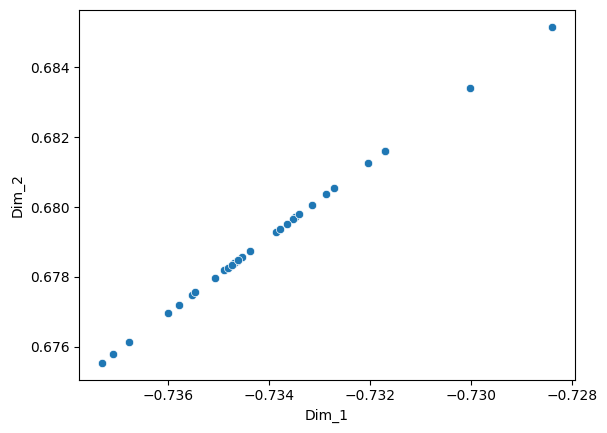

In [50]:
sns.scatterplot(emb_features, x = 'Dim_1', y = 'Dim_2')

/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

<Axes: xlabel='Dim_1', ylabel='Dim_2'>

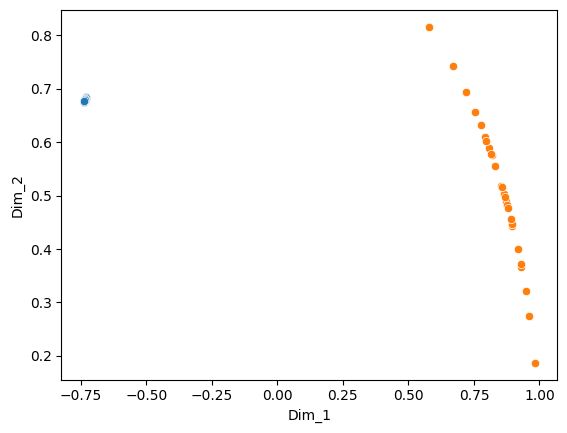

In [49]:
sns.scatterplot(emb_features, x = 'Dim_1', y = 'Dim_2')
sns.scatterplot(emb_targets, x = 'Dim_1', y = 'Dim_2')

In [20]:
mae_train, mae_test = compute_target_score(model, train_loader, test_loader, device, 'mae')
r2_train, r2_test = compute_target_score(model, train_loader, test_loader, device, 'r2')

print(f"Train MAE: {mae_train}, Test MAE: {mae_test}.")
print(f"Train R2: {r2_train}, Test R2: {r2_test}.")

Training target estimator
Training target estimator
Train MAE: 0.2889181077480316, Test MAE: 0.31392902135849.
Train R2: 0.0033421201537302547, Test R2: -0.0011475246149870166.


In [22]:
target_train, target_test, target_pred_train, target_pred_test = estimate_target(model, train_loader, test_loader, device)


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
from utils_v import gather_age_feats

In [25]:
df_train = pd.DataFrame({"Y_Train":target_train, "Y_Train_Pred":target_pred_train})
df_test = pd.DataFrame({"Y_Test": target_test, "Y_Test_Pred":target_pred_test})

/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Y_Train', ylabel='Y_Train_Pred'>

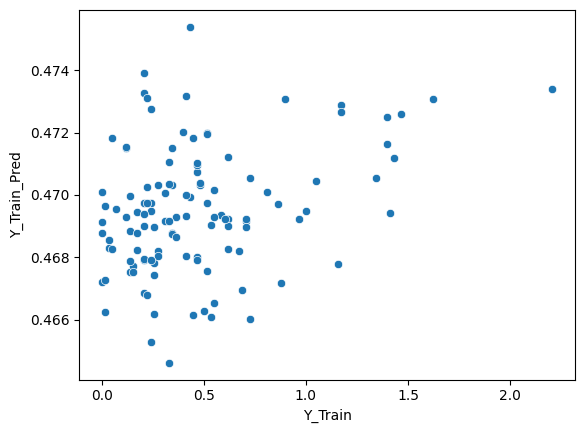

In [26]:
sns.scatterplot(df_train, x = "Y_Train", y="Y_Train_Pred")

/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Y_Test', ylabel='Y_Test_Pred'>

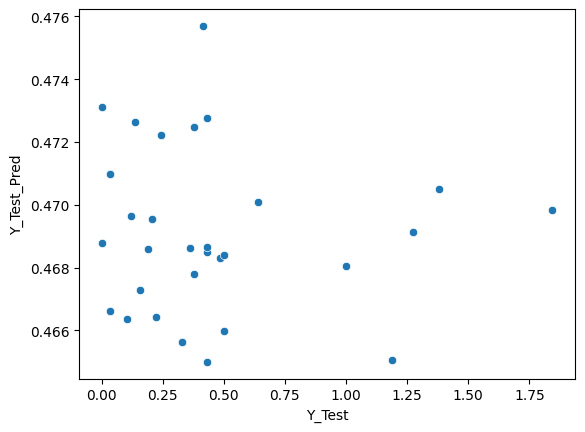

In [27]:
sns.scatterplot(df_test, x = "Y_Test", y="Y_Test_Pred")

## Learning curve

In [29]:
from estimators import TargetEstimator

X_train, y_train = gather_age_feats(model, train_loader, device)
X_test, y_test = gather_age_feats(model, test_loader, device)


In [30]:
X = np.row_stack((X_train, X_test))
y = np.concatenate((y_train, y_test))

In [31]:
estimator = TargetEstimator()

In [34]:
train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, scoring = 'r2') #neg_mean_absolute_percentage_error


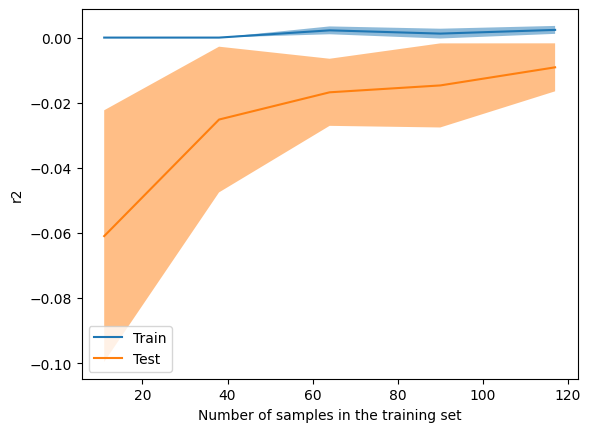

In [35]:
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="r2")
display.plot()
plt.show()
